<a href="https://colab.research.google.com/github/Chunhao-L/ICML_Fair-Scheduling-with-Predictions/blob/main/Fair_Scheduling_with_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from IPython.utils import tempdir
from google.colab import files
import random
import copy
import collections
import math
import matplotlib.pyplot as plt
import numpy as np
#predict_error is \eta, it cannot be smaller than 1 here.
def generate_jobs(releaseTime_lb,releaseTime_ub,jobSize_lb,jobSize_ub,job_amount,predict_error):
  randomReleaseTime = random.choices(range(releaseTime_lb,releaseTime_ub), weights=None, cum_weights=None, k=job_amount)
  randomJobSize = random.choices(range(jobSize_lb,jobSize_ub), weights=None, cum_weights=None, k=job_amount)
  # for i in range(100):
  #   randomJobSize.append(500)
  #randomJobSize = np.random.lognormal(4.5, 1, job_amount)
  #randomJobSize = []
  for i in range(job_amount):
    ele = math.ceil(math.log(random.uniform(0, 1)) * -1 * jobSize_lb)
    if ele <= 1:
      ele = 1
    # ele = round(math.log(random.uniform(0, 1)) * -1 * jobSize_lb, 1)
    # if ele <= 0:
    #   ele = 0.1
    if ele > 10*jobSize_lb:
      ele = 10*jobSize_lb
    randomJobSize.append(ele)
  randomJobSize.append(100)
  J=sorted(list(zip(randomReleaseTime,randomJobSize)))
  Job_id_Counter=1
  error_bound=math.log(predict_error)
  for i in range(0,len(J)):
    #       0         1               2         3             4
    # JOBS LeftSize, JobReleaseTime,JobSize, job_ID, predict_error (-ln\eta,ln\eta)
    error_i=random.uniform(-error_bound,error_bound)
    J[i]=[J[i][1]]+list(J[i])+[Job_id_Counter]+[error_i]
    Job_id_Counter+=1
  return J

def update_pre_err(batch_J,predict_error):
  error_bound=math.log(predict_error)
  for x in range(0,len(batch_J)):
    J=batch_J[x]
    for i in range(0,len(J)):
      error_i=random.uniform(-error_bound,error_bound)
      J[i].updatePredictError(error_i)
  return batch_J



#predict_error is \eta, it cannot be smaller than 1 here.
def log_generate_jobs(releaseTime_lb,releaseTime_ub,scale_ratio,job_amount,predict_error):
  randomReleaseTime = random.choices(range(releaseTime_lb,releaseTime_ub), weights=None, cum_weights=None, k=job_amount)
  randomJobSize = []
  for i in range(job_amount):
    ele = math.ceil(- math.log(random.uniform(0, 1)) * scale_ratio)
    if ele <= 1:
      ele = 1
    # if ele > 10*jobSize_lb:
    #   ele = 10*jobSize_lb
    # ele = ele + jobSize_ub
    randomJobSize.append(ele)
  J=sorted(list(zip(randomReleaseTime,randomJobSize)))
  Job_id_Counter=1
  error_bound=math.log(predict_error)
  for i in range(0,len(J)):
    #       0         1               2         3             4
    # JOBS LeftSize, JobReleaseTime,JobSize, job_ID, predict_error (-ln\eta,ln\eta)
    error_i=random.uniform(-error_bound,error_bound)
    J[i]=[J[i][1]]+list(J[i])+[Job_id_Counter]+[error_i]
    Job_id_Counter+=1
  return J

def log_generate_reverse_Large_jobs(releaseTime_lb,releaseTime_ub,scale_ratio,job_amount,predict_error):
  randomReleaseTime = random.choices(range(releaseTime_lb,releaseTime_ub), weights=None, cum_weights=None, k=job_amount)
  randomJobSize = []
  for i in range(job_amount):
    ele = math.ceil(- math.log(random.uniform(0, 1)) * scale_ratio)
    if ele <= 1:
      ele = 1
    # if ele > 10*jobSize_lb:
    #   ele = 10*jobSize_lb
    # ele = ele + jobSize_ub
    randomJobSize.append(ele)
    randomJobSize.sort(reverse=True)
  J=sorted(list(zip(randomReleaseTime,randomJobSize)))
  Job_id_Counter=1
  error_bound=math.log(predict_error)
  for i in range(0,len(J)):
    #       0         1               2         3             4
    # JOBS LeftSize, JobReleaseTime,JobSize, job_ID, predict_error (-ln\eta,ln\eta)
    error_i=random.uniform(-error_bound,error_bound)
    J[i]=[J[i][1]]+list(J[i])+[Job_id_Counter]+[error_i]
    Job_id_Counter+=1
  return J

class Job:
  def __init__(self,i_leftSize,i_releaseTime,i_jobSize,i_jobID,i_error,i_deadline=float('inf')):
    self.leftSize=i_leftSize
    self.releaseTime=i_releaseTime
    self.jobSize=i_jobSize
    self.jobID=i_jobID
    self.deadline=i_deadline
    self.predictError=math.e**i_error
    self.predictSize=math.ceil(self.predictError*i_jobSize)
    self.completionTime = float('inf')
    self.in_alpha = 0
    self.in_beta = 0

  # def __init__(self,i_leftSize,i_releaseTime,i_jobSize,i_jobID,i_error,i_deadline=float('inf')):
  #   self.leftSize=i_leftSize
  #   self.releaseTime=i_releaseTime
  #   self.jobSize=i_jobSize
  #   self.jobID=i_jobID
  #   self.deadline=i_deadline
  #   self.predictError=i_error
  #   self.predictSize=math.ceil(i_error)
  #   self.completionTime = float('inf')
  #   self.in_alpha = 0
  #   self.in_beta = 0
  def updateDeadline(self,machineSpeed,stretch):
    self.deadline=self.releaseTime+self.jobSize/machineSpeed*stretch
  def calculateStretch(self,finishTime,machineSpeed):
    return (finishTime-self.releaseTime)*machineSpeed/self.jobSize
  def updatePredictDeadline(self, machineSpeed, stretch):
    self.deadline=self.releaseTime+self.predictSize/machineSpeed*stretch
  def updatePredictError(self,i_error):
    self.predictError=math.e**i_error
    self.predictSize=math.ceil(self.predictError*self.jobSize)
  def update_leftSize(self,newLeftSize):
    self.leftSize=newLeftSize
  def print_show(self):
    print("~~~")
    print("job id: ",self.jobID)
    # print("release time: ", self.releaseTime)
    # print("jobSize: ", self.jobSize)
    # print("predict Size: ", self.predictSize)
    # print("predict error: ", self.predictError)
    print("left Size: ",self.leftSize)

  def calculateResponseTime(self,finishTime):
    return finishTime-self.releaseTime
# Put the target job list into following format.
#         0         1               2         3             4
#  JOBS LeftSize, JobReleaseTime,JobSize, job_ID, predict_error (1/r,r)
def convert_jobs(Job_lists):
  temp=[]
  for j in Job_lists:
    temp.append(Job(j[0],j[1],j[2],j[3],j[4]))
  return temp

def add_newJob(newJob,Released_Jobs,machineSpeed,stretch):
  newJob.updateDeadline(machineSpeed,stretch)
  Released_Jobs.append(newJob)

def generateBatchLogJob(releaseTime_lb,releaseTime_ub,scale_ratio,job_amount,predict_error,jobSetNum,reverseLarge=False):
  result=[]
  if reverseLarge:
    for _ in range(0,jobSetNum):
      test=log_generate_jobs(releaseTime_lb,releaseTime_ub,scale_ratio,job_amount,predict_error)
      test=convert_jobs(test)
      result.append(test)
      return result
  for _ in range(0,jobSetNum):
    test=log_generate_jobs(releaseTime_lb,releaseTime_ub,scale_ratio,job_amount,predict_error)
    test=convert_jobs(test)
    result.append(test)
  return result


def generateRRworst(jobSetNum,amount=100):
  #Generate rr worst cases
  mul=2
  counter=1
  test=[]
  while counter<amount:
    js=mul**counter-mul**(counter-1)
    test.append([js,0,js,counter,0.0])
    counter+=1
  #print(test)
  test=convert_jobs(test)
  #测试一开始手动加大job会不会有类似效果
  return [test]

def add_new_job_predict(new_job, job_list, machineSpeed, stretch):
  new_job.updatePredictDeadline(machineSpeed, stretch)
  job_list.append(new_job)

#update all released job deadline
def updating_deadline(released_Jobs,machineSpeed,newStretch):
  for i in range(0,len(released_Jobs)):
    released_Jobs[i].updateDeadline(machineSpeed,newStretch)
  released_Jobs.sort(key=lambda x:x.deadline)
  return released_Jobs

#find maxPredict and minPredict size of job lists:
def max_min_predSize(job_lists):
  l,r=float('inf'), 0
  for j in job_lists:
    l=min(l,j.predictSize)
    r=max(r,j.predictSize)
  return l,r

def max_min_Size(job_lists):
  l,r=float('inf'), 0
  for j in job_lists:
    l=min(l,j.jobSize)
    r=max(r,j.jobSize)
  return l,r


#calculate variance
def calculate_variance(numbers):
    # First, calculate the mean of the numbers
    mean = sum(numbers) / len(numbers)
    # Now, calculate the variance
    variance = sum((x - mean) ** 2 for x in numbers) / len(numbers)
    return variance

# def generate_boxplots(data_pairs,y_label, title, colors=['#1F78B4', '#008080', '#FFBF00', '#006400', '#6A3D9A']):
#     fig, ax = plt.subplots()

#     # Unpack the data pairs into names and data for boxplotting
#     names, data = zip(*data_pairs)
#     # Create boxplot
#     bplot=ax.boxplot(data, patch_artist=True)
#     # Color the boxes
#     for patch, color in zip(bplot['boxes'], colors):
#         patch.set_facecolor(color)
#     # Set x-axis labels
#     ax.set_xticklabels(names, rotation=45, fontsize=38)
#     # Set y-axis label
#     ax.set_ylabel(y_label,fontsize=38)
#     # Add a title to the plot
#     ax.set_title(title)
#     # Show grid lines for better readability
#     ax.yaxis.grid(True)
#     # Display the plot
#     plt.grid(True)
#     plt.tight_layout()  # Adjust layout to prevent label cutoff
#     filename = f"{title} {y_label}.pdf"
#     plt.savefig(filename, format='pdf', bbox_inches='tight')
#     files.download(filename)
#     plt.show()

def generate_boxplots(data_pairs, y_label, title, colors=['#1F78B4', '#008080', '#FFBF00', '#006400', '#6A3D9A']):
    fig, ax = plt.subplots()

    # Unpack the data pairs into names and data for boxplotting
    names, data = zip(*data_pairs)

    # Create boxplot
    bplot = ax.boxplot(data, patch_artist=True)

    # Color the boxes
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

    # Set x-axis labels
    ax.set_xticklabels(names, rotation=45, fontsize=34)

    # Set y-axis label
    ax.set_ylabel(y_label, fontsize=34)

    # Increase font size of y-axis tick labels
    ax.tick_params(axis='y', labelsize=34)

    # Add a title to the plot
    ax.set_title(title)

    # Show grid lines for better readability
    ax.yaxis.grid(True)

    # Display the plot
    plt.grid(True)
    plt.tight_layout()  # Adjust layout to prevent label cutoff
    filename = f"{title} {y_label}.pdf"
    plt.savefig(filename, format='pdf', bbox_inches='tight')
    files.download(filename)  # Uncomment this line if you are using Google Colab
    plt.show()


def generate_variance_bar_chart(data_input):
    # Calculate variances
    categories = [pair[0] for pair in data_input]
    variances = [np.var(pair[1], ddof=1) for pair in data_input]  # ddof=1 for sample variance
    # Generate the bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(categories, variances, color='skyblue')
    # plt.title('Bar Chart of Variances')
    # plt.xlabel('Categories')
    plt.ylabel('Variance')
    plt.show()

def plot_variance(variance_pairs):
    """
    Parameters:
    variance_pairs (list of tuples): A list of tuples where the first element is the label and the second is the variance.
    """

    # Separate the tuple into two lists for plotting
    labels, variances = zip(*variance_pairs)
    # The actual plotting code
    fig, ax = plt.subplots()
    ax.bar(labels, variances, color='skyblue')
    # Adding labels and title
    ax.set_ylabel('Variances')
    ax.set_title('Comparison of Variances')
    plt.xticks(rotation=45)  # Rotate the x labels to fit longer names if necessary
    # Show the plot
    plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
    plt.show()

def min_max_normalize(data):
    # Extract all values
    all_values = [value for _, values in data for value in values]

    # Calculate min and max
    min_val = min(all_values)
    max_val = max(all_values)

    # Function to normalize a single value
    def normalize(value):
        return (value - min_val) / (max_val - min_val) if max_val > min_val else value

    # Normalize and reformat data
    normalized_data=[(name,[normalize(value) for value in values]) for name,values in data]
    return normalized_data




In [3]:
#for checking released jobs over online scenarios, not applicable for offline case
def valid_releasedJob_deadline(current_time,Released_Jobs,machineSpeed):
  t=current_time
  for j in Released_Jobs:
    leftProcessingTime=j.leftSize/machineSpeed
    t+=leftProcessingTime
    if t>j.deadline:
      return False
  return True

#find the new stretch by binary search based on all jobs so far
def find_stretch_so_far(All_Job_SoFar,currentStretch,machineSpeed):
  valid_releasedJob_deadline(0,All_Job_SoFar,machineSpeed)
  if valid_releasedJob_deadline(0,All_Job_SoFar,machineSpeed):
    return currentStretch
  else:
    l,r=currentStretch,10*currentStretch
    tempJobSet=copy.copy(All_Job_SoFar)
    while r >= l:
      mid = (l+r)//2
      updating_deadline(tempJobSet,machineSpeed,mid)
      x = valid_releasedJob_deadline(0,tempJobSet,machineSpeed)
      if l==r:
        if x:
          return r
        else:
          break
      elif x:
        r=mid
      else:
        l=mid+1
    return find_stretch_so_far(All_Job_SoFar,currentStretch*10+1,machineSpeed)

#find the stretch based on left jobs
def single_ssf_stretch_finder(current_time,released_job,currentStretch,machineSpeed):
  t=current_time
  l,r=currentStretch,10*currentStretch
  tempJobSet=copy.copy(released_job)
  while r >= l:
    mid = (l+r)//2
    updating_deadline(tempJobSet,machineSpeed,mid)
    x = valid_releasedJob_deadline(t,tempJobSet,machineSpeed)
    if l==r:
      if x:
        return r
      else:
        break
    elif x:
      r=mid
    else:
      l=mid+1
  return single_ssf_stretch_finder(t,released_job,currentStretch*10+1)

In [4]:
#single machine edf no interreption execution
#return max-stretch during this period
def EDF_singleMachine_execution_noInterreption(jobs,CurrentTime,FinishTime,machineSpeed)->int:
  tempS=1
  equal_processing_capacity=machineSpeed*(FinishTime-CurrentTime)
  t=CurrentTime
  while equal_processing_capacity:
    if jobs==[]:
      return tempS
    elif jobs[0].leftSize<=equal_processing_capacity:
      equal_processing_capacity-=jobs[0].leftSize
      newFinish=jobs.pop(0)
      t+=newFinish.leftSize/machineSpeed
      newS=newFinish.calculateStretch(t,machineSpeed)
      tempS=max(tempS,newS)
    else:
      jobs[0].leftSize-=equal_processing_capacity
      return tempS
  return 1

#semi-Clairvoyant: scheduler know job size upon its release but no aware of future job
#return Max-Stretch
def SSF_EDF_semiClairvoyant(assigned_jobs,machineSpeed):
  t=0
  released_jobs=[] #including only unfinished jobs
  All_Released_Jobs=[] #including all jobs, unexecuted, from 0 to now
  stretch=1
  actualStretch=1
  while assigned_jobs:
    # print(assigned_jobs)
    newjob=assigned_jobs.pop(0)
    o_newjob=copy.deepcopy(newjob)
    t=newjob.releaseTime
    add_newJob(newjob,released_jobs,machineSpeed,stretch)
    add_newJob(o_newjob,All_Released_Jobs,machineSpeed,stretch)
    released_jobs.sort(key=lambda x:x.deadline)
    All_Released_Jobs.sort(key=lambda x:x.deadline)
    #updating stretch so far
    if not valid_releasedJob_deadline(0,All_Released_Jobs,machineSpeed):
      stretch=find_stretch_so_far(All_Released_Jobs,stretch,machineSpeed)
      # print("updated new stretch, ",stretch)
      updating_deadline(released_jobs,machineSpeed,stretch)
      updating_deadline(All_Released_Jobs,machineSpeed,stretch)
      #print(released_jobs)
    finish_time=float('inf')
    if assigned_jobs:
      finish_time=assigned_jobs[0].releaseTime
    newS=EDF_singleMachine_execution_noInterreption(released_jobs,t,finish_time,machineSpeed)
    actualStretch=max(newS,actualStretch)
    # print(released_jobs)
  # print(stretch)
  return actualStretch,stretch



In [5]:
#single machine rr no interreption execution
#return max-stretch during this period
def rr_singleMachine_execution_noInterreption(jobs,CurrentTime,FinishTime,machineSpeed)->int:
  tempS=1
  stretchRecord=[]
  resTimeRecord=[]
  equal_processing_capacity=machineSpeed*(FinishTime-CurrentTime)
  t=CurrentTime
  jobs.sort(key=lambda x:x.leftSize,reverse=True)
  left_num=len(jobs)
  #for j in jobs:
    #print("job: ",j.releaseTime,j.leftSize)
  #print(CurrentTime,FinishTime)
  while equal_processing_capacity:
    if jobs==[]:
      return stretchRecord,resTimeRecord
    elif jobs[-1].leftSize*left_num<=equal_processing_capacity:
      equal_processing_capacity-=jobs[-1].leftSize*left_num
      newFinish=jobs.pop()
      t+=newFinish.leftSize*left_num/machineSpeed
      for i in range(0,len(jobs)):
        jobs[i].leftSize-=newFinish.leftSize
      #print("a job finished at time:  ",t)
      newS=newFinish.calculateStretch(t,machineSpeed)
      newRes=t-newFinish.releaseTime
      tempS=max(tempS,newS)
      left_num-=1
      stretchRecord.append(newS)
      resTimeRecord.append(newRes)
    else:
      average_p=equal_processing_capacity/left_num
      for i in range(0,len(jobs)):
        jobs[i].leftSize-=equal_processing_capacity/left_num
      # return tempS
      return stretchRecord,resTimeRecord
  return stretchRecord,resTimeRecord

#single machine rr
#return max-stretch during this period
#jobs need to be sorted in decreasing order.
def rr(assigned_jobs,machineSpeed)-> int:
  t=0
  released_jobs=[] #including only unfinished jobs
  actualStretch=1
  allStretchRecord=[]
  allResTimeRecord=[]
  while assigned_jobs:
    # print(assigned_jobs)
    newjob=assigned_jobs.pop(0)
    o_newjob=copy.deepcopy(newjob)
    t=newjob.releaseTime
    released_jobs.append(o_newjob)
    released_jobs.sort(key=lambda x:x.leftSize,reverse=True)
    finish_time=float('inf')
    if assigned_jobs:
      finish_time=assigned_jobs[0].releaseTime
    # newS=rr_singleMachine_execution_noInterreption(released_jobs,t,finish_time,machineSpeed)
    newStretchsThisExe,newResTimeThisExe=rr_singleMachine_execution_noInterreption(released_jobs,t,finish_time,machineSpeed)
    allStretchRecord+=newStretchsThisExe
    allResTimeRecord+=newResTimeThisExe
    #print("exectue rr between: ",t,finish_time)
    # print(newS,actualStretch)
    # actualStretch=max(newS,actualStretch)
    #print(allStretchRecord)
    # print(released_jobs)
  # print(stretch)
  if len(released_jobs):
    newStretchsThisExe,newResTimeThisExe=rr_singleMachine_execution_noInterreption(released_jobs,t,float('inf'),machineSpeed)
    allStretchRecord+=newStretchsThisExe
    allResTimeRecord+=newResTimeThisExe
  #print("res test :", len(allResTimeRecord))
  actualStretch=max(allStretchRecord)
  #print(len(allStretchRecord))
  return actualStretch,calculate_variance(allStretchRecord),sum(allResTimeRecord)/len(allResTimeRecord)

In [6]:
#Relaxed Greedy New

from collections import deque
def relaxed_greedy(assigned_jobs,machineSpeed):
  def relaxed_greedy_job_release(threshold_a,small_job_deque,big_job_deque,new_job):
    if new_job.predictSize <= threshold_a:
      small_job_deque.append(new_job)
    else:
      big_job_deque.append(new_job)
  def relaxed_greedy_job_choose(small_job_deque,big_job_deque,current_t,a,b):
    flag=0 #return 0 if either array has no existing job
    relaxed_stretch=-float('inf')
    if len(small_job_deque):
      small_release_t=small_job_deque[0].releaseTime
      relaxed_stretch=(current_t-small_release_t)/a
      flag=1
    if len(big_job_deque):
      big_release_t=big_job_deque[0].releaseTime
      b_relaxed_stretch=(current_t-big_release_t)/b
      # print("find large job relaxed stretch")
      # print(current_t)
      # print(big_release_t)
      # print(b)
      # print(b_relaxed_stretch)
      # print("--------")
      if b_relaxed_stretch>relaxed_stretch:
        relaxed_stretch=b_relaxed_stretch
        flag=2
    return flag
  def relaxed_greedy_execu_single_selected_job(flag,small_job_deque,big_job_deque,current_t,finish_t,machine_speed,stretch_record,resTime_record):
    target_job=None
    if flag==1:
      target_job=small_job_deque[0]
    elif flag==2:
      target_job=big_job_deque[0]
    time_needed=target_job.leftSize/machine_speed
    available_time=finish_t-current_t
    if available_time>=time_needed: #complete the job
      target_job_finish_time=current_t+time_needed
      target_job_finish_stretch=target_job.calculateStretch(target_job_finish_time,machine_speed)
      stretch_record.append(target_job_finish_stretch)
      resTime_record.append(target_job.calculateResponseTime(target_job_finish_time))
      #print("release Time:", target_job.releaseTime, ", completion Time: ", target_job_finish_time, " job size: ", target_job.jobSize,"  predict size: ",target_job.predictSize, " stretch: ", target_job_finish_stretch)
      if flag==1:small_job_deque.popleft()
      if flag==2:big_job_deque.popleft()
      return target_job_finish_time #return the job completion time
    else: #cur job cannot be finished
      complete_work_load=machine_speed*available_time
      target_job.update_leftSize(target_job.leftSize-complete_work_load)
      return finish_t
  def relaxed_greedy_execution(small_job_deque,big_job_deque,current_t,finish_t,machine_speed,stretch_record,tr_a,tr_b,resTime_record):
    #print("execution between ", current_t, finish_t)
    temp_t=current_t
    while temp_t<finish_t:
      # print(small_job_deque)
      # print(big_job_deque)
      flag=relaxed_greedy_job_choose(small_job_deque,big_job_deque,temp_t,tr_a,tr_b)
      # print(flag)
      #break when there is no job in the queue
      if flag==0:
        break
      #executing: small job (flag==1), big job(flag==2)
      else:
        temp_t=relaxed_greedy_execu_single_selected_job(flag,small_job_deque,big_job_deque,temp_t,finish_t,machine_speed,stretch_record,resTime_record)

  t=0
  p_min,p_max=max_min_predSize(assigned_jobs)
  a,b=math.sqrt(p_min*p_max)/math.sqrt(3),p_max
  stretch_Records=[]
  res_Records=[]
  assigned_jobs=deque(assigned_jobs)
  small_Jobs,big_Jobs=deque(),deque()
  #print("a and b are: ",a," and ", b)
  while assigned_jobs:
    newjob=assigned_jobs.popleft()
    relaxed_greedy_job_release(a,small_Jobs,big_Jobs,newjob)
    t=newjob.releaseTime
    next_t=float('inf')
    if assigned_jobs:next_t=assigned_jobs[0].releaseTime #next job release event trigger time
    relaxed_greedy_execution(small_Jobs,big_Jobs,t,next_t,machineSpeed,stretch_Records,a,b,res_Records)
  #print("res test ",len(res_Records))
  m_stretch=max(stretch_Records)
  return m_stretch,calculate_variance(stretch_Records),sum(res_Records)/len(res_Records)




In [7]:
#Adaptive Relaxed Greedy
#the range of pmin_error_ratio should be +- 1 to \lambda
from collections import deque
def adaptive_relaxed_greedy(assigned_jobs,machineSpeed,pmin_error_ratio):
  def adaptive_relaxed_greedy_job_release(threshold_a,small_job_deque,big_job_deque,new_job):
    if new_job.predictSize <= threshold_a:
      small_job_deque.append(new_job)
    else:
      big_job_deque.append(new_job)
  def adaptive_relaxed_greedy_job_choose(small_job_deque,big_job_deque,current_t,a,b):
    flag=0 #return 0 if either array has no existing job
    relaxed_stretch=-float('inf')
    if len(small_job_deque):
      small_release_t=small_job_deque[0].releaseTime
      relaxed_stretch=(current_t-small_release_t)/a
      flag=1
    if len(big_job_deque):
      big_release_t=big_job_deque[0].releaseTime
      b_relaxed_stretch=(current_t-big_release_t)/b
      # print("find large job relaxed stretch")
      # print(current_t)
      # print(big_release_t)
      # print(b)
      # print(b_relaxed_stretch)
      # print("--------")
      if b_relaxed_stretch>relaxed_stretch:
        relaxed_stretch=b_relaxed_stretch
        flag=2
    return flag
  def adaptive_relaxed_greedy_execu_single_selected_job(flag,small_job_deque,big_job_deque,current_t,finish_t,machine_speed,stretch_record,resTime_record):
    target_job=None
    if flag==1:
      target_job=small_job_deque[0]
    elif flag==2:
      target_job=big_job_deque[0]
    time_needed=target_job.leftSize/machine_speed
    available_time=finish_t-current_t
    if available_time>=time_needed: #complete the job
      target_job_finish_time=current_t+time_needed
      target_job_finish_stretch=target_job.calculateStretch(target_job_finish_time,machine_speed)
      stretch_record.append(target_job_finish_stretch)
      resTime_record.append(target_job.calculateResponseTime(target_job_finish_time))
      #print("release Time:", target_job.releaseTime, ", completion Time: ", target_job_finish_time, " job size: ", target_job.jobSize,"  predict size: ",target_job.predictSize, " stretch: ", target_job_finish_stretch)
      if flag==1:small_job_deque.popleft()
      if flag==2:big_job_deque.popleft()
      return target_job_finish_time #return the job completion time
    else: #cur job cannot be finished
      complete_work_load=machine_speed*available_time
      target_job.update_leftSize(target_job.leftSize-complete_work_load)
      return finish_t
  def adaptive_relaxed_greedy_execution(small_job_deque,big_job_deque,current_t,finish_t,machine_speed,stretch_record,tr_a,tr_b,resTime_record):
    #print("execution between ", current_t, finish_t)
    temp_t=current_t
    while temp_t<finish_t:
      # print(small_job_deque)
      # print(big_job_deque)
      flag=adaptive_relaxed_greedy_job_choose(small_job_deque,big_job_deque,temp_t,tr_a,tr_b)
      # print(flag)
      #break when there is no job in the queue
      if flag==0:
        break
      #executing: small job (flag==1), big job(flag==2)
      else:
        temp_t=adaptive_relaxed_greedy_execu_single_selected_job(flag,small_job_deque,big_job_deque,temp_t,finish_t,machine_speed,stretch_record,resTime_record)

  t=0
  p_min,_=max_min_predSize(assigned_jobs)
  p_max=-1
  if pmin_error_ratio<0:
    p_min=p_min/(-pmin_error_ratio)
  elif pmin_error_ratio>0:
    p_min=p_min*pmin_error_ratio
  a,b=None,None
  # a,b=math.sqrt(p_min*p_max)/math.sqrt(3),p_max
  stretch_Records=[]
  res_Records=[]
  assigned_jobs=deque(assigned_jobs)
  small_Jobs,big_Jobs=deque(),deque()
  #print("a and b are: ",a," and ", b)
  while assigned_jobs:
    newjob=assigned_jobs.popleft()
    #update a and b
    if newjob.predictSize>p_max:
      p_max=newjob.predictSize
      a,b=math.sqrt(p_min*p_max)/math.sqrt(3),p_max
    adaptive_relaxed_greedy_job_release(a,small_Jobs,big_Jobs,newjob)
    t=newjob.releaseTime
    next_t=float('inf')
    if assigned_jobs:next_t=assigned_jobs[0].releaseTime #next job release event trigger time
    adaptive_relaxed_greedy_execution(small_Jobs,big_Jobs,t,next_t,machineSpeed,stretch_Records,a,b,res_Records)
  m_stretch=max(stretch_Records)
  return m_stretch,calculate_variance(stretch_Records),sum(res_Records)/len(res_Records)

In [8]:
#Greedy with Rounding New

from collections import deque
def greedy_with_rounding(assigned_jobs,machineSpeed):
  def greedy_with_rounding_job_release(threshold_a,small_job_deque,big_job_deque,new_job):
    if new_job.jobSize <= threshold_a:
      small_job_deque.append(new_job)
    else:
      big_job_deque.append(new_job)
  def greedy_with_rounding_job_choose(small_job_deque,big_job_deque,current_t,a,b):
    flag=0 #return 0 if either array has no existing job
    relaxed_stretch=-float('inf')
    if len(small_job_deque):
      small_release_t=small_job_deque[0].releaseTime
      relaxed_stretch=(current_t-small_release_t)/a
      flag=1
    if len(big_job_deque):
      big_release_t=big_job_deque[0].releaseTime
      b_relaxed_stretch=(current_t-big_release_t)/b
      # print("find large job relaxed stretch")
      # print(current_t)
      # print(big_release_t)
      # print(b)
      # print(b_relaxed_stretch)
      # print("--------")
      if b_relaxed_stretch>relaxed_stretch:
        relaxed_stretch=b_relaxed_stretch
        flag=2
    return flag
  def greedy_with_rounding_execu_single_selected_job(flag,small_job_deque,big_job_deque,current_t,finish_t,machine_speed,stretch_record,resTime_record):
    target_job=None
    if flag==1:
      target_job=small_job_deque[0]
    elif flag==2:
      target_job=big_job_deque[0]
    time_needed=target_job.leftSize/machine_speed
    available_time=finish_t-current_t
    if available_time>=time_needed: #complete the job
      target_job_finish_time=current_t+time_needed
      target_job_finish_stretch=target_job.calculateStretch(target_job_finish_time,machine_speed)
      stretch_record.append(target_job_finish_stretch)
      resTime_record.append(target_job.calculateResponseTime(target_job_finish_time))
      #print("release Time:", target_job.releaseTime, ", completion Time: ", target_job_finish_time, " job size: ", target_job.jobSize,"  predict size: ",target_job.predictSize, " stretch: ", target_job_finish_stretch)
      if flag==1:small_job_deque.popleft()
      if flag==2:big_job_deque.popleft()
      return target_job_finish_time #return the job completion time
    else: #cur job cannot be finished
      complete_work_load=machine_speed*available_time
      target_job.update_leftSize(target_job.leftSize-complete_work_load)
      return finish_t
  def greedy_with_rounding_execution(small_job_deque,big_job_deque,current_t,finish_t,machine_speed,stretch_record,tr_a,tr_b,resTime_record):
    #print("execution between ", current_t, finish_t)
    temp_t=current_t
    while temp_t<finish_t:
      # print(small_job_deque)
      # print(big_job_deque)
      flag=greedy_with_rounding_job_choose(small_job_deque,big_job_deque,temp_t,tr_a,tr_b)
      # print(flag)
      #break when there is no job in the queue
      if flag==0:
        break
      #executing: small job (flag==1), big job(flag==2)
      else:
        temp_t=greedy_with_rounding_execu_single_selected_job(flag,small_job_deque,big_job_deque,temp_t,finish_t,machine_speed,stretch_record,resTime_record)

  t=0
  ac_min,ac_max=max_min_Size(assigned_jobs)
  a,b=math.sqrt(ac_max/ac_min),ac_max/ac_min
  stretch_Records=[]
  res_Records=[]
  assigned_jobs=deque(assigned_jobs)
  small_Jobs,big_Jobs=deque(),deque()
  #print("a and b are: ",a," and ", b)
  while assigned_jobs:
    newjob=assigned_jobs.popleft()
    greedy_with_rounding_job_release(a,small_Jobs,big_Jobs,newjob)
    t=newjob.releaseTime
    next_t=float('inf')
    if assigned_jobs:next_t=assigned_jobs[0].releaseTime #next job release event trigger time
    greedy_with_rounding_execution(small_Jobs,big_Jobs,t,next_t,machineSpeed,stretch_Records,a,b,res_Records)
  m_stretch=max(stretch_Records)
  return m_stretch,calculate_variance(stretch_Records),sum(res_Records)/len(res_Records)


In [9]:
#Shortest Remaining Time First

from collections import deque
def SRPT(assigned_jobs,machineSpeed):
  def SRPT_job_release(released_job,new_job):
    released_job.append(new_job)
    released_job.sort(key=lambda x:x.leftSize)

  def SRPT_execu_single_selected_job(released_job,current_t,finish_t,machine_speed,stretch_record,resTime_record):
    target_job=released_job[0]
    time_needed=target_job.leftSize/machine_speed
    available_time=finish_t-current_t
    if available_time>=time_needed: #complete the job
      target_job_finish_time=current_t+time_needed
      target_job_finish_stretch=target_job.calculateStretch(target_job_finish_time,machine_speed)
      stretch_record.append(target_job_finish_stretch)
      resTime_record.append(target_job.calculateResponseTime(target_job_finish_time))
      released_job.pop(0)
      return target_job_finish_time #return the job completion time
    else: #cur job cannot be finished
      complete_work_load=machine_speed*available_time
      target_job.update_leftSize(target_job.leftSize-complete_work_load)
      return finish_t
  def SRPT_execution(released_job,current_t,finish_t,machine_speed,stretch_record,resTime_record):
    #print("execution between ", current_t, finish_t)
    temp_t=current_t
    while released_job and temp_t<finish_t:
      temp_t=SRPT_execu_single_selected_job(released_job,temp_t,finish_t,machine_speed,stretch_record,resTime_record)

  t=0
  stretch_Records=[]
  res_Records=[]
  assigned_jobs=deque(assigned_jobs)
  released_job=[]
  while assigned_jobs:
    newjob=assigned_jobs.popleft()
    SRPT_job_release(released_job,newjob)
    t=newjob.releaseTime
    next_t=float('inf')
    if assigned_jobs:next_t=assigned_jobs[0].releaseTime #next job release event trigger time
    SRPT_execution(released_job,t,next_t,machineSpeed,stretch_Records,res_Records)
  m_stretch=max(stretch_Records)
  return m_stretch,calculate_variance(stretch_Records),sum(res_Records)/len(res_Records)


In [10]:
#RR-Augmentated Relaxed_Greedy
from collections import deque
def augmentated_relaxed_greedy(assigned_jobs,machineSpeed,augmentSpeed):
  def cal_other_remain(small_job_arr,big_job_arr,workload,this_t,stretch_record,resTime_record,machine_speed):
    i=len(small_job_arr)-1
    while i>=0:
      small_job_arr[i].update_leftSize(small_job_arr[i].leftSize-workload)
      if small_job_arr[i].leftSize<=0.00000000001:
        # print("finish in rr update :")
        target_job=small_job_arr[i]
        stretch_record.append(target_job.calculateStretch(this_t,max(1,machine_speed)))
        resTime_record.append(target_job.calculateResponseTime(this_t))
        # print("release and finish time")
        # print(target_job.releaseTime, this_t)
        # print("stret is ",target_job.calculateStretch(this_t,machine_speed))
        del small_job_arr[i]
      i-=1
    i=len(big_job_arr)-1
    while i>=0:
      big_job_arr[i].update_leftSize(big_job_arr[i].leftSize-workload)
      if big_job_arr[i].leftSize<=0.00000000001:
        target_job=big_job_arr[i]
        stretch_record.append(target_job.calculateStretch(this_t,machine_speed))
        resTime_record.append(target_job.calculateResponseTime(this_t))
        del big_job_arr[i]
      i-=1
  def next_rr(small_job_arr,big_job_arr,machineSpeed):
    total_j=len(small_job_arr)+len(big_job_arr)
    if machineSpeed<=0:return float('inf'),total_j
    min_j_size=float('inf')
    for j in small_job_arr:
      if j.leftSize<min_j_size:
        min_j_size=j.leftSize
    for j in big_job_arr:
      if j.leftSize<min_j_size:
        min_j_size=j.leftSize
    return min_j_size*total_j/machineSpeed,total_j #return next possible rr event time and # of current jobs
  def augmentated_relaxed_greedy_job_release(threshold_a,small_job_arr,big_job_arr,new_job):
    if new_job.predictSize <= threshold_a:
      small_job_arr.append(new_job)
    else:
      big_job_arr.append(new_job)
  def augmentated_relaxed_greedy_job_choose(small_job_arr,big_job_arr,current_t,a,b):
    flag=0 #return 0 if either array has no existing job
    relaxed_stretch=-float('inf')
    if len(small_job_arr):
      small_release_t=small_job_arr[0].releaseTime
      relaxed_stretch=(current_t-small_release_t)/a
      flag=1
    if len(big_job_arr):
      big_release_t=big_job_arr[0].releaseTime
      b_relaxed_stretch=(current_t-big_release_t)/b
      # print("find large job relaxed stretch")
      # print(current_t)
      # print(big_release_t)
      # print(b)
      # print(b_relaxed_stretch)
      # print("--------")
      if b_relaxed_stretch>relaxed_stretch:
        relaxed_stretch=b_relaxed_stretch
        flag=2
    return flag
  def augmentated_relaxed_greedy_execu_single_selected_job(flag,small_job_arr,big_job_arr,current_t,this_finish_t,machine_speed,augment_speed,stretch_record,resTime_record,job_amount):
    target_job=None
    rr_speed=machine_speed/job_amount
    # print("machine speed ", machine_speed)
    # print("augment_speed ", augment_speed)
    # print("job# ",job_amount)
    # print("rr speed ",rr_speed)
    if flag==1:
      target_job=small_job_arr[0]
    elif flag==2:
      target_job=big_job_arr[0]
    time_needed=target_job.leftSize/(rr_speed+augment_speed)
    available_time=this_finish_t-current_t
    if available_time>=time_needed: #complete the job
      # print("i finished one here !!!!!!!!!!!!!!!!!!!!!!!!!!!")
      # print("release and finish")
      target_job_finish_time=current_t+time_needed
      # print(target_job.releaseTime, target_job_finish_time)
      target_job_finish_stretch=target_job.calculateStretch(target_job_finish_time,max(1,machine_speed))
      stretch_record.append(target_job_finish_stretch)
      # print("stretch is ,",target_job_finish_stretch)
      resTime_record.append(target_job.calculateResponseTime(target_job_finish_time))
      #print("release Time:", target_job.releaseTime, ", completion Time: ", target_job_finish_time, " job size: ", target_job.jobSize,"  predict size: ",target_job.predictSize, " stretch: ", target_job_finish_stretch)
      if flag==1:small_job_arr.pop(0)
      if flag==2:big_job_arr.pop(0)
      rr_load=time_needed*rr_speed
      cal_other_remain(small_job_arr,big_job_arr,rr_load,target_job_finish_time,stretch_record,resTime_record,machine_speed)
      return target_job_finish_time #return the job completion time
    else: #cur job cannot be finished
      complete_work_load=augment_speed*available_time
      target_job.update_leftSize(target_job.leftSize-complete_work_load)
      rr_load=available_time*rr_speed
      cal_other_remain(small_job_arr,big_job_arr,rr_load,this_finish_t,stretch_record,resTime_record,machine_speed)
      return this_finish_t
  def augmentated_relaxed_greedy_execution(small_job_arr,big_job_arr,current_t,finish_t,machine_speed,augment_speed,stretch_record,tr_a,tr_b,resTime_record):
    #print("execution between ", current_t, finish_t)
    temp_t=current_t
    while temp_t<finish_t:
      # print(small_job_arr)
      # print(big_job_arr)
      flag=augmentated_relaxed_greedy_job_choose(small_job_arr,big_job_arr,temp_t,tr_a,tr_b)
      # print(flag)
      #break when there is no job in the queue
      if flag==0:
        break
      #executing: small job (flag==1), big job(flag==2)
      else:
        #next trigger t by round_robin
        rr_t,job_amount=next_rr(small_job_arr,big_job_arr,machine_speed)
        event_t=temp_t+rr_t
        next_t=min(finish_t,event_t)
        # print("#####################################################")
        # print("rr_t is ",rr_t)
        # print("finish_t and event_t",finish_t, event_t)
        # print("here run single tast between ", temp_t, next_t)
        # print('before execution')
        # for j in small_job_arr+big_job_arr:
        #   j.print_show()
        temp_t=augmentated_relaxed_greedy_execu_single_selected_job(flag,small_job_arr,big_job_arr,temp_t,next_t,machine_speed,augment_speed,stretch_record,resTime_record,job_amount)
        # print("after execution")
        # for j in small_job_arr+big_job_arr:
        #   j.print_show()
  t=0
  p_min,p_max=max_min_predSize(assigned_jobs)
  a,b=math.sqrt(p_min*p_max)/math.sqrt(3),p_max
  stretch_Records=[]
  res_Records=[]
  assigned_jobs=deque(assigned_jobs)
  small_Jobs,big_Jobs=[],[]
  #print("a and b are: ",a," and ", b)
  while assigned_jobs:
    newjob=assigned_jobs.popleft()
    augmentated_relaxed_greedy_job_release(a,small_Jobs,big_Jobs,newjob)
    t=newjob.releaseTime
    # print('just added')
    # for j in small_Jobs+big_Jobs:
    #   j.print_show()
    next_t=float('inf')
    if assigned_jobs:next_t=assigned_jobs[0].releaseTime #next job release event trigger time
    augmentated_relaxed_greedy_execution(small_Jobs,big_Jobs,t,next_t,machineSpeed,augmentSpeed,stretch_Records,a,b,res_Records)
  #print("res test ",len(res_Records))
  m_stretch=max(stretch_Records)
  return m_stretch,calculate_variance(stretch_Records),sum(res_Records)/len(res_Records)

In [11]:
#Greedy with Rounding
import math
import sys
#test.sort(key=lambda x:x.releaseTime)
#all_jobs = copy.deepcopy(test)
#test.sort(key=lambda x:x.jobID)
# p_min, p_max = max_min_Size(all_jobs)
# print(p_min)
# print(p_max)
# alpha = math.sqrt(p_max)
# print(alpha)
#beta = p_max
current_running_Time = 0
short_released_jobs = [] #short job released but unfinished at time t
long_released_jobs = [] #long job released but unfinished at time t
#all_released_jobs = copy.deepcopy(test) #including all jobs, unexecuted, from 0 to now
running_job_type = ''
max_stretch = 0.0
counter  = 0

class Event:
  def __init__(self,i_eventTime,i_eventType):
    self.eventTime=i_eventTime
    self.eventType=i_eventType

def GreedyStertch(in_job, currentTime, alpha, beta):
  if in_job.completionTime < currentTime:
    currentTime = in_job.completionTime
  if in_job.predictSize <= alpha:
    return (currentTime-in_job.releaseTime)/alpha
  else:
    return (currentTime-in_job.releaseTime)/beta

def JobRelease_GR(currentTime, event_list, all_jobs, alpha, beta):
  global running_job_type
  new_job = all_jobs.pop(0)
  new_job.leftSize = new_job.jobSize
  o_new_job = copy.deepcopy(new_job)
  job_stretch = GreedyStertch(new_job, currentTime,alpha,beta)
  if new_job.predictSize <= alpha:
    add_new_job_predict(new_job,short_released_jobs, 1, job_stretch)
  else:
    add_new_job_predict(new_job,long_released_jobs,1, job_stretch)

  if len(short_released_jobs) == 1 and len(long_released_jobs) == 0:
    e = Event(currentTime + new_job.jobSize, 1)
    event_list.append(e)
    running_job_type = 'short'

  if len(short_released_jobs) == 0 and len(long_released_jobs) == 1:
    e = Event(currentTime + new_job.jobSize, 1)
    event_list.append(e)
    running_job_type = 'long'

  if all_jobs:
    next_release_event = Event(all_jobs[0].releaseTime, 0)
    event_list.append(next_release_event)
  event_list.sort(key=lambda x:x.eventTime)


def JobComplete_GR(currentTime, event_list,all_released_jobs,alpha,beta):
  global running_job_type
  global max_stretch
  global counter
  # print(counter)
  counter = counter + 1
  if running_job_type == 'short':
    c_job = short_released_jobs.pop(0)
    all_released_jobs[c_job.jobID -1].completionTime = currentTime
    all_released_jobs[c_job.jobID -1].leftSize = 0
    all_released_jobs[c_job.jobID -1].stretch = (currentTime - c_job.releaseTime)/c_job.jobSize
    if max_stretch < (currentTime - c_job.releaseTime)/c_job.jobSize:
      max_stretch = (currentTime - c_job.releaseTime)/c_job.jobSize
  else:
    c_job = long_released_jobs.pop(0)
    all_released_jobs[c_job.jobID -1].completionTime = currentTime
    all_released_jobs[c_job.jobID -1].leftSize = 0
    all_released_jobs[c_job.jobID -1].stretch = (currentTime - c_job.releaseTime)/c_job.jobSize
    if max_stretch < (currentTime - c_job.releaseTime)/c_job.jobSize:
      max_stretch = (currentTime - c_job.releaseTime)/c_job.jobSize
  # print('max_s:' + str(max_stretch))

  if short_released_jobs and long_released_jobs:
    if GreedyStertch(short_released_jobs[0], currentTime,alpha,beta) >= GreedyStertch(long_released_jobs[0], currentTime,alpha,beta):
      next_complete_event = Event(currentTime + short_released_jobs[0].leftSize, 1)
      event_list.append(next_complete_event)
      running_job_type = 'short'
    elif GreedyStertch(short_released_jobs[0], currentTime,alpha,beta) < GreedyStertch(long_released_jobs[0], currentTime,alpha,beta):
      next_complete_event = Event(currentTime + long_released_jobs[0].leftSize, 1)
      event_list.append(next_complete_event)
      running_job_type = 'long'

  elif short_released_jobs:
    next_complete_event = Event(currentTime + short_released_jobs[0].leftSize, 1)
    event_list.append(next_complete_event)
    running_job_type = 'short'
  elif long_released_jobs:
    next_complete_event = Event(currentTime + long_released_jobs[0].leftSize, 1)
    event_list.append(next_complete_event)
    running_job_type = 'long'
  event_list.sort(key=lambda x:x.eventTime)

def GreedyWithRounding(target_jobs):
  global running_job_type
  global current_running_Time
  all_jobs=target_jobs
  next_release_time = sys.maxsize
  next_complete_time = sys.maxsize
  job_switch_time = sys.maxsize
  events = []
  e1 = Event(all_jobs[0].releaseTime, 0)
  events.append(e1)
  p_min, p_max = max_min_Size(target_jobs)
  alpha,beta=math.sqrt(p_max/p_min),p_max/p_min
  all_released_jobs=copy.deepcopy(target_jobs)
  while(events):
    #print(current_running_Time, end = " ")
    # for event in events:
    #   print(str(event.eventTime) + ' ' + str(event.eventType), end = " ")
    # print()
    #print('shorts:' + str(len(short_released_jobs)) + '  ' +'longs:'+ str(len(long_released_jobs)))
    crnt_event = events.pop(0);
    current_running_Time = crnt_event.eventTime

    if crnt_event.eventType == 0:
      JobRelease_GR(current_running_Time, events, target_jobs,alpha,beta)
    elif crnt_event.eventType == 1:
      JobComplete_GR(current_running_Time, events,all_released_jobs,alpha,beta)
  return max_stretch

# GreedyWithRounding(test)
# print(max_stretch)

# for j in all_released_jobs:
#   if j.stretch > 500:
#     print('release Time:' + str(j.releaseTime) +" completion Time:" + str(j.completionTime) +" job size:" +str(j.jobSize) + '  predict size:' + str(j.predictSize)+ ' stretch:'+str(j.stretch))

In [12]:
#batch test
def batch_test(BatchSet,machineSpeed=1,boostSpeed=0):
  GWR_RS,RG_RS,ARG_RS,RR_RS=[],[],[],[]
  GWR_variances,rg_variances,arg_variances,rr_variances=[],[],[],[]
  GWR_RES,RG_RES,ARG_RES,RR_RES=[],[],[],[]
  RR_RG_RS,RR_RG_variances,RR_RG_RES=[],[],[]
  SSF_RS,SSF_variances,SSF_RES=[],[],[]
  SRPT_RS,SRPT_variances,SRPT_RES=[],[],[]
  for test in BatchSet:
    opt_test=copy.deepcopy(test)
    updating_deadline(opt_test,1,1)
    opt_stretch=find_stretch_so_far(opt_test,1,1)
    bi_search_stretch=opt_stretch
    # print("opt_stretch finding ",opt_stretch)

    # min_j_size,max_j_size=max_min_Size(test)
    # print("\delta value is , ",max_j_size/min_j_size)
    # #SSF and Bi_Opt #print("ssf: ",ssf_stretch)
    # SSF_test=copy.deepcopy(test)
    # updating_deadline(opt_test,1,1)


    # ssf_test=copy.deepcopy(test)
    # ssf_stretch,_ =SSF_EDF_semiClairvoyant(ssf_test,machineSpeed)
    # ssf_stretch=math.ceil(ssf_stretch)
    # #---
    # SSF_ratio=ssf_stretch/bi_search_stretch
    # # SSF

    rr_test=copy.deepcopy(test)
    rr_test.sort(key=lambda x:x.releaseTime)
    rr_stretch,rr_variance,rr_restime=rr(rr_test,1)
    #RR actual stretch

    RG_test=copy.deepcopy(test)
    RG_test.sort(key=lambda x:x.releaseTime)
    rg_stretch,rg_variance,rg_restime=relaxed_greedy(RG_test,machineSpeed)
    #Relaxed greedy

    ARG_test=copy.deepcopy(test)
    ARG_test.sort(key=lambda x:x.releaseTime)
    arg_stretch,arg_variance,arg_restime=adaptive_relaxed_greedy(ARG_test,machineSpeed,1)
    #adaptive Relaxed greedy

    GWR_test=copy.deepcopy(test)
    GWR_test.sort(key=lambda x:x.releaseTime)
    GWR_stretch,GWR_variance,GWR_restime=greedy_with_rounding(GWR_test,machineSpeed)
    #greedy with rounding new

    RR_RG_test=copy.deepcopy(test)
    RR_RG_test.sort(key=lambda x:x.releaseTime)
    RR_RG_stretch,RR_RG_variance,RR_RG_restime=augmentated_relaxed_greedy(RR_RG_test,boostSpeed,machineSpeed)
    #RR ARGUMENTED

    SRPT_test=copy.deepcopy(test)
    SRPT_test.sort(key=lambda x:x.releaseTime)
    SRPT_stretch,SRPT_variance,SRPT_restime=SRPT(SRPT_test,machineSpeed)
    SRPT_ratio=SRPT_stretch/bi_search_stretch
    SRPT_RS.append(SRPT_ratio)
    SRPT_variances.append(SRPT_variance)
    SRPT_RES.append(SRPT_restime)
    #SRPT


    GWR_ratio,RG_ratio,ARG_ratio,RR_ratio=GWR_stretch/bi_search_stretch, rg_stretch/bi_search_stretch,arg_stretch/bi_search_stretch, rr_stretch/bi_search_stretch
    RR_RG_ratio=RR_RG_stretch/bi_search_stretch
    #greedy with rounding new,                relaxed greedy,     adaptive relaxed greedy,       rr
    GWR_RS.append(GWR_ratio)
    RG_RS.append(RG_ratio)
    ARG_RS.append(ARG_ratio)
    RR_RS.append(RR_ratio)
    RR_RG_RS.append(RR_RG_ratio)
    #print(GWR_ratio, ", ", RG_ratio, ", ",ARG_ratio, ", ", RR_ratio)
    GWR_variances.append(GWR_variance)
    rg_variances.append(rg_variance)
    arg_variances.append(arg_variance)
    rr_variances.append(rr_variance)
    RR_RG_variances.append(RR_RG_variance)
    #AVERAGE RESPONSE TIME
    GWR_RES.append(GWR_restime/SRPT_restime)
    RG_RES.append(rg_restime/SRPT_restime)
    ARG_RES.append(arg_restime/SRPT_restime)
    RR_RES.append(rr_restime/SRPT_restime)
    RR_RG_RES.append(RR_RG_restime/SRPT_restime)

  # print(GWR_RS)
  # print(RG_RS)
  # print(ARG_RS)
  # print(RR_RS)
  result_pairs= [
      ("GWR", GWR_RS),
      ("RG", RG_RS),
      ("ARG", ARG_RS),
      ("RR",RR_RS),
      ("RG+",RR_RG_RS),
      # ("SRPT",SRPT_RS)
  ]
  variance_pairs= [
      ("GWR", GWR_variances),
      ("RG", rg_variances),
      ("ARG", arg_variances),
      ("RR",rr_variances),
      ("RG+",RR_RG_variances),
      # ("SRPT",SRPT_variances)
  ]
  resTime_pairs= [
      ("GWR", GWR_RES),
      ("RG", RG_RES),
      ("ARG", ARG_RES),
      ("RR",RR_RES),
      ("RG+",RR_RG_RES),
      # ("SRPT",SRPT_RES)
  ]
  variance_pairs=min_max_normalize(variance_pairs)
  print("Performance ratio")
  print(result_pairs)
  print("variance")
  print(variance_pairs)
  print("Average Response time")
  print(resTime_pairs)
  generate_boxplots(result_pairs,"Performance Ratio","")
  generate_boxplots(variance_pairs,"Variance","")
  generate_boxplots(resTime_pairs,"Performance Ratio\n(Response Time)","")



In [ ]:
# # def generate_prediction_error_bar_line_chart()
# #batch test
# def batch_test(BatchSet,machineSpeed=1,boostSpeed=0):
#   GWR_RS,RG_RS,ARG_RS,RR_RS=[],[],[],[]
#   GWR_variances,rg_variances,arg_variances,rr_variances=[],[],[],[]
#   GWR_RES,RG_RES,ARG_RES,RR_RES=[],[],[],[]
#   RR_RG_RS,RR_RG_variances,RR_RG_RES=[],[],[]
#   SSF_RS,SSF_variances,SSF_RES=[],[],[]
#   SRPT_RS,SRPT_variances,SRPT_RES=[],[],[]
#   for test in BatchSet:
#     opt_test=copy.deepcopy(test)
#     updating_deadline(opt_test,1,1)
#     opt_stretch=find_stretch_so_far(opt_test,1,1)
#     bi_search_stretch=opt_stretch
#     # print("opt_stretch finding ",opt_stretch)

#     # min_j_size,max_j_size=max_min_Size(test)
#     # print("\delta value is , ",max_j_size/min_j_size)
#     # #SSF and Bi_Opt #print("ssf: ",ssf_stretch)
#     # SSF_test=copy.deepcopy(test)
#     # updating_deadline(opt_test,1,1)


#     # ssf_test=copy.deepcopy(test)
#     # ssf_stretch,_ =SSF_EDF_semiClairvoyant(ssf_test,machineSpeed)
#     # ssf_stretch=math.ceil(ssf_stretch)
#     # #---
#     # SSF_ratio=ssf_stretch/bi_search_stretch
#     # # SSF

#     rr_test=copy.deepcopy(test)
#     rr_test.sort(key=lambda x:x.releaseTime)
#     rr_stretch,rr_variance,rr_restime=rr(rr_test,1)
#     #RR actual stretch

#     RG_test=copy.deepcopy(test)
#     RG_test.sort(key=lambda x:x.releaseTime)
#     rg_stretch,rg_variance,rg_restime=relaxed_greedy(RG_test,machineSpeed)
#     #Relaxed greedy

#     ARG_test=copy.deepcopy(test)
#     ARG_test.sort(key=lambda x:x.releaseTime)
#     arg_stretch,arg_variance,arg_restime=adaptive_relaxed_greedy(ARG_test,machineSpeed,1)
#     #adaptive Relaxed greedy

#     GWR_test=copy.deepcopy(test)
#     GWR_test.sort(key=lambda x:x.releaseTime)
#     GWR_stretch,GWR_variance,GWR_restime=greedy_with_rounding(GWR_test,machineSpeed)
#     #greedy with rounding new

#     RR_RG_test=copy.deepcopy(test)
#     RR_RG_test.sort(key=lambda x:x.releaseTime)
#     RR_RG_stretch,RR_RG_variance,RR_RG_restime=augmentated_relaxed_greedy(RR_RG_test,boostSpeed,machineSpeed)
#     #RR ARGUMENTED

#     SRPT_test=copy.deepcopy(test)
#     SRPT_test.sort(key=lambda x:x.releaseTime)
#     SRPT_stretch,SRPT_variance,SRPT_restime=SRPT(SRPT_test,machineSpeed)
#     SRPT_ratio=SRPT_stretch/bi_search_stretch
#     SRPT_RS.append(SRPT_ratio)
#     SRPT_variances.append(SRPT_variance)
#     SRPT_RES.append(SRPT_restime)
#     #SRPT


#     GWR_ratio,RG_ratio,ARG_ratio,RR_ratio=GWR_stretch/bi_search_stretch, rg_stretch/bi_search_stretch,arg_stretch/bi_search_stretch, rr_stretch/bi_search_stretch
#     RR_RG_ratio=RR_RG_stretch/bi_search_stretch
#     #greedy with rounding new,                relaxed greedy,     adaptive relaxed greedy,       rr
#     GWR_RS.append(GWR_ratio)
#     RG_RS.append(RG_ratio)
#     ARG_RS.append(ARG_ratio)
#     RR_RS.append(RR_ratio)
#     RR_RG_RS.append(RR_RG_ratio)
#     #print(GWR_ratio, ", ", RG_ratio, ", ",ARG_ratio, ", ", RR_ratio)
#     GWR_variances.append(GWR_variance)
#     rg_variances.append(rg_variance)
#     arg_variances.append(arg_variance)
#     rr_variances.append(rr_variance)
#     RR_RG_variances.append(RR_RG_variance)
#     #AVERAGE RESPONSE TIME
#     GWR_RES.append(GWR_restime/SRPT_restime)
#     RG_RES.append(rg_restime/SRPT_restime)
#     ARG_RES.append(arg_restime/SRPT_restime)
#     RR_RES.append(rr_restime/SRPT_restime)
#     RR_RG_RES.append(RR_RG_restime/SRPT_restime)

#   # print(GWR_RS)
#   # print(RG_RS)
#   # print(ARG_RS)
#   # print(RR_RS)
#   result_pairs= [
#       ("Greedy with Rounding", GWR_RS),
#       ("Relaxed Greedy", RG_RS),
#       ("Adaptive Relaxed Greedy", ARG_RS),
#       ("Round-Robin",RR_RS),
#       ("RG+",RR_RG_RS),
#       # ("SRPT",SRPT_RS)
#   ]
#   variance_pairs= [
#       ("Greedy with Rounding", GWR_variances),
#       ("Relaxed Greedy", rg_variances),
#       ("Adaptive Relaxed Greedy", arg_variances),
#       ("Round-Robin",rr_variances),
#       ("RG+",RR_RG_variances),
#       # ("SRPT",SRPT_variances)
#   ]
#   resTime_pairs= [
#       ("Greedy with Rounding", GWR_RES),
#       ("Relaxed Greedy", RG_RES),
#       ("Adaptive Relaxed Greedy", ARG_RES),
#       ("Round-Robin",RR_RES),
#       ("RG+",RR_RG_RES),
#       # ("SRPT",SRPT_RES)
#   ]
#   variance_pairs=min_max_normalize(variance_pairs)
#   print("Performance ratio")
#   print(result_pairs)
#   print("variance")
#   print(variance_pairs)
#   print("Average Response time")
#   print(resTime_pairs)

#   with open("Group_Test.txt", "w") as output_file:
#       # Redirect the printed content to the text file
#       print("Performance ratio", file=output_file)
#       print(result_pairs, file=output_file)
#       print("variance", file=output_file)
#       print(variance_pairs, file=output_file)
#       print("Average Response time", file=output_file)
#       print(resTime_pairs, file=output_file)

#   # Download the text file
#   from google.colab import files
#   files.download("Group_Test.txt")

#   generate_boxplots(result_pairs,"Performance Ratio","")
#   generate_boxplots(variance_pairs,"Variance","")
#   generate_boxplots(resTime_pairs,"Average Response Time","")

In [13]:
# def generate_prediction_error_bar_line_chart()
#batch test
def batch_record(x_value,S_Data,V_Data,R_Data,BatchSet,machineSpeed=1,boostSpeed=0):
  GWR_RS,RG_RS,ARG_RS,RR_RS=[],[],[],[]
  GWR_variances,rg_variances,arg_variances,rr_variances=[],[],[],[]
  GWR_RES,RG_RES,ARG_RES,RR_RES=[],[],[],[]
  RR_RG_RS,RR_RG_variances,RR_RG_RES=[],[],[]
  SSF_RS,SSF_variances,SSF_RES=[],[],[]
  SRPT_RS,SRPT_variances,SRPT_RES=[],[],[]
  for test in BatchSet:
    opt_test=copy.deepcopy(test)
    updating_deadline(opt_test,1,1)
    opt_stretch=find_stretch_so_far(opt_test,1,1)
    bi_search_stretch=opt_stretch
    # print("opt_stretch finding ",opt_stretch)

    # min_j_size,max_j_size=max_min_Size(test)
    # print("\delta value is , ",max_j_size/min_j_size)
    # #SSF and Bi_Opt #print("ssf: ",ssf_stretch)
    # SSF_test=copy.deepcopy(test)
    # updating_deadline(opt_test,1,1)


    # ssf_test=copy.deepcopy(test)
    # ssf_stretch,_ =SSF_EDF_semiClairvoyant(ssf_test,machineSpeed)
    # ssf_stretch=math.ceil(ssf_stretch)
    # #---
    # SSF_ratio=ssf_stretch/bi_search_stretch
    # # SSF

    rr_test=copy.deepcopy(test)
    rr_test.sort(key=lambda x:x.releaseTime)
    rr_stretch,rr_variance,rr_restime=rr(rr_test,1)
    #RR actual stretch

    RG_test=copy.deepcopy(test)
    RG_test.sort(key=lambda x:x.releaseTime)
    rg_stretch,rg_variance,rg_restime=relaxed_greedy(RG_test,machineSpeed)
    #Relaxed greedy

    ARG_test=copy.deepcopy(test)
    ARG_test.sort(key=lambda x:x.releaseTime)
    arg_stretch,arg_variance,arg_restime=adaptive_relaxed_greedy(ARG_test,machineSpeed,1)
    #adaptive Relaxed greedy

    GWR_test=copy.deepcopy(test)
    GWR_test.sort(key=lambda x:x.releaseTime)
    GWR_stretch,GWR_variance,GWR_restime=greedy_with_rounding(GWR_test,machineSpeed)
    #greedy with rounding new

    RR_RG_test=copy.deepcopy(test)
    RR_RG_test.sort(key=lambda x:x.releaseTime)
    RR_RG_stretch,RR_RG_variance,RR_RG_restime=augmentated_relaxed_greedy(RR_RG_test,boostSpeed,machineSpeed)
    #RR ARGUMENTED

    SRPT_test=copy.deepcopy(test)
    SRPT_test.sort(key=lambda x:x.releaseTime)
    SRPT_stretch,SRPT_variance,SRPT_restime=SRPT(SRPT_test,machineSpeed)
    SRPT_ratio=SRPT_stretch/bi_search_stretch
    SRPT_RS.append(SRPT_ratio)
    SRPT_variances.append(SRPT_variance)
    SRPT_RES.append(SRPT_restime)
    #SRPT


    GWR_ratio,RG_ratio,ARG_ratio,RR_ratio=GWR_stretch/bi_search_stretch, rg_stretch/bi_search_stretch,arg_stretch/bi_search_stretch, rr_stretch/bi_search_stretch
    RR_RG_ratio=RR_RG_stretch/bi_search_stretch
    #greedy with rounding new,                relaxed greedy,     adaptive relaxed greedy,       rr
    GWR_RS.append(GWR_ratio)
    RG_RS.append(RG_ratio)
    ARG_RS.append(ARG_ratio)
    RR_RS.append(RR_ratio)
    RR_RG_RS.append(RR_RG_ratio)
    #print(GWR_ratio, ", ", RG_ratio, ", ",ARG_ratio, ", ", RR_ratio)
    GWR_variances.append(GWR_variance)
    rg_variances.append(rg_variance)
    arg_variances.append(arg_variance)
    rr_variances.append(rr_variance)
    RR_RG_variances.append(RR_RG_variance)
    #AVERAGE RESPONSE TIME
    GWR_RES.append(GWR_restime/SRPT_restime)
    RG_RES.append(rg_restime/SRPT_restime)
    ARG_RES.append(arg_restime/SRPT_restime)
    RR_RES.append(rr_restime/SRPT_restime)
    RR_RG_RES.append(RR_RG_restime/SRPT_restime)

  # print(GWR_RS)
  # print(RG_RS)
  # print(ARG_RS)
  # print(RR_RS)
  result_pairs= [
      ("GWR", GWR_RS),
      ("RG", RG_RS),
      ("ARG", ARG_RS),
      ("RR",RR_RS),
      ("RG+",RR_RG_RS),
      # ("SRPT",SRPT_RS)
  ]
  variance_pairs= [
      ("GWR", GWR_variances),
      ("RG", rg_variances),
      ("ARG", arg_variances),
      ("RR",rr_variances),
      ("RG+",RR_RG_variances),
      # ("SRPT",SRPT_variances)
  ]
  resTime_pairs= [
      ("GWR", GWR_RES),
      ("RG", RG_RES),
      ("ARG", ARG_RES),
      ("RR",RR_RES),
      ("RG+",RR_RG_RES),
      # ("SRPT",SRPT_RES)
  ]
  #variance_pairs=min_max_normalize(variance_pairs)
  for group_name,y_values in result_pairs:
    for single_y in y_values:
      S_Data.append({"Group":group_name,"X":x_value,"Value":single_y})
  for group_name,y_values in variance_pairs:
    for single_y in y_values:
      V_Data.append({"Group":group_name,"X":x_value,"Value":single_y})
  for group_name,y_values in resTime_pairs:
    for single_y in y_values:
      R_Data.append({"Group":group_name,"X":x_value,"Value":single_y})

  # print("Performance ratio")
  # print(result_pairs)
  # print("variance")
  # print(variance_pairs)
  # print("Average Response time")
  # print(resTime_pairs)
  # generate_boxplots(result_pairs,"Performance Ratio","")
  # generate_boxplots(variance_pairs,"Variance","")
  # generate_boxplots(resTime_pairs,"Average Response Time","")

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

def line_plot_show_download(y_values, y_names, x_values, title, xname, yname):
    # Line styles and markers
    line_styles_markers = [
        ('-', 'o'),   # Solid line with circle markers
        ('-', 's'),   # Solid line with square markers
        ('-', 'D'),   # Solid line with diamond markers
        ('-', '^'),   # Solid line with triangle_up markers
        ('-', '*'),   # Solid line with star markers
    ]

    # Colors
    colors = ['#1F78B4', '#008080', '#FFBF00', '#006400', '#6A3D9A']

    # Groups' data
    groups_data = y_values

    # Plotting
    plt.figure(figsize=(24,9))

    for data, (line_style, marker), color in zip(groups_data, line_styles_markers, colors):
        plt.plot(x_values, data, linestyle=line_style, marker=marker, color=color, linewidth=2)

    #plt.title(title)
    plt.xlabel(xname)
    plt.ylabel(yname)
    plt.legend(y_names)
    plt.title(title, fontsize=0)
    plt.xlabel(xname, fontsize=38)
    plt.ylabel(yname, fontsize=38)
    plt.xticks(fontsize=32)
    plt.yticks(fontsize=32)
    plt.legend(y_names, fontsize=24)
    plt.grid(True)
    plt.tight_layout()

    # Save the plot as a PDF file with the title as the filename
    filename = f"{title}.pdf"
    plt.savefig(filename, format='pdf', bbox_inches='tight')
    files.download(filename)
    plt.show()





def worst_line_data(job_amounts,machineSpeed,boostSpeed):
  GWR_PR,RG_PR,ARG_PR,RR_PR,RGP_PR=[],[],[],[],[]
  GWR_VR,RG_VR,ARG_VR,RR_VR,RGP_VR=[],[],[],[],[]
  GWR_RT,RG_RT,ARG_RT,RR_RT,RGP_RT=[],[],[],[],[]
  def worst_rr_line_test(BatchSet,machineSpeed=1,boostSpeed=0):
    GWR_RS,RG_RS,ARG_RS,RR_RS=[],[],[],[]
    GWR_variances,rg_variances,arg_variances,rr_variances=[],[],[],[]
    GWR_RES,RG_RES,ARG_RES,RR_RES=[],[],[],[]
    RR_RG_RS,RR_RG_variances,RR_RG_RES=[],[],[]
    SSF_RS,SSF_variances,SSF_RES=[],[],[]
    SRPT_RS,SRPT_variances,SRPT_RES=[],[],[]
    test=copy.deepcopy(BatchSet[0])
    opt_test=copy.deepcopy(test)
    updating_deadline(opt_test,1,1)
    opt_stretch=find_stretch_so_far(opt_test,1,1)
    bi_search_stretch=opt_stretch
    # print("opt_stretch finding ",opt_stretch)

    # min_j_size,max_j_size=max_min_Size(test)
    # print("\delta value is , ",max_j_size/min_j_size)
    # #SSF and Bi_Opt #print("ssf: ",ssf_stretch)
    # SSF_test=copy.deepcopy(test)
    # updating_deadline(opt_test,1,1)


    # ssf_test=copy.deepcopy(test)
    # ssf_stretch,_ =SSF_EDF_semiClairvoyant(ssf_test,machineSpeed)
    # ssf_stretch=math.ceil(ssf_stretch)
    # #---
    # SSF_ratio=ssf_stretch/bi_search_stretch
    # # SSF

    rr_test=copy.deepcopy(test)
    rr_test.sort(key=lambda x:x.releaseTime)
    rr_stretch,rr_variance,rr_restime=rr(rr_test,1)
    #RR actual stretch

    RG_test=copy.deepcopy(test)
    RG_test.sort(key=lambda x:x.releaseTime)
    rg_stretch,rg_variance,rg_restime=relaxed_greedy(RG_test,machineSpeed)
    #Relaxed greedy

    ARG_test=copy.deepcopy(test)
    ARG_test.sort(key=lambda x:x.releaseTime)
    arg_stretch,arg_variance,arg_restime=adaptive_relaxed_greedy(ARG_test,machineSpeed,1)
    #adaptive Relaxed greedy

    GWR_test=copy.deepcopy(test)
    GWR_test.sort(key=lambda x:x.releaseTime)
    GWR_stretch,GWR_variance,GWR_restime=greedy_with_rounding(GWR_test,machineSpeed)
    #greedy with rounding new

    RR_RG_test=copy.deepcopy(test)
    RR_RG_test.sort(key=lambda x:x.releaseTime)
    RR_RG_stretch,RR_RG_variance,RR_RG_restime=augmentated_relaxed_greedy(RR_RG_test,boostSpeed,machineSpeed)
    #RR ARGUMENTED

    SRPT_test=copy.deepcopy(test)
    SRPT_test.sort(key=lambda x:x.releaseTime)
    SRPT_stretch,SRPT_variance,SRPT_restime=SRPT(SRPT_test,machineSpeed)
    SRPT_ratio=SRPT_stretch/bi_search_stretch
    SRPT_RS.append(SRPT_ratio)
    SRPT_variances.append(SRPT_variance)
    SRPT_RES.append(SRPT_restime)
    #SRPT


    GWR_ratio,RG_ratio,ARG_ratio,RR_ratio=GWR_stretch/bi_search_stretch, rg_stretch/bi_search_stretch,arg_stretch/bi_search_stretch, rr_stretch/bi_search_stretch
    RR_RG_ratio=RR_RG_stretch/bi_search_stretch
    #greedy with rounding new,                relaxed greedy,     adaptive relaxed greedy,       rr
    GWR_RS.append(GWR_ratio)
    RG_RS.append(RG_ratio)
    ARG_RS.append(ARG_ratio)
    RR_RS.append(RR_ratio)
    RR_RG_RS.append(RR_RG_ratio)
    #print(GWR_ratio, ", ", RG_ratio, ", ",ARG_ratio, ", ", RR_ratio)
    GWR_variances.append(GWR_variance)
    rg_variances.append(rg_variance)
    arg_variances.append(arg_variance)
    rr_variances.append(rr_variance)
    RR_RG_variances.append(RR_RG_variance)
    #AVERAGE RESPONSE TIME
    GWR_RES.append(GWR_restime/SRPT_restime)
    RG_RES.append(rg_restime/SRPT_restime)
    ARG_RES.append(arg_restime/SRPT_restime)
    RR_RES.append(rr_restime/SRPT_restime)
    RR_RG_RES.append(RR_RG_restime/SRPT_restime)

    # print(GWR_RS)
    # print(RG_RS)
    # print(ARG_RS)
    # print(RR_RS)
    result_pairs= [
        ("Greedy with Rounding", GWR_RS),
        ("Relaxed Greedy", RG_RS),
        ("Adaptive Relaxed Greedy", ARG_RS),
        ("Round-Robin",RR_RS),
        ("RG+",RR_RG_RS),
        # ("SRPT",SRPT_RS)
    ]
    variance_pairs= [
        ("Greedy with Rounding", GWR_variances),
        ("Relaxed Greedy", rg_variances),
        ("Adaptive Relaxed Greedy", arg_variances),
        ("Round-Robin",rr_variances),
        ("RG+",RR_RG_variances),
        # ("SRPT",SRPT_variances)
    ]
    resTime_pairs= [
        ("Greedy with Rounding", GWR_RES),
        ("Relaxed Greedy", RG_RES),
        ("Adaptive Relaxed Greedy", ARG_RES),
        ("Round-Robin",RR_RES),
        ("RG+",RR_RG_RES),
        # ("SRPT",SRPT_RES)
    ]
    # variance_pairs=min_max_normalize(variance_pairs)
    GWR_PR.append(result_pairs[0][1][0])
    RG_PR.append(result_pairs[1][1][0])
    ARG_PR.append(result_pairs[2][1][0])
    RR_PR.append(result_pairs[3][1][0])
    RGP_PR.append(result_pairs[4][1][0])
    #
    GWR_VR.append(variance_pairs[0][1][0])
    RG_VR.append(variance_pairs[1][1][0])
    ARG_VR.append(variance_pairs[2][1][0])
    RR_VR.append(variance_pairs[3][1][0])
    RGP_VR.append(variance_pairs[4][1][0])
    #
    GWR_RT.append(resTime_pairs[0][1][0])
    RG_RT.append(resTime_pairs[1][1][0])
    ARG_RT.append(resTime_pairs[2][1][0])
    RR_RT.append(resTime_pairs[3][1][0])
    RGP_RT.append(resTime_pairs[4][1][0])

  for cur_jobAmount in job_amounts:
    BatchSet=generateRRworst(1,cur_jobAmount)
    worst_rr_line_test(BatchSet,machineSpeed,boostSpeed)
  y_names=["GWR","RG","ARG","RR","RG+"]
  x_values=job_amounts
  PR=[GWR_PR,RG_PR,ARG_PR,RR_PR,RGP_PR]
  VR=[GWR_VR,RG_VR,ARG_VR,RR_VR,RGP_VR]
  RT=[GWR_RT,RG_RT,ARG_RT,RR_RT,RGP_RT]
  all_vr=[variance for each_group in VR for variance in each_group]
  min_vr,max_vr=min(all_vr),max(all_vr)
  VR_min_max=[[(x-min_vr)/(max_vr-min_vr) for x in each_group] for each_group in VR]
  line_plot_show_download(PR,y_names,x_values,"Stretch Performance Ratio","Number of Jobs","Performance Ratio")
  line_plot_show_download(VR_min_max,y_names,x_values,"Stretch Variance","Number of Jobs","Variance")
  line_plot_show_download(RT,y_names,x_values,"Response Time Performance Ratio","Number of Jobs","Performance Ratio \n(Response Time)")

In [ ]:
# def draw_error_bar(df_data,title_str,xlabel_str,ylabel_str):
#   # dataFeatures
#   groups=["GWR","RG","ARG","RR","RG+"]
#   # Plot settings
#   plt.figure(figsize=(20, 8))
#   capsize = 4
#   alpha = 0.7
#   linewidth = 3
#   offsets = np.linspace(-0.1*groups[0], 0.1*groups[0], len(groups))
#   # styles
#   colors = ['#1F78B4', '#008080', '#FFBF00', '#006400', '#6A3D9A']
#   errorbar_colors = ['#1F78B4', '#008080', '#FFBF00', '#006400', '#6A3D9A']
#   markers = ['o', 's', '^', '*', 'D']
#   # Plotting each group with different markers
#   for offset, color, ecolor, marker, group in zip(offsets, colors, errorbar_colors, markers, groups):
#       group_df = df_data[df_data['Group'] == group]
#       mean_values = group_df.groupby('X').mean()['Value']
#       std_values = group_df.groupby('X').std()['Value']
#       plt.errorbar(x=mean_values.index + offset, y=mean_values, yerr=std_values, fmt=marker, capsize=capsize,
#                   color=color, ecolor=ecolor, alpha=alpha, linewidth=linewidth, label=group, linestyle='-')

#   plt.title(title_str)
#   plt.xlabel(xlabel_str)
#   plt.ylabel(ylabel_str)
#   plt.legend(groups)
#   plt.grid(True)
#   title=title_str
#   # plt.savefig('my_plot.pdf',dpi=600)
#   # from google.colab import files
#   # files.download('my_plot.pdf')
#     # Save the plot as a PDF file with the title as the filename
#   filename = f"{title}.pdf"
#   plt.savefig(filename, format='pdf', bbox_inches='tight')
#   files.download(filename)
#   plt.show()



In [15]:
def draw_error_bar(df_data, title_str, xlabel_str, ylabel_str):
    groups = ["GWR", "RG", "ARG", "RR", "RG+"]

    # Map the X-axis values to integers
    x_values = sorted(list(set(df_data['X'])))
    x_mapping = {x: i for i, x in enumerate(x_values, start=1)}
    df_data['X_mapped'] = df_data['X'].map(x_mapping)

    plt.figure(figsize=(24,8))
    capsize = 5
    alpha = 1
    linewidth = 4
    offsets = np.linspace(-0.1, 0.1, len(groups))
    colors = ['#1F78B4', '#008080', '#FFBF00', '#006400', '#6A3D9A']
    markers = ['o', 's', '^', '*', 'D']

    for offset, color, marker, group in zip(offsets, colors, markers, groups):
        group_df = df_data[df_data['Group'] == group]

        # Calculate the median (central value)
        median_values = group_df.groupby('X_mapped').median()['Value']

        # Calculate Q1 and Q3
        Q1 = group_df.groupby('X_mapped')['Value'].quantile(0.25)
        Q3 = group_df.groupby('X_mapped')['Value'].quantile(0.75)
        IQR = Q3 - Q1

        # Determine the lower and upper bounds (similar to box plot whiskers)
        # lower_bound = Q1 - 1.5 * IQR
        # upper_bound = Q3 + 1.5 * IQR
        lower_bound = Q1
        upper_bound = Q3

        # Calculate the error (distance from the median)
        lower_error = median_values - lower_bound
        upper_error = upper_bound - median_values
        errors = [lower_error, upper_error]

        plt.errorbar(x=median_values.index + offset, y=median_values, yerr=errors, fmt=marker, capsize=capsize,
                     color=color, alpha=alpha, linewidth=linewidth, label=group, linestyle='-')

    # Set custom X-axis labels
    plt.xticks(range(1, len(x_values) + 1), x_values)

    # plt.title(title_str)
    plt.xlabel(xlabel_str,fontsize=45)
    plt.ylabel(ylabel_str,fontsize=45)
    plt.xticks(fontsize=32)
    plt.yticks(fontsize=32)
    # plt.legend(groups, fontsize=24, bbox_to_anchor=(0.09, 0.96))
    plt.legend(groups, fontsize=24, loc = 'upper left')
    plt.grid(True)
    title=title_str
    # Save the plot as a PDF file with the title as the filename
    filename = f"{title}.pdf"
    plt.savefig(filename, format='pdf', bbox_inches='tight')
    files.download(filename)
    plt.show()

# Replace 'df_data' with your actual DataFrame
# draw_error_bar(df_data, 'Error Bar Plot Example', 'X-axis', 'Values')

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def draw_seaborn_box_plot(df_data, title_str, xlabel_str, ylabel_str):
    # Define the color palette
    palette = ['#1F78B4', '#008080', '#FFBF00', '#006400', '#6A3D9A']
    x_values = sorted(list(set(df_data['X'])))
    # Create a new DataFrame with mapped X values for equal distribution
    x_mapping = {x: i for i, x in enumerate(x_values, start=1)}
    df_data['X_mapped'] = df_data['X'].map(x_mapping)

    # Plotting using Seaborn
    plt.figure(figsize=(12, 12))
    sns.boxplot(x='X_mapped', y='Value', hue='Group', data=df_data, palette=palette, showfliers=False)

    # Set custom X-axis labels
    plt.xticks(range(len(x_values)), x_values)

    plt.title(title_str)
    plt.xlabel(xlabel_str)
    plt.ylabel(ylabel_str)
    plt.legend(title='Group')
    plt.grid(True)
    # Save the plot as a PDF file with the title as the filename
    filename = f"{title}.pdf"
    plt.savefig(filename, format='pdf', bbox_inches='tight')
    files.download(filename)
    plt.show()

# Sample usage with your data
x_values = [500, 1000, 2000, 3000, 4000, 5000, 10000]
# Replace 'df' with your actual DataFrame
# draw_seaborn_box_plot(df, 'Seaborn Box Plot Example', 'X-axis', 'Values', x_values)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

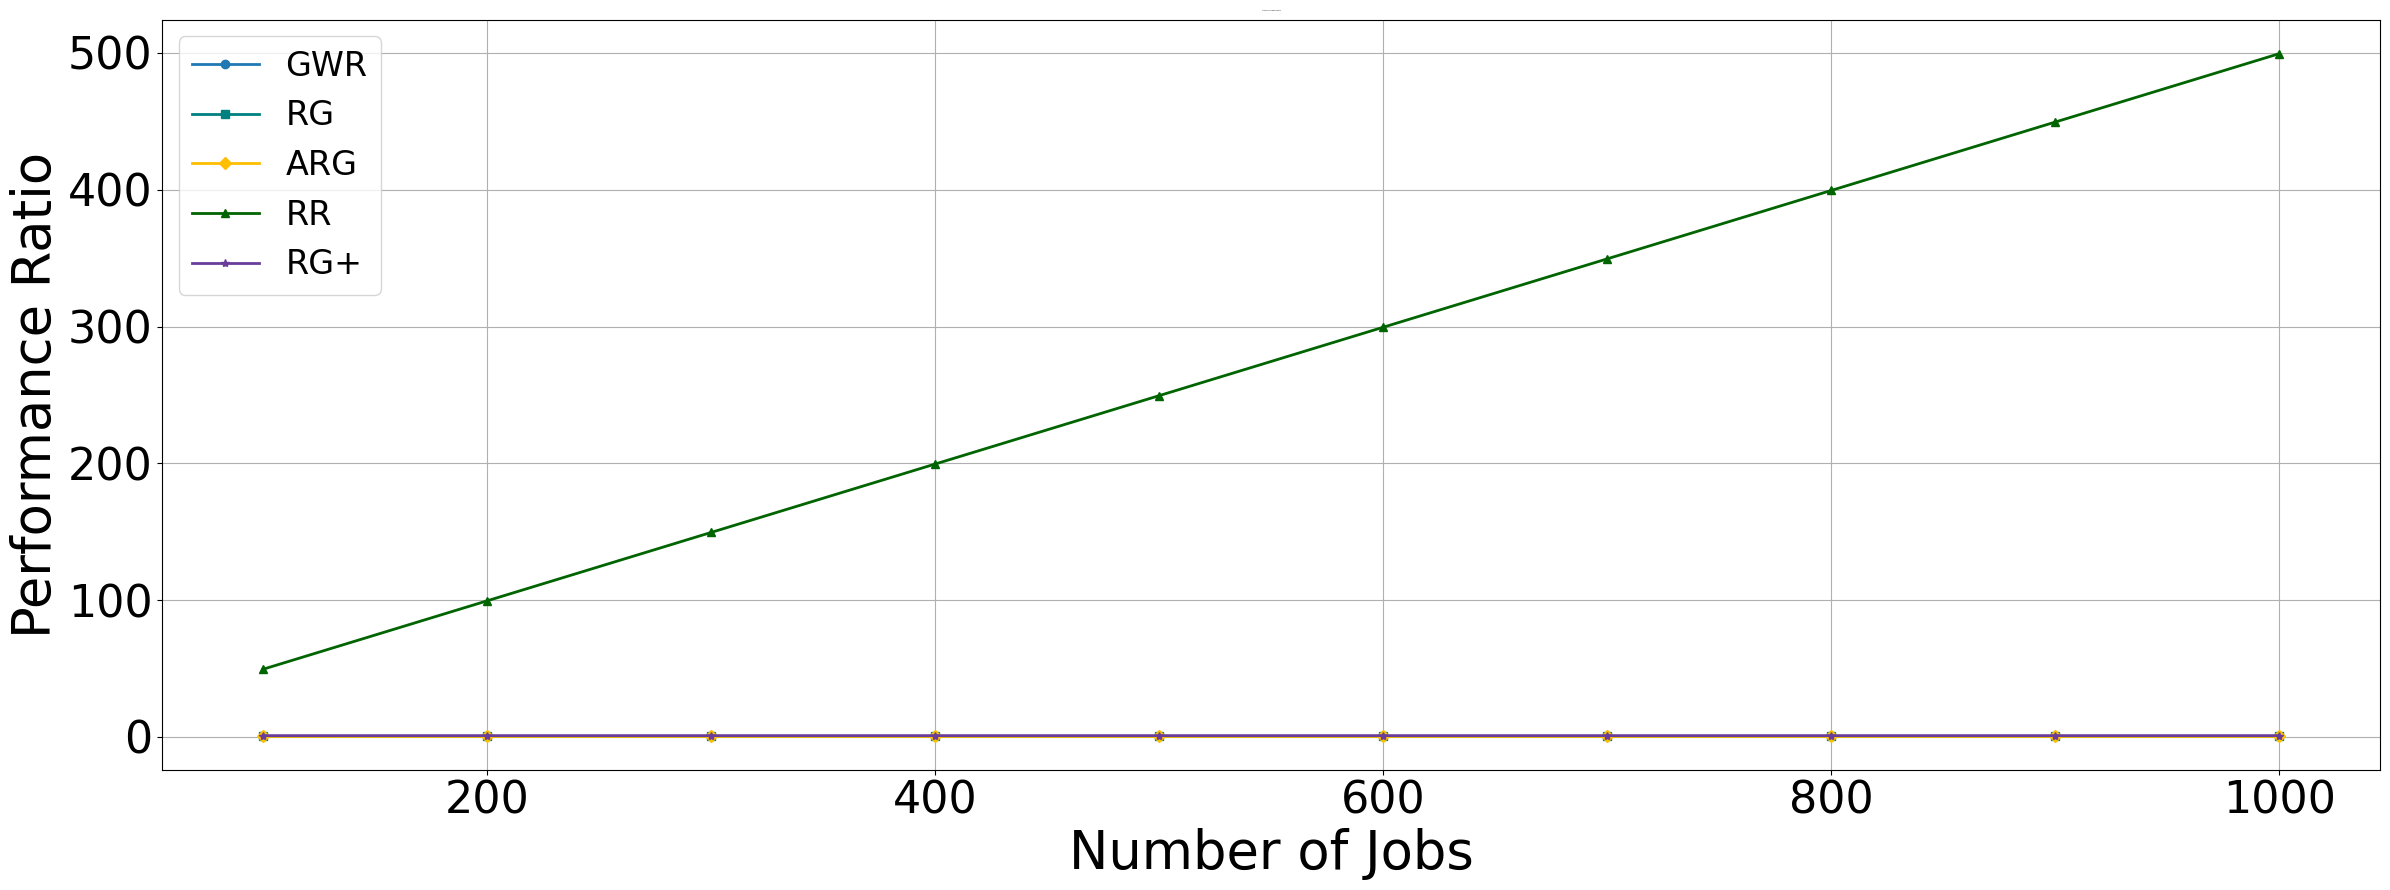

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

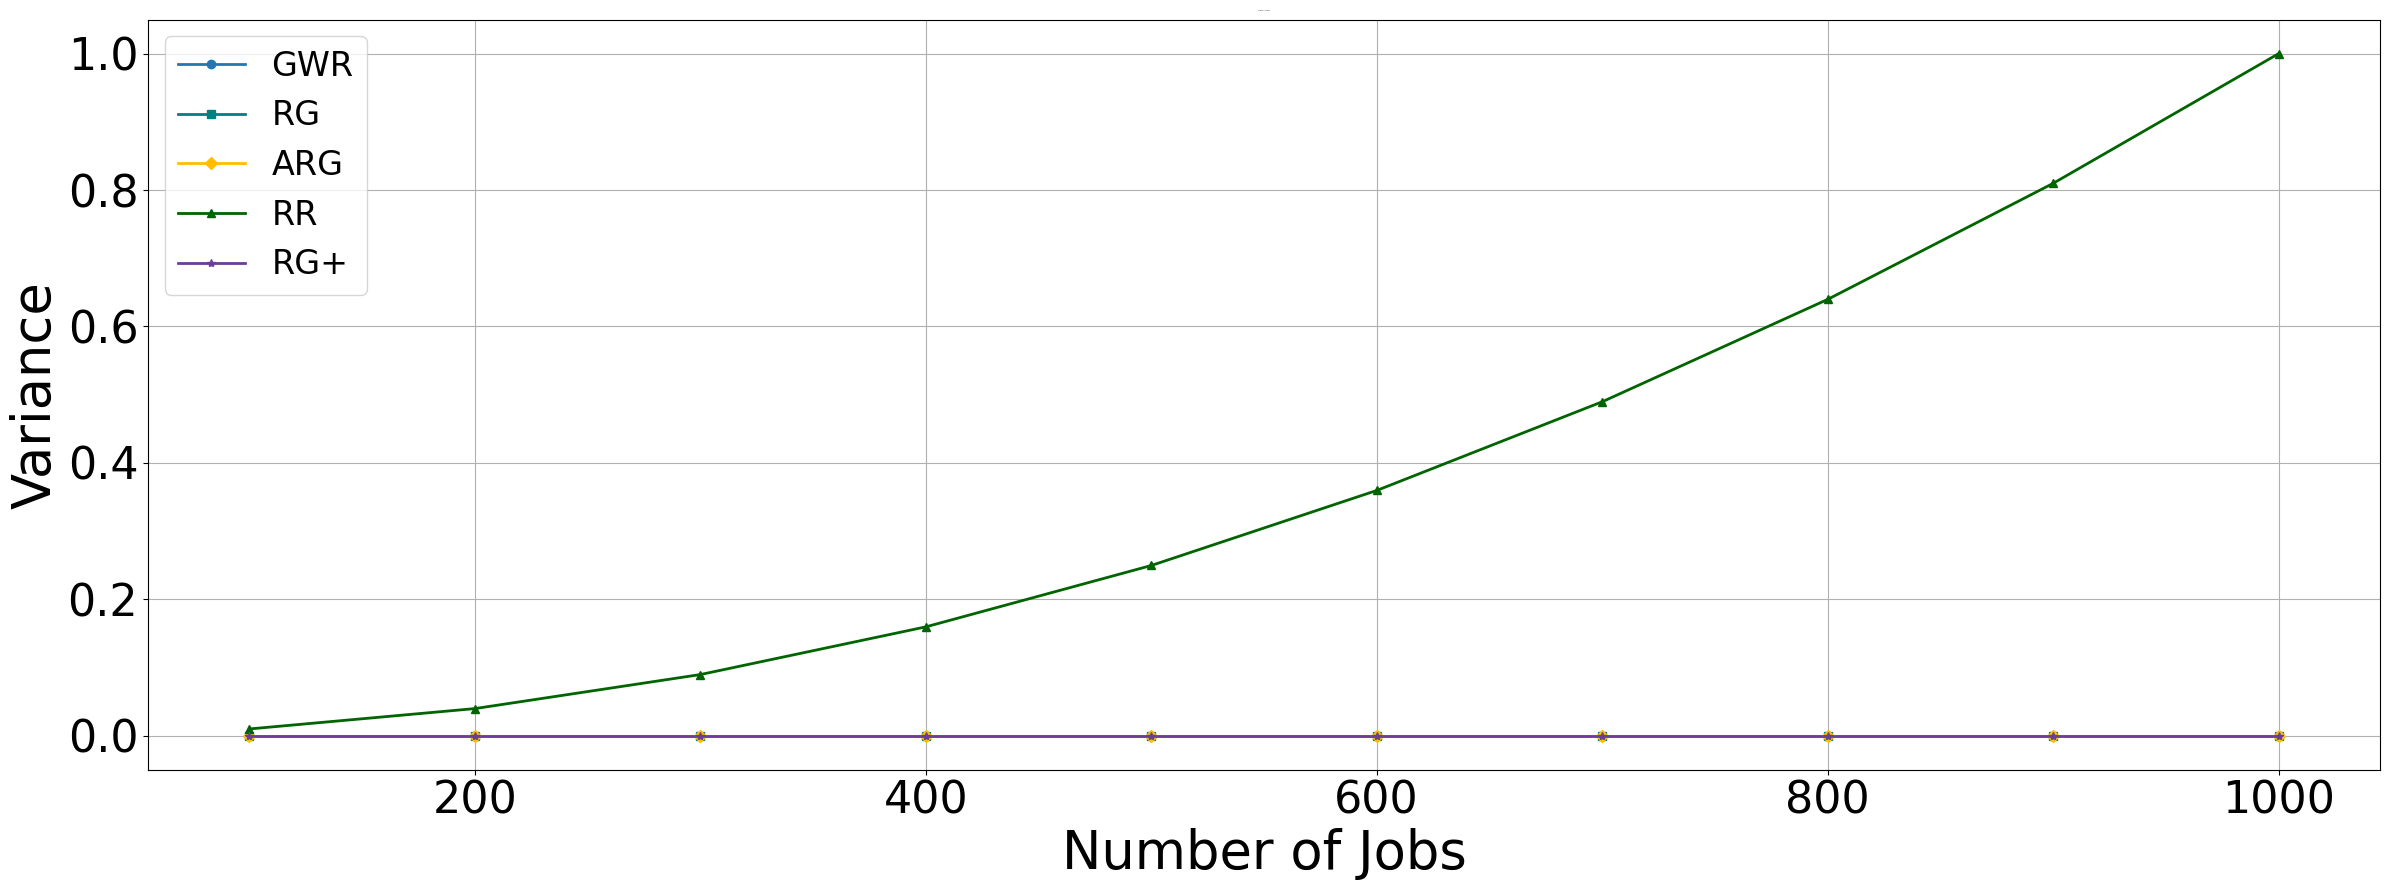

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

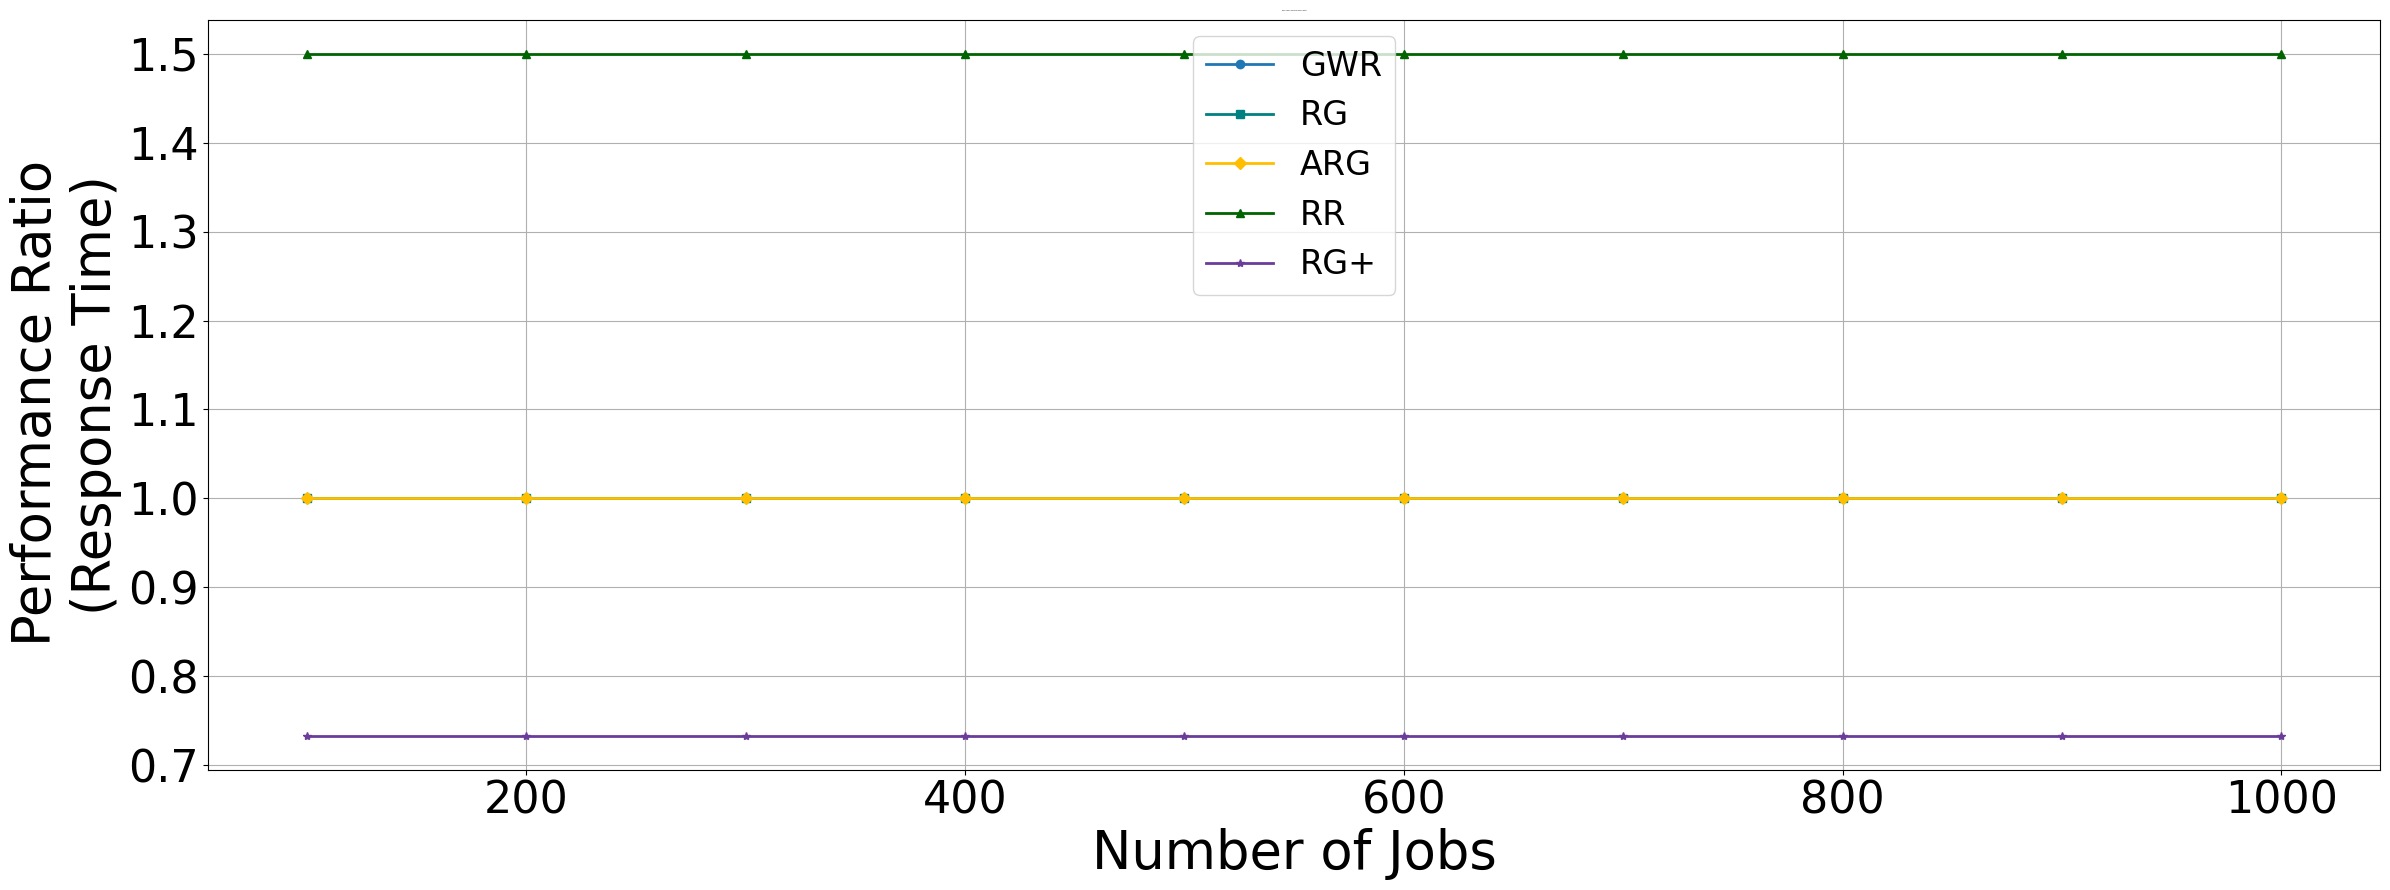

In [ ]:
WorstJobs=[100,200,300,400,500,600,700,800,900,1000]
worst_line_data(WorstJobs,1,0.5)

Random Case with Increasing Job Size
Perfect Prediction

NameError: name 'title' is not defined

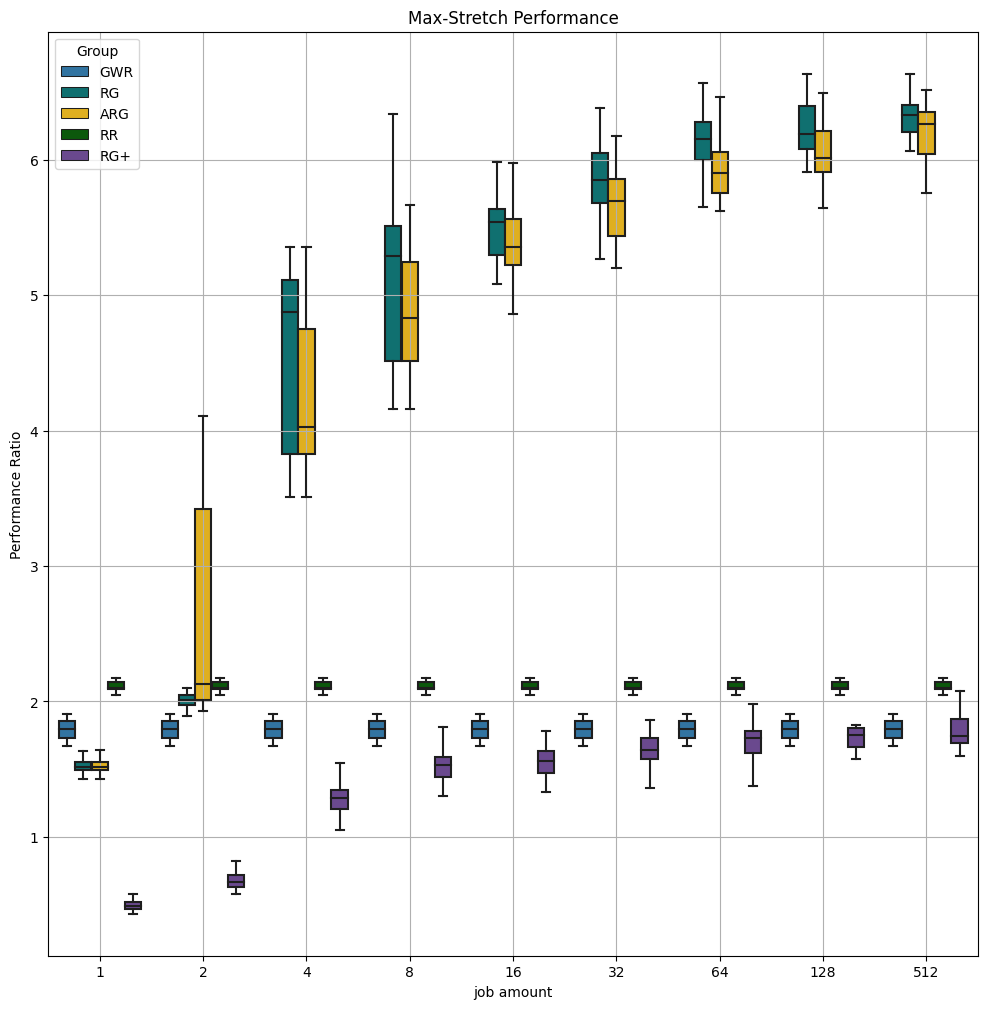

In [ ]:
s_df = pd.DataFrame(S1_Data)
draw_seaborn_box_plot(s_df,"Max-Stretch Performance","job amount","Performance Ratio")
draw_error_bar(s_df,"Max-Stretch Performance","job amount","Performance Ratio")

In [ ]:
def generate_boxplots(data_pairs, y_label, title, colors=['#1F78B4', '#008080', '#FFBF00', '#006400', '#6A3D9A']):
    fig, ax = plt.subplots()

    # Unpack the data pairs into names and data for boxplotting
    names, data = zip(*data_pairs)

    # Create boxplot
    bplot = ax.boxplot(data, patch_artist=True)

    # Color the boxes
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

    # Set x-axis labels
    ax.set_xticklabels(names, rotation=45, fontsize=28)

    # Set y-axis label
    ax.set_ylabel(y_label, fontsize=28)

    # Increase font size of y-axis tick labels
    ax.tick_params(axis='y', labelsize=22)

    # Add a title to the plot
    ax.set_title(title)

    # Show grid lines for better readability
    ax.yaxis.grid(True)

    # Display the plot
    plt.grid(True)
    plt.tight_layout()  # Adjust layout to prevent label cutoff
    filename = f"{y_label}.pdf"
    plt.savefig(filename, format='pdf', bbox_inches='tight')
    files.download(filename)  # Uncomment this line if you are using Google Colab
    plt.show()

Performance ratio
[('GWR', [3.5, 6.0, 5.0, 7.0, 2.5, 6.0, 7.0, 7.0, 6.0, 6.0, 5.0, 6.0, 7.0, 7.0, 7.0, 9.0, 6.0, 3.0, 7.0, 5.0, 6.0, 8.0, 6.0, 8.0, 7.0, 7.0, 6.0, 2.5, 6.0, 7.0, 5.0, 5.0, 4.0, 9.0, 7.0, 7.0, 6.0, 6.0, 7.0, 6.0, 6.0, 7.0, 6.0, 7.0, 7.0, 5.0, 6.0, 7.0, 11.0, 6.0]), ('RG', [3.0, 5.0, 5.0, 7.0, 2.0, 7.5, 7.0, 5.5, 6.0, 6.0, 5.0, 5.0, 6.0, 5.5, 7.0, 9.0, 6.0, 3.0, 6.5, 6.0, 8.5, 7.0, 6.0, 6.5, 6.0, 7.0, 5.0, 2.5, 6.0, 5.0, 5.0, 5.0, 3.0, 8.0, 6.0, 7.0, 6.0, 6.0, 8.0, 5.5, 5.0, 6.0, 6.0, 7.0, 5.0, 5.0, 6.0, 5.0, 6.5, 6.0]), ('ARG', [3.0, 5.0, 5.0, 7.0, 2.0, 7.5, 7.0, 5.5, 6.0, 6.0, 5.0, 5.0, 6.0, 5.5, 7.0, 9.0, 6.0, 3.0, 6.5, 6.0, 8.5, 7.0, 6.0, 6.5, 6.0, 7.0, 5.0, 2.5, 6.0, 5.0, 5.0, 5.0, 3.0, 8.0, 6.0, 7.0, 6.0, 6.0, 8.0, 5.5, 5.0, 6.0, 6.0, 7.0, 5.0, 5.0, 6.0, 5.0, 6.5, 6.0]), ('RR', [2.4375, 4.900000000000091, 5.116666666666788, 5.633333333333667, 2.125, 5.153333333332739, 6.875, 6.5166666666666515, 5.044444444444707, 4.5, 4.25, 3.833333333333485, 6.807870370370438, 7.04

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

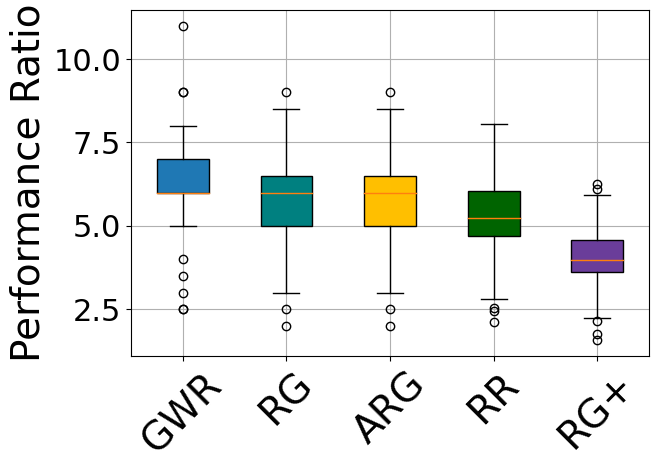

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

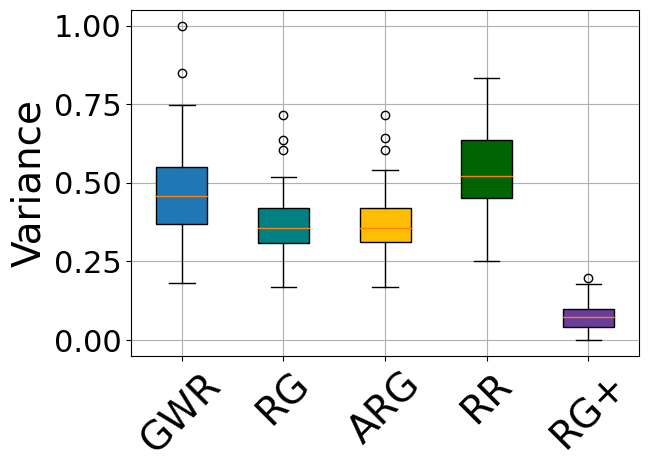

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

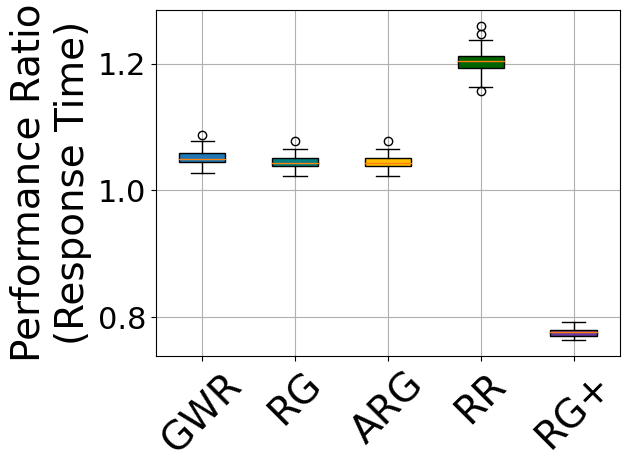

In [ ]:
BatchSet=generateBatchLogJob(0,5000,1,1000,1,50)
batch_test(BatchSet,1,0.3)
#GROUP1

Performance ratio
[('GWR', [6.5, 20.0, 12.0, 12.0, 14.0, 13.0, 10.0, 4.333333333333333, 5.5, 6.0, 12.0, 10.0, 12.0, 3.0, 10.333333333333334, 11.0, 7.0, 4.25, 17.0, 4.0, 12.0, 13.0, 10.0, 4.0, 4.333333333333333, 12.0, 13.0, 13.0, 14.0, 16.0, 11.0, 13.0, 14.0, 13.0, 10.0, 4.333333333333333, 12.0, 14.0, 4.333333333333333, 11.0, 3.3333333333333335, 5.0, 15.0, 17.0, 12.0, 18.0, 14.0, 11.0, 5.5, 17.0]), ('RG', [6.5, 14.5, 12.0, 10.0, 10.5, 11.0, 10.0, 3.6666666666666665, 4.5, 4.5, 9.0, 8.5, 10.5, 3.0, 12.0, 9.5, 6.75, 2.75, 17.5, 3.3333333333333335, 8.0, 12.5, 9.5, 3.0, 3.6666666666666665, 13.5, 12.0, 11.5, 11.0, 16.5, 10.5, 10.0, 14.5, 10.5, 8.0, 4.0, 11.5, 16.5, 3.8333333333333335, 11.5, 2.3333333333333335, 5.0, 15.0, 10.0, 8.0, 16.0, 11.5, 11.0, 6.0, 11.5]), ('ARG', [6.5, 14.5, 12.0, 10.0, 10.5, 11.0, 10.0, 3.6666666666666665, 4.5, 4.5, 9.0, 8.5, 10.5, 3.0, 12.0, 9.5, 6.75, 2.75, 17.5, 3.3333333333333335, 8.0, 12.5, 9.5, 3.0, 3.6666666666666665, 13.5, 12.0, 11.5, 12.0, 16.5, 10.5, 10.0, 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

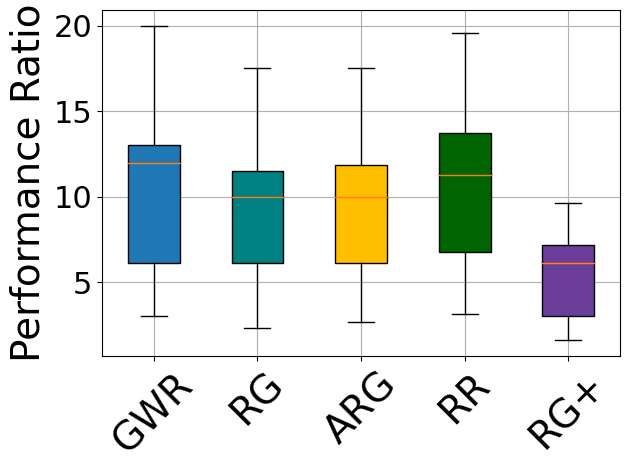

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

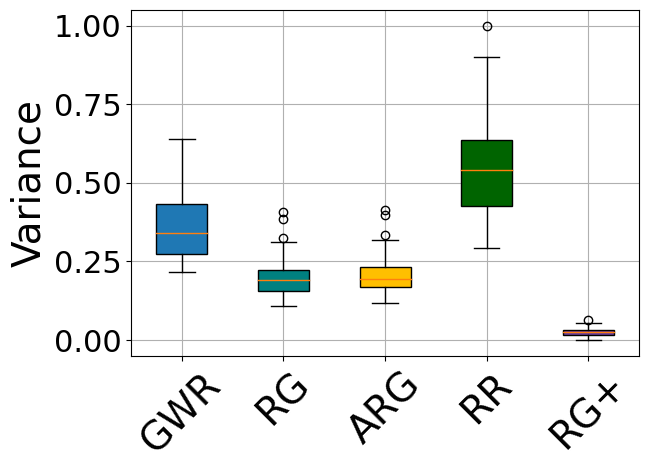

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

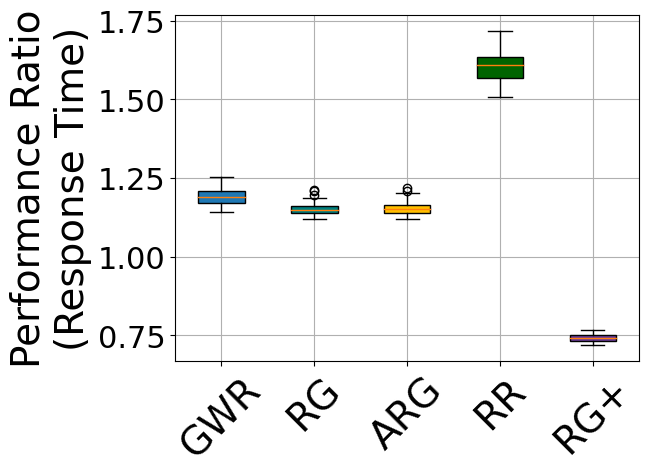

In [ ]:
BatchSet=generateBatchLogJob(0,5000,1,2000,1,50)
batch_test(BatchSet,1,0.3)


Performance ratio
[('GWR', [5.333333333333333, 1.7, 15.0, 8.363636363636363, 41.0, 3.4444444444444446, 34.5, 33.0, 3.6818181818181817, 4.583333333333333, 6.666666666666667, 3.7142857142857144, 18.0, 12.666666666666666, 4.625, 3.1666666666666665, 32.5, 1.9428571428571428, 36.0, 10.8, 2.35, 46.0, 6.6, 3.75, 9.666666666666666, 2.409090909090909, 4.846153846153846, 3.0, 4.1, 2.6, 40.0, 4.777777777777778, 21.0, 2.8, 7.111111111111111, 55.0, 7.0, 5.833333333333333, 7.285714285714286, 5.636363636363637, 31.0, 6.0, 8.555555555555555, 1.7142857142857142, 7.428571428571429, 3.2, 10.75, 10.0, 33.0, 3.5]), ('RG', [5.0, 1.9, 16.0, 7.545454545454546, 50.0, 4.111111111111111, 29.25, 38.25, 3.590909090909091, 3.9583333333333335, 6.583333333333333, 3.0, 19.666666666666668, 12.75, 4.28125, 3.5, 26.25, 1.5714285714285714, 37.5, 11.9, 2.775, 48.5, 6.3, 3.2916666666666665, 10.0, 2.409090909090909, 5.269230769230769, 2.840909090909091, 4.2, 2.566666666666667, 41.0, 4.388888888888889, 23.5, 2.133333333333333

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

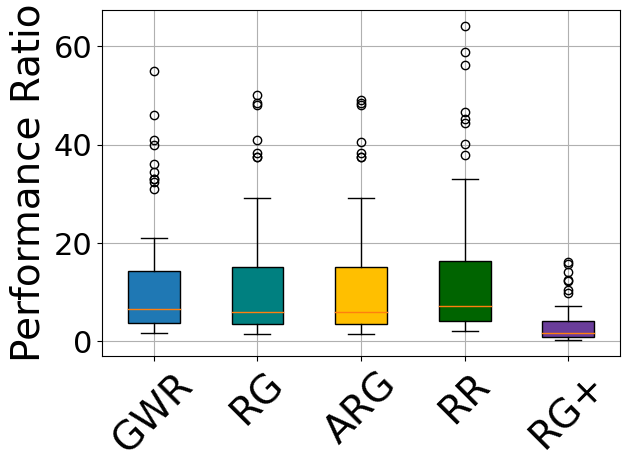

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

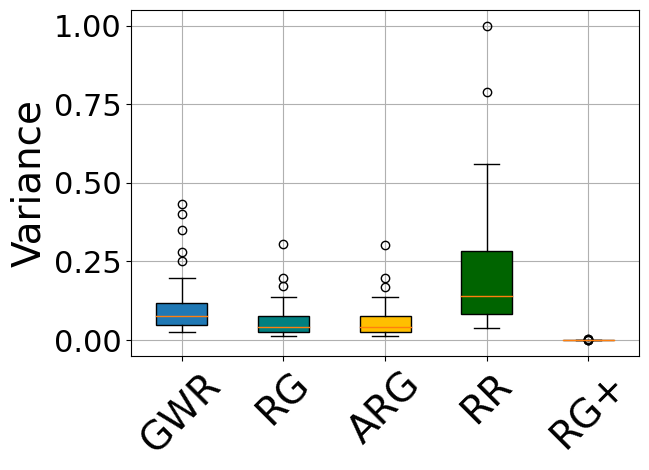

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

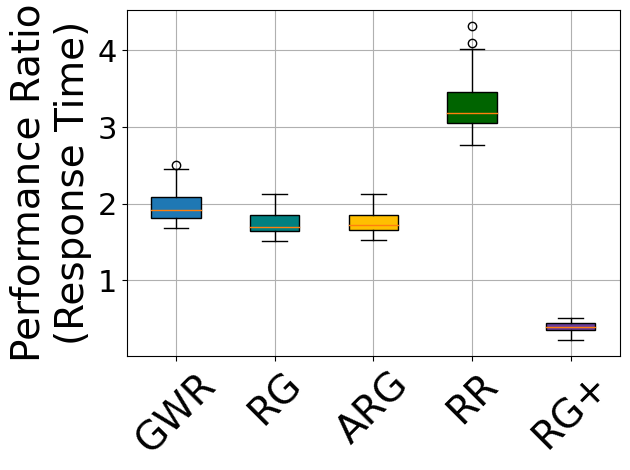

In [ ]:
BatchSet=generateBatchLogJob(0,5000,1,3000,1,50)
batch_test(BatchSet,1,0.3)


Performance ratio
[('GWR', [1.7754716981132075, 1.7274401473296501, 1.5249569707401032, 1.4929577464788732, 1.4835164835164836, 1.8676748582230625, 1.7176684881602915, 1.8342644320297952, 1.6962699822380107, 1.7607573149741824, 1.496309963099631, 1.8223443223443223, 1.7380952380952381, 1.7754318618042226, 1.868421052631579, 1.7338403041825095, 1.468864468864469, 1.6819012797074955, 1.845217391304348, 1.8232142857142857, 1.4369114877589453, 1.4765478424015008, 1.6654804270462633, 1.7760141093474426, 1.8552875695732838, 1.8669064748201438, 1.7122557726465364, 1.7541589648798521, 1.446927374301676, 1.843984962406015, 1.7673992673992673, 1.3891797556719023, 1.3520871143375681, 1.3918918918918919, 1.7028469750889679, 1.7843866171003717, 1.4192439862542956, 1.8266423357664234, 1.785063752276867, 1.6829268292682926, 1.5009174311926605, 1.4106194690265488, 1.8330241187384044, 1.775831873905429, 1.4554079696394686, 1.7961538461538462, 1.7844202898550725, 1.779270633397313, 1.7545787545787546, 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

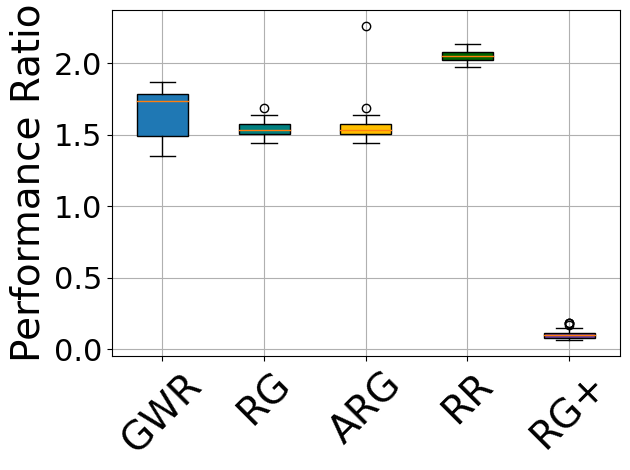

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

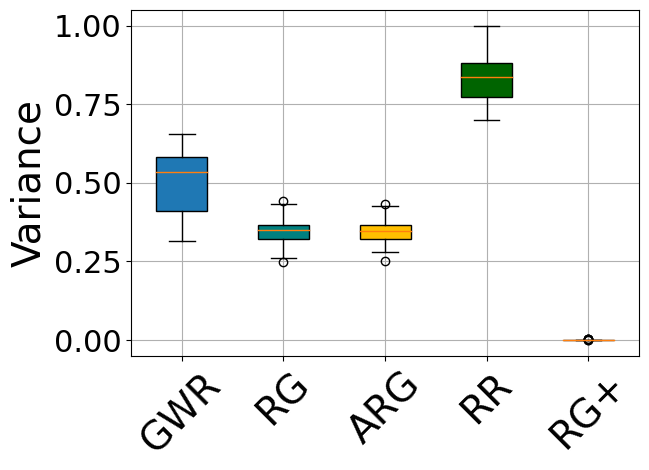

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

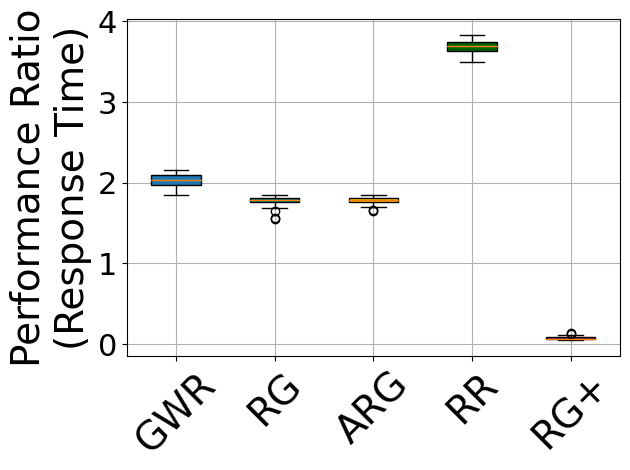

In [ ]:
BatchSet=generateBatchLogJob(0,5000,1,4000,1,50)
batch_test(BatchSet,1,0.3)


Performance ratio
[('GWR', [1.8830297219558965, 1.8711832061068703, 1.4396551724137931, 1.828080229226361, 1.8357487922705313, 1.457674418604651, 1.8900473933649289, 1.9044465468306528, 1.8898385565052231, 1.47675568743818, 1.90205680705191, 1.8476190476190477, 1.9334619093539056, 1.9447186574531097, 1.458955223880597, 1.9217391304347826, 1.499031007751938, 1.8910614525139664, 1.5037735849056604, 1.8434442270058709, 1.8819119025304591, 1.4669187145557656, 1.8050682261208577, 1.8937381404174574, 1.9761194029850746, 1.9159584513692163, 1.9130434782608696, 1.8888888888888888, 1.8929889298892988, 1.961689587426326, 1.882865440464666, 1.4842707340324117, 1.7774647887323944, 1.8748815165876778, 1.8310546875, 1.8582020389249305, 1.5054187192118227, 1.92578125, 1.8996062992125984, 1.873405299313052, 1.9306083650190113, 2.0283553875236295, 1.8708765315739868, 1.4995196926032661, 1.7891156462585034, 1.908153701968135, 1.8975845410628018, 1.9216061185468452, 1.8971428571428572, 1.89413988657845])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

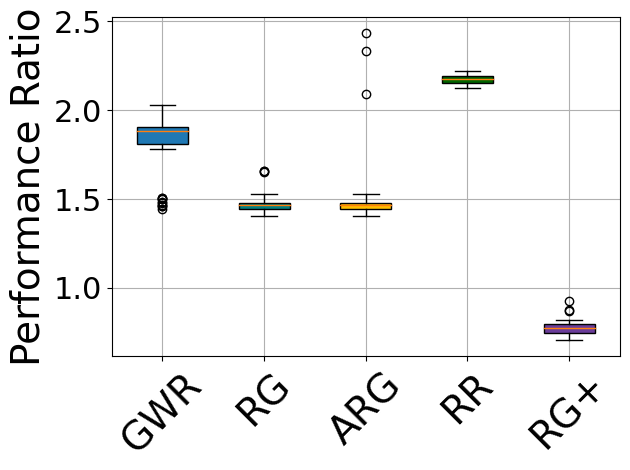

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

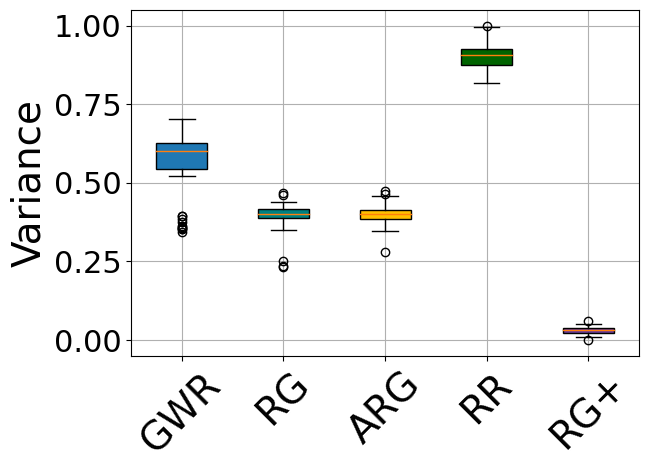

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

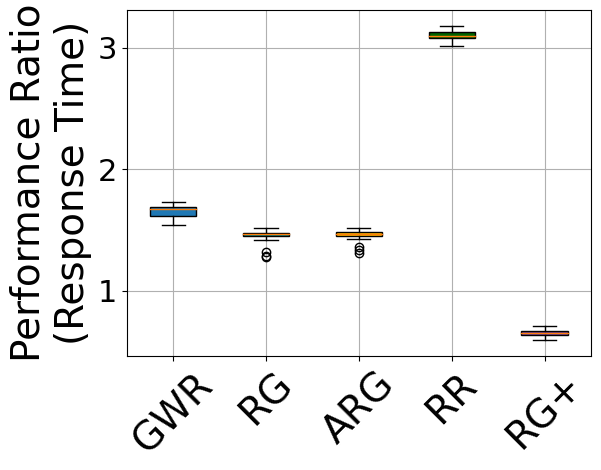

In [ ]:
BatchSet=generateBatchLogJob(0,5000,1,5000,1,50)
batch_test(BatchSet,1,0.3)


Performance ratio
[('GWR', [2.5161479741632413, 2.499558693733451, 2.475520375256523, 2.5108663292646622, 2.543154761904762, 2.5045601647543396, 2.5160246986180534, 2.508905109489051, 2.479870702321481, 2.51905041031653, 2.49573403942336, 2.5342992312241277, 2.5194957490472003, 2.520624631703005, 2.5427728613569323, 2.522957662492546, 2.524397413286302, 2.5026690391459074, 2.5077781039037275, 2.5379411764705884]), ('RG', [1.6089254257193188, 1.5884083553986466, 1.5768103195543828, 1.761536171479607, 1.6096726190476192, 1.5835539864666077, 1.5715965892384594, 1.6096350364963503, 1.5659712018806935, 1.5814771395076201, 1.5789938217122683, 1.6060023654642224, 1.584286133098798, 1.5894225103123159, 1.5870206489675516, 1.6238819320214668, 1.5983245149911816, 1.6055753262158956, 1.5864396830055767, 1.6139705882352942]), ('ARG', [1.6089254257193188, 1.8620182406590173, 1.5768103195543828, 1.6049419470080382, 1.6096726190476192, 1.5835539864666077, 1.5715965892384594, 1.6096350364963503, 1.565

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

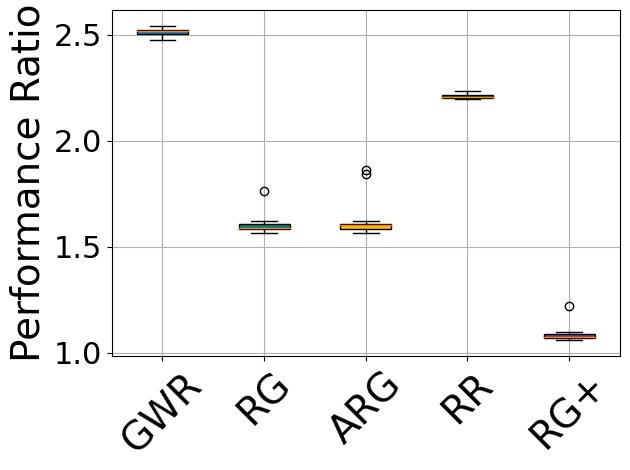

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

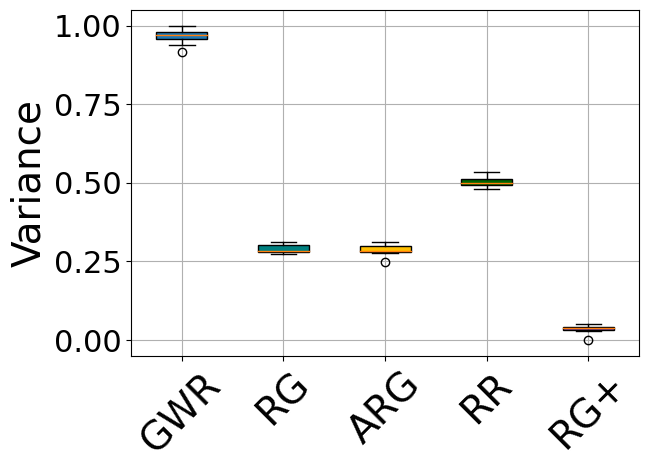

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

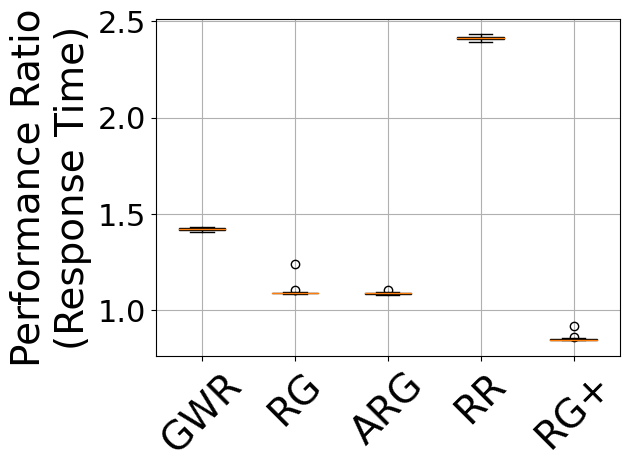

In [ ]:
BatchSet=generateBatchLogJob(0,5000,1,10000,1,20)
batch_test(BatchSet,1,0.3)

<ipython-input-28-5ec30bccd189>:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_values = group_df.groupby('X_mapped').median()['Value']
<ipython-input-28-5ec30bccd189>:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_values = group_df.groupby('X_mapped').median()['Value']
<ipython-input-28-5ec30bccd189>:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_values = group_df.groupby('X_mapped'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

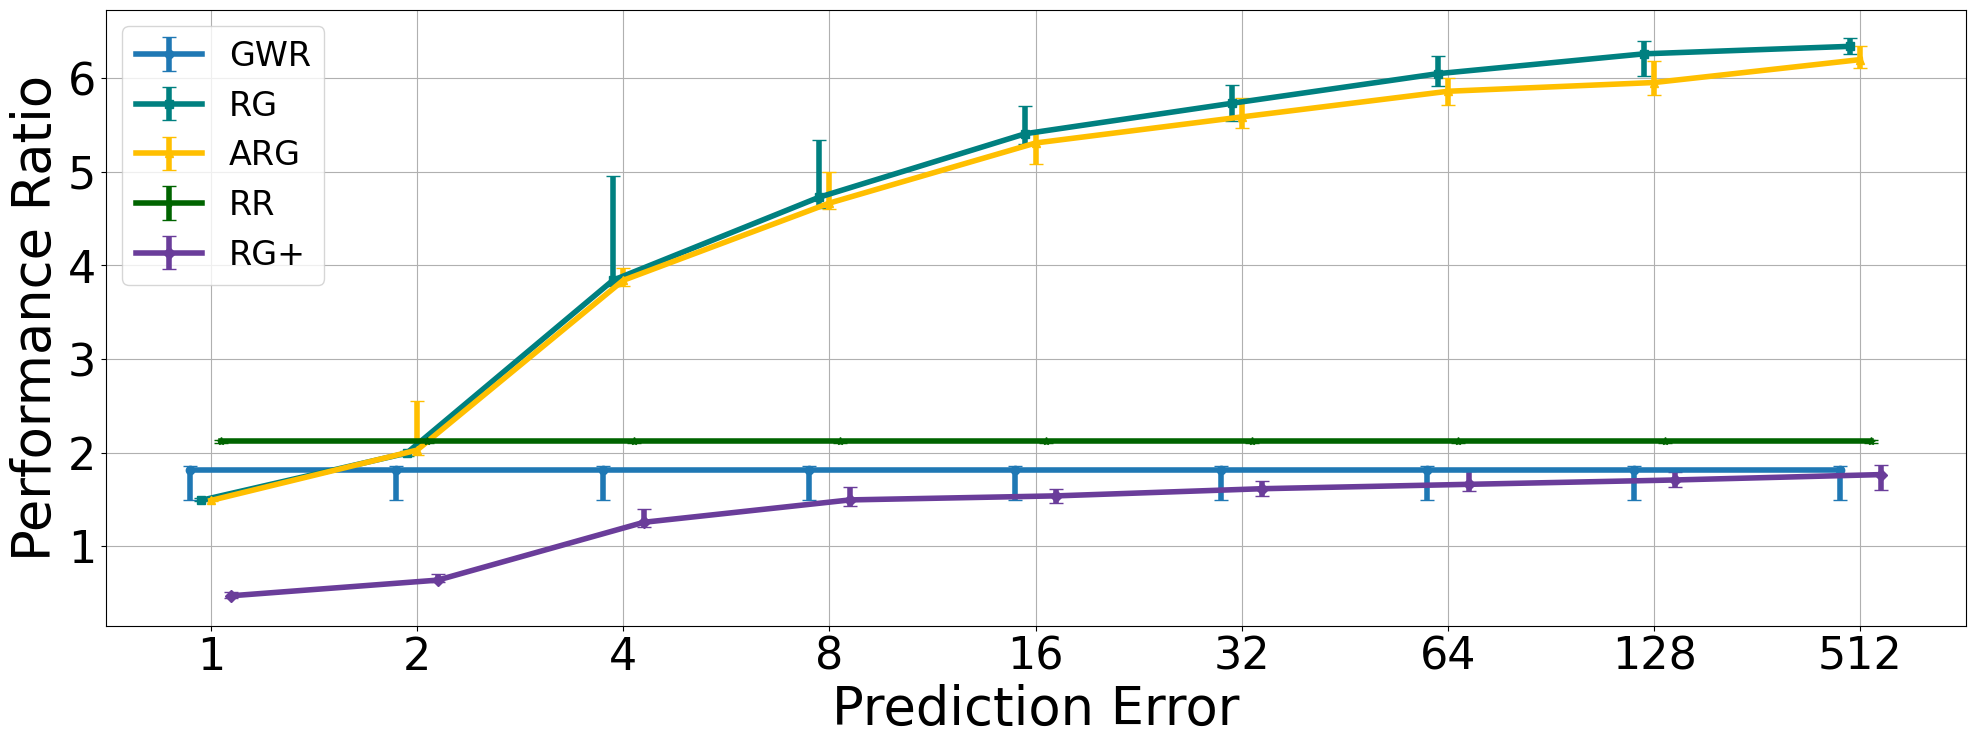

In [ ]:
S1_Data,V1_Data,R1_Data=[],[],[]
BatchSet=generateBatchLogJob(0,5000,1,4500,1,20)
batch_record(1,S1_Data,V1_Data,R1_Data,BatchSet,1,0.3)
BatchSet=update_pre_err(BatchSet,2)
batch_record(2,S1_Data,V1_Data,R1_Data,BatchSet,1,0.3)
BatchSet=update_pre_err(BatchSet,4)
batch_record(4,S1_Data,V1_Data,R1_Data,BatchSet,1,0.3)
BatchSet=update_pre_err(BatchSet,8)
batch_record(8,S1_Data,V1_Data,R1_Data,BatchSet,1,0.3)
BatchSet=update_pre_err(BatchSet,16)
batch_record(16,S1_Data,V1_Data,R1_Data,BatchSet,1,0.3)
BatchSet=update_pre_err(BatchSet,32)
batch_record(32,S1_Data,V1_Data,R1_Data,BatchSet,1,0.3)
BatchSet=update_pre_err(BatchSet,64)
batch_record(64,S1_Data,V1_Data,R1_Data,BatchSet,1,0.3)
BatchSet=update_pre_err(BatchSet,128)
batch_record(128,S1_Data,V1_Data,R1_Data,BatchSet,1,0.3)
BatchSet=update_pre_err(BatchSet,512)
batch_record(512,S1_Data,V1_Data,R1_Data,BatchSet,1,0.3)
from sklearn.preprocessing import MinMaxScaler

s_df = pd.DataFrame(S1_Data)
draw_error_bar(s_df,"Max-Stretch Performance","Prediction Error","Performance Ratio")

In [ ]:
S1_Data,V1_Data,R1_Data=[],[],[]
BatchSet=generateBatchLogJob(0,5000,1,4500,1,20)
batch_record(1,S1_Data,V1_Data,R1_Data,BatchSet,1,0.3)
BatchSet=update_pre_err(BatchSet,2)
batch_record(2,S1_Data,V1_Data,R1_Data,BatchSet,1,0.3)
BatchSet=update_pre_err(BatchSet,4)
batch_record(4,S1_Data,V1_Data,R1_Data,BatchSet,1,0.3)
BatchSet=update_pre_err(BatchSet,8)
batch_record(8,S1_Data,V1_Data,R1_Data,BatchSet,1,0.3)
BatchSet=update_pre_err(BatchSet,16)
batch_record(16,S1_Data,V1_Data,R1_Data,BatchSet,1,0.3)
BatchSet=update_pre_err(BatchSet,32)
batch_record(32,S1_Data,V1_Data,R1_Data,BatchSet,1,0.3)
BatchSet=update_pre_err(BatchSet,64)
batch_record(64,S1_Data,V1_Data,R1_Data,BatchSet,1,0.3)
BatchSet=update_pre_err(BatchSet,128)
batch_record(128,S1_Data,V1_Data,R1_Data,BatchSet,1,0.3)
BatchSet=update_pre_err(BatchSet,512)
batch_record(512,S1_Data,V1_Data,R1_Data,BatchSet,1,0.3)



<ipython-input-67-34e92054d5f7>:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_values = group_df.groupby('X_mapped').median()['Value']
<ipython-input-67-34e92054d5f7>:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_values = group_df.groupby('X_mapped').median()['Value']
<ipython-input-67-34e92054d5f7>:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_values = group_df.groupby('X_mapped'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

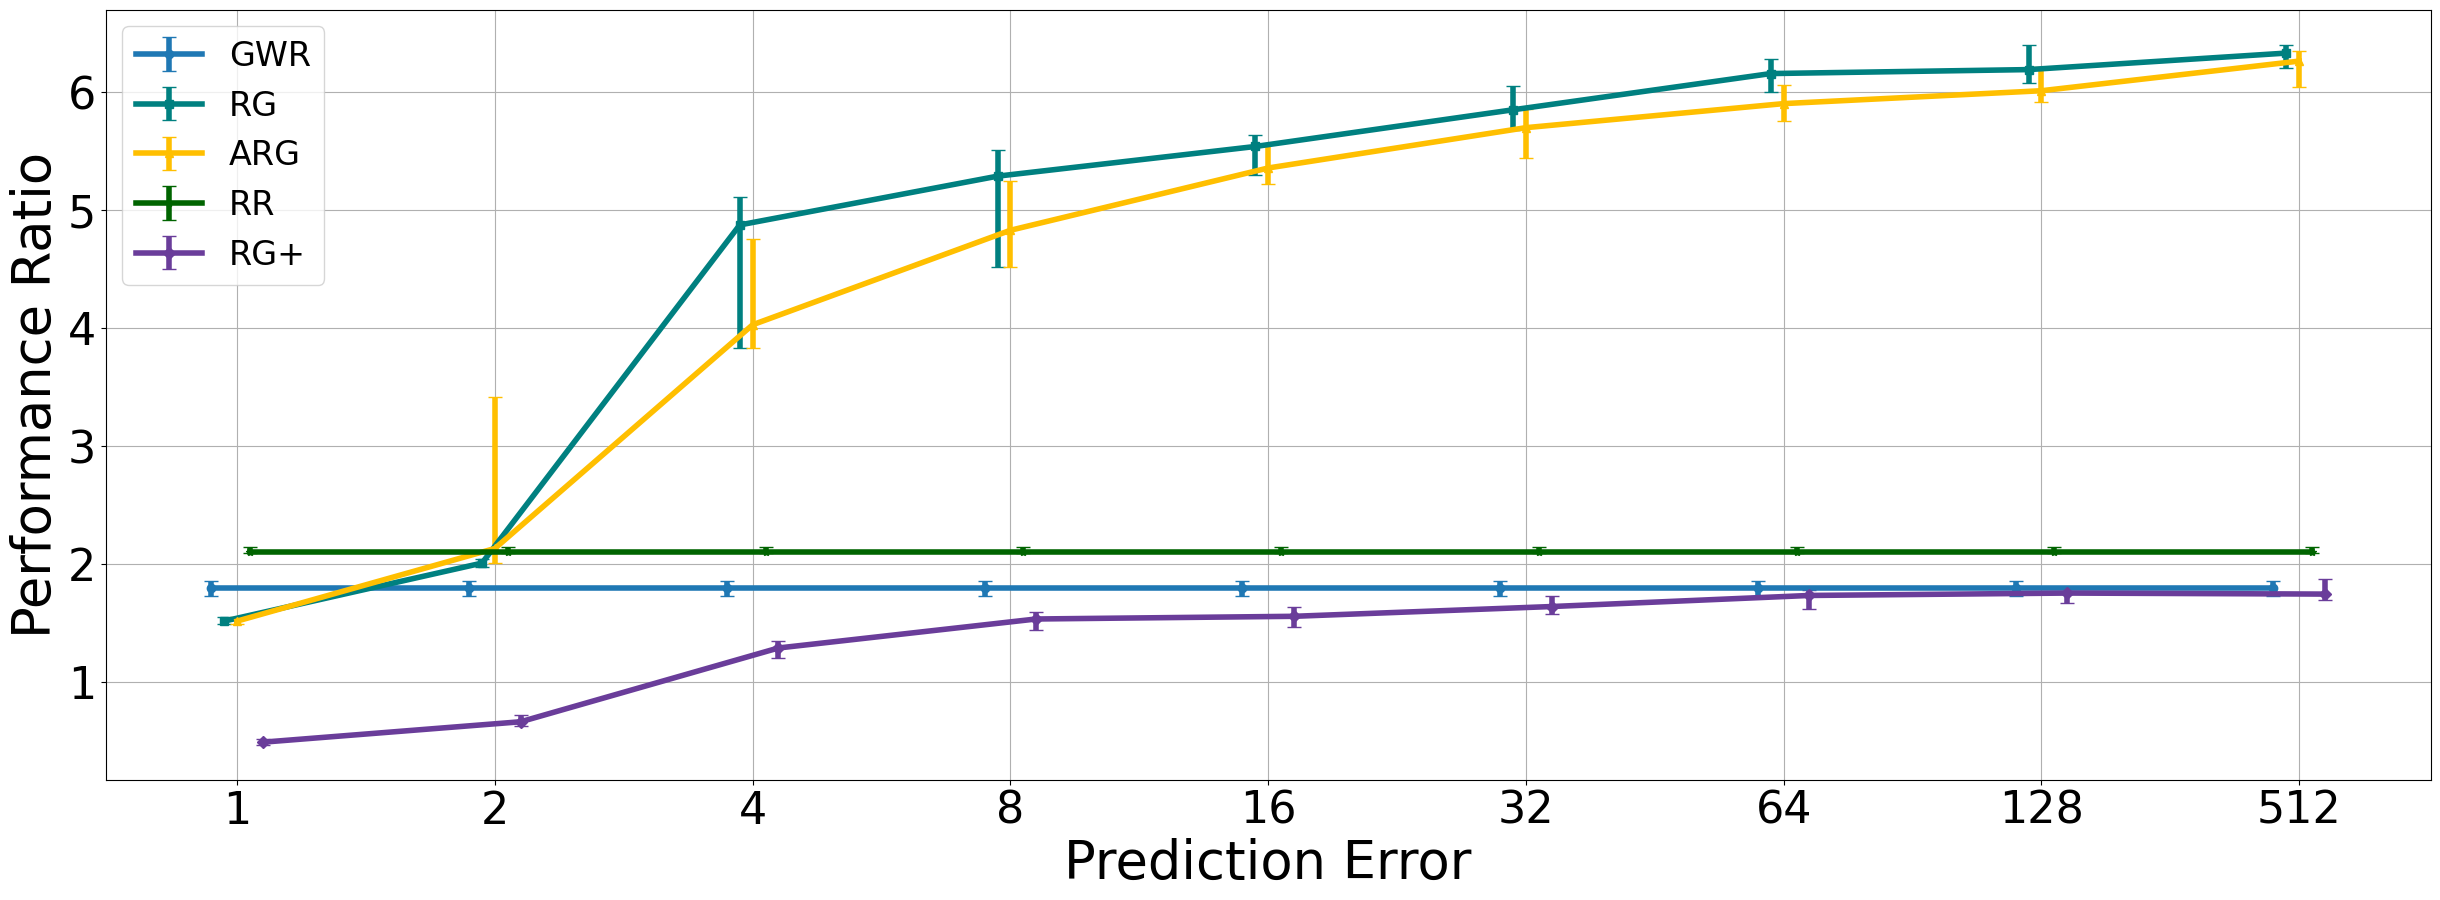

In [ ]:
from sklearn.preprocessing import MinMaxScaler

s_df = pd.DataFrame(S1_Data)
draw_error_bar(s_df,"Max-Stretch Performance","Prediction Error","Performance Ratio")

<ipython-input-67-34e92054d5f7>:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_values = group_df.groupby('X_mapped').median()['Value']
<ipython-input-67-34e92054d5f7>:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_values = group_df.groupby('X_mapped').median()['Value']
<ipython-input-67-34e92054d5f7>:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_values = group_df.groupby('X_mapped'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

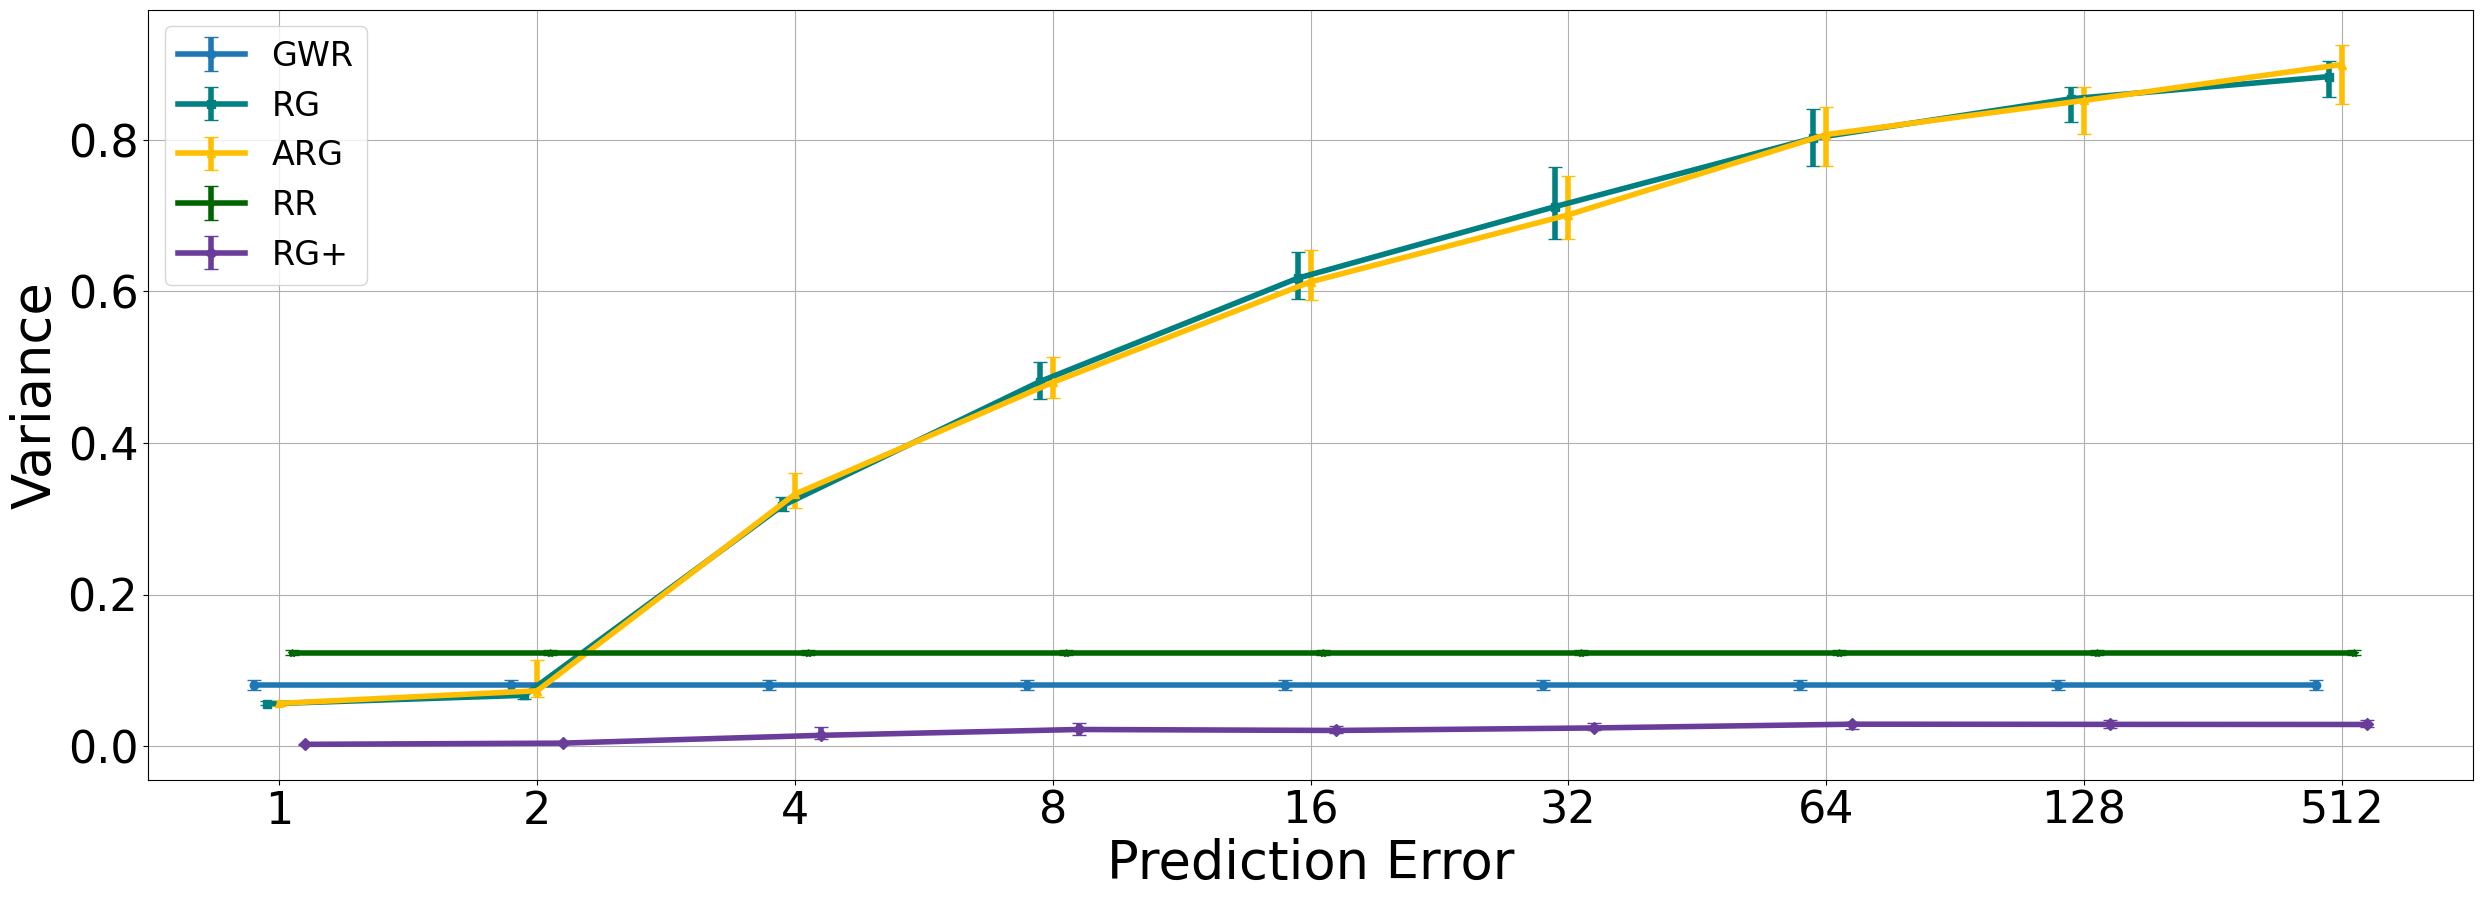

In [ ]:
v_df = pd.DataFrame(V1_Data)
scaler = MinMaxScaler()
v_df["Value"] = scaler.fit_transform(v_df[["Value"]])
draw_error_bar(v_df,"Variance","Prediction Error","Variance")

In [ ]:
r_df = pd.DataFrame(R1_Data)
draw_error_bar(r_df,"Average Response Time","Prediction Error","Performance Ratio \n(Response Time)")

NameError: name 'pd' is not defined

In [ ]:
--------------------------------------

Performance ratio
[('GWR', [1.0, 1.005940594059406, 1.0078895463510849, 1.0, 1.001984126984127, 1.00990099009901, 1.0134357005758157, 1.0, 1.0119284294234592, 1.0, 1.001984126984127, 1.0239520958083832, 1.0, 1.0, 1.0, 1.0019646365422397, 1.007920792079208, 1.0, 1.0099206349206349, 1.0179640718562875, 1.0198019801980198, 1.0316205533596838, 1.0038910505836576, 1.0019880715705765, 1.0039525691699605, 1.0, 1.0058823529411764, 1.0, 1.0159362549800797, 1.0, 1.0337972166998013, 1.0, 1.007766990291262, 1.0019762845849802, 1.0139442231075697, 1.0, 1.0099403578528827, 1.0116504854368933, 1.001953125, 1.0039761431411531, 1.003960396039604, 1.033932135728543, 1.011881188118812, 1.0079840319361277, 1.0318091451292246, 1.0158102766798418, 1.0099403578528827, 1.0078740157480315, 1.00199203187251, 1.031936127744511]), ('RG', [1.0, 1.005940594059406, 1.0078895463510849, 1.0, 1.001984126984127, 1.00990099009901, 1.0134357005758157, 1.0, 1.0119284294234592, 1.0, 1.001984126984127, 1.0239520958083832, 1.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

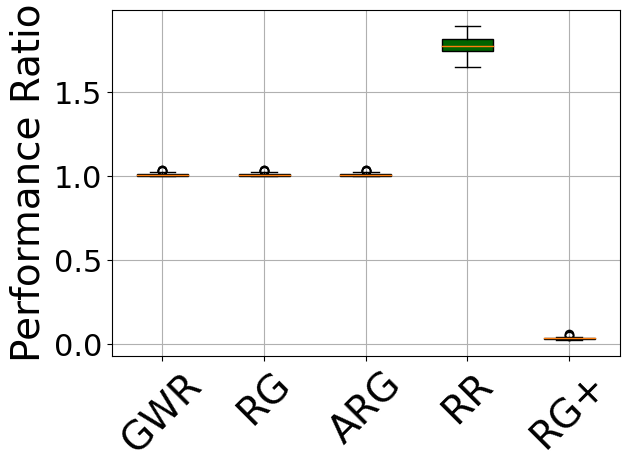

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

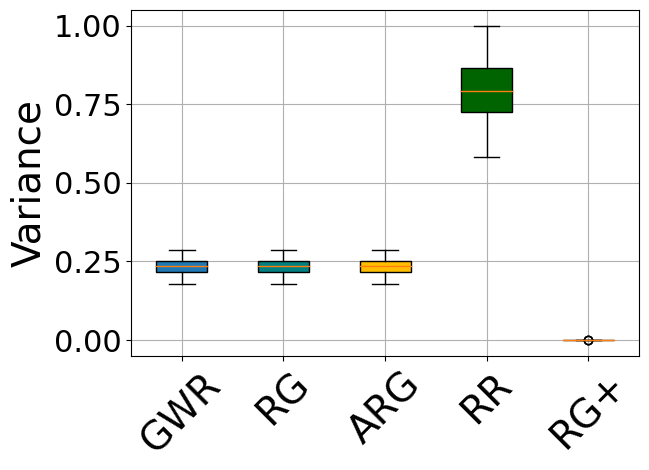

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

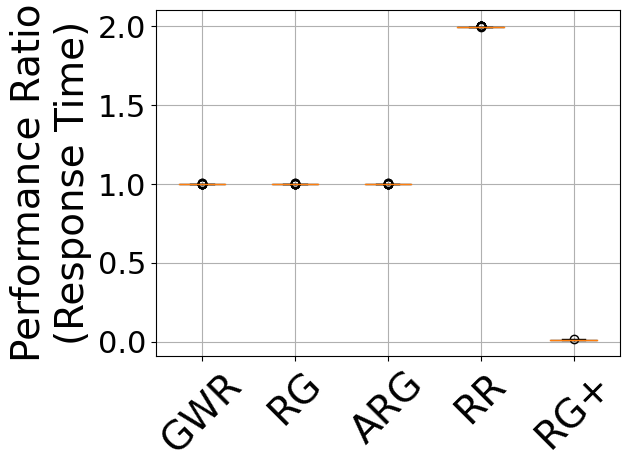

In [ ]:
BatchSet=generateBatchLogJob(0,5000,0.1,5000,1,50)
batch_test(BatchSet,1,0.3)

Performance ratio
[('GWR', [1.0365384615384616, 1.0130841121495326, 1.0170132325141776, 1.0092936802973977, 1.0, 1.005586592178771, 1.0150093808630394, 1.036190476190476, 1.0115830115830116, 1.0, 1.0133079847908746, 1.0096339113680155, 1.0171102661596958, 1.0242085661080074, 1.0306513409961686, 1.013157894736842, 1.013157894736842, 1.018552875695733, 1.0267686424474187, 1.0148423005565863, 1.0246679316888045, 1.0134099616858236, 1.0055970149253732, 1.009469696969697, 1.0169172932330828, 1.0264650283553876, 1.0264650283553876, 1.0075901328273245, 1.0114068441064639, 1.0093808630393997, 1.003690036900369, 1.00375234521576, 1.0055452865064696, 1.011070110701107, 1.0074906367041199, 1.0193798449612403, 1.011111111111111, 1.0114068441064639, 1.0095057034220531, 1.005703422053232, 1.0224299065420561, 1.0075046904315197, 1.0112994350282485, 1.0, 1.0246212121212122, 1.0111524163568772, 1.0093632958801497, 1.0111940298507462, 1.0279329608938548, 1.0416666666666667]), ('RG', [1.0403846153846155,

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

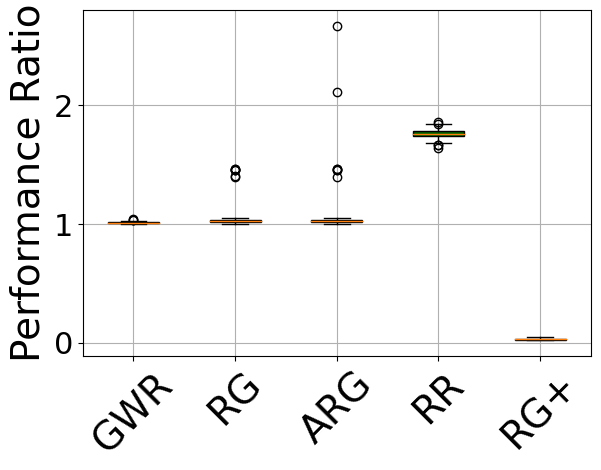

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

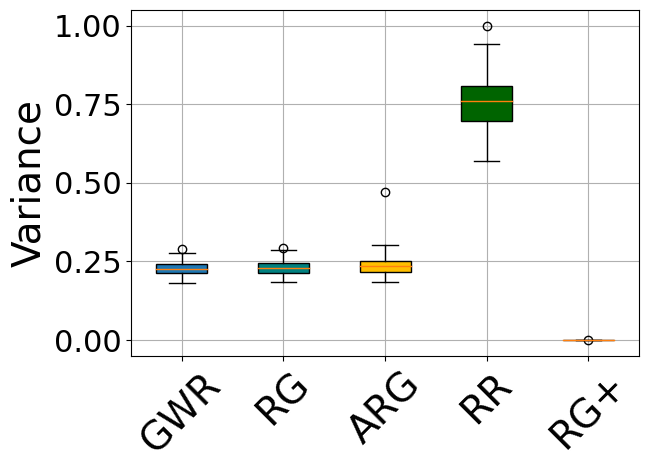

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

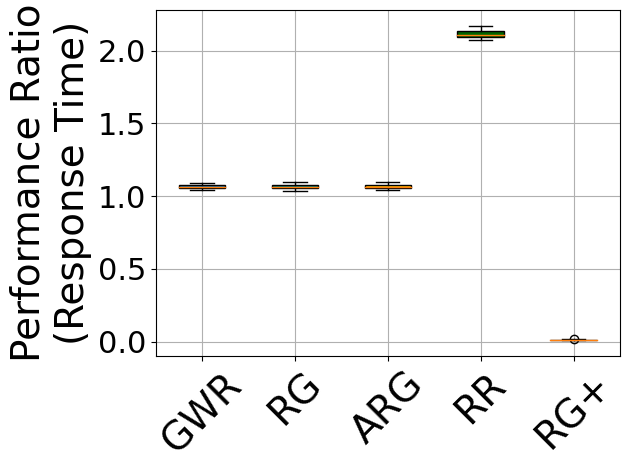

In [ ]:
BatchSet=generateBatchLogJob(0,5000,0.2,5000,1,50)
batch_test(BatchSet,1,0.3)

Performance ratio
[('GWR', [1.212837837837838, 1.266441821247892, 1.219895287958115, 1.2725779967159276, 1.2372881355932204, 1.2864238410596027, 1.329090909090909, 1.2570480928689884, 1.2478777589134125, 1.3120567375886525, 1.314711359404097, 1.3079584775086506, 1.27008547008547, 1.2738095238095237, 1.2521008403361344, 1.3158813263525306, 1.3157894736842106, 1.2370129870129871, 1.2467320261437909, 1.2601054481546572, 1.2774869109947644, 1.2790697674418605, 1.2953367875647668, 1.2689655172413794, 1.260204081632653, 1.2762923351158646, 1.2597173144876326, 1.2996323529411764, 1.2618243243243243, 1.2667757774140753, 1.3101160862354893, 1.2976190476190477, 1.2857142857142858, 1.2336134453781513, 1.2366548042704626, 1.3070469798657718, 1.2298245614035088, 1.2650822669104205, 1.2552083333333333, 1.2844827586206897, 1.3516295025728988, 1.278829604130809, 1.2464285714285714, 1.270909090909091, 1.3016949152542372, 1.2947189097103917, 1.2696078431372548, 1.3038194444444444, 1.227027027027027, 1.3

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

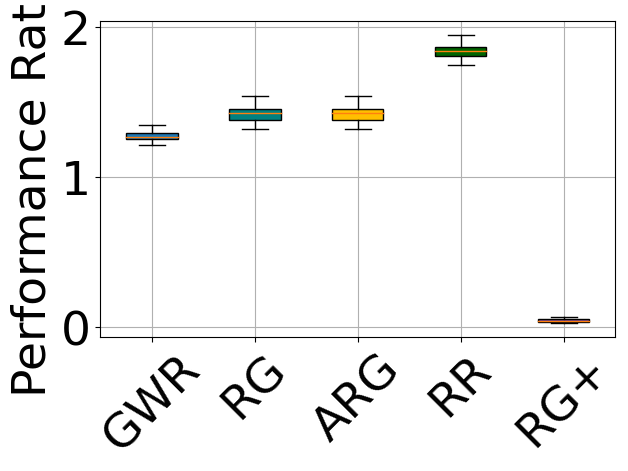

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

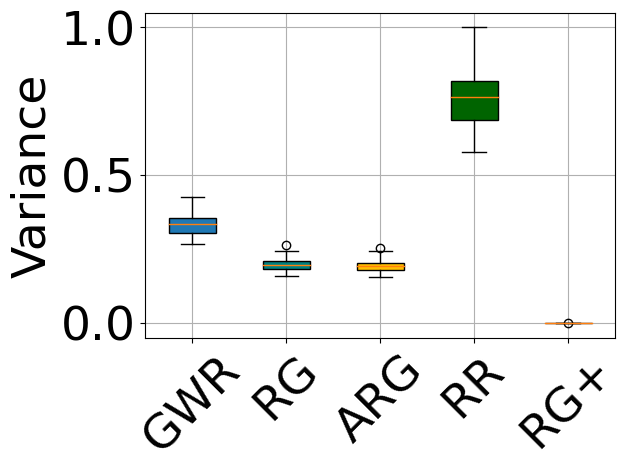

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

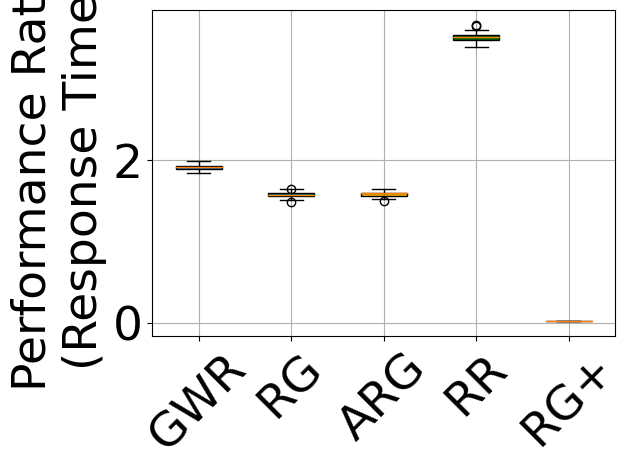

In [ ]:
BatchSet=generateBatchLogJob(0,5000,0.5,5000,1,50)
batch_test(BatchSet,1,0.3)

Performance ratio
[('GWR', [1.793713163064833, 1.7572533849129595, 1.902738432483475, 1.458955223880597, 1.9200779727095516, 1.8620689655172413, 1.8236940298507462, 1.9566891241578441, 1.8432692307692307, 1.8026948989412896, 1.459000942507069, 1.46455938697318, 1.4741379310344827, 1.9605009633911368, 1.468146718146718, 1.9169054441260744, 1.8686481303930969, 1.843429636533085, 1.8493919550982227, 1.8621700879765395, 1.8901408450704225, 1.8767258382642997, 1.9036608863198459, 1.8234741784037558, 1.8772597526165558, 1.4550669216061185, 1.8375, 1.8575525812619502, 1.4575471698113207, 1.9056785370548603, 1.8028169014084507, 1.5135658914728682, 1.9239024390243902, 1.4770813844714688, 1.8160919540229885, 1.8450704225352113, 1.4688109161793372, 1.8746355685131195, 1.9129158512720157, 1.8979980934223069, 1.8005725190839694, 1.8334919124643196, 1.9424736337488016, 1.9427184466019418, 1.679886685552408, 1.538755980861244, 1.930740037950664, 1.8716216216216217, 1.9068673565380998, 1.8099808061420

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

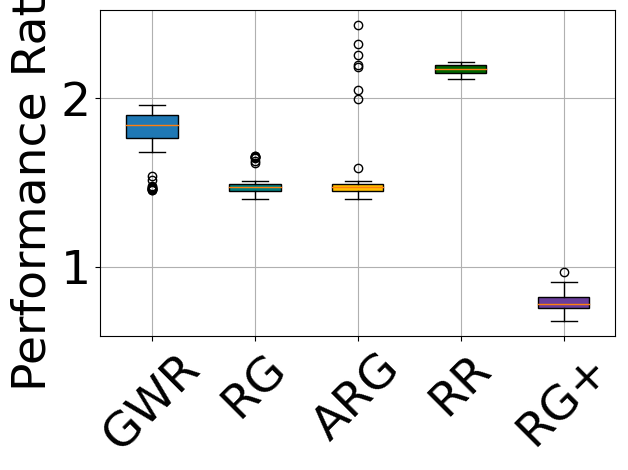

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

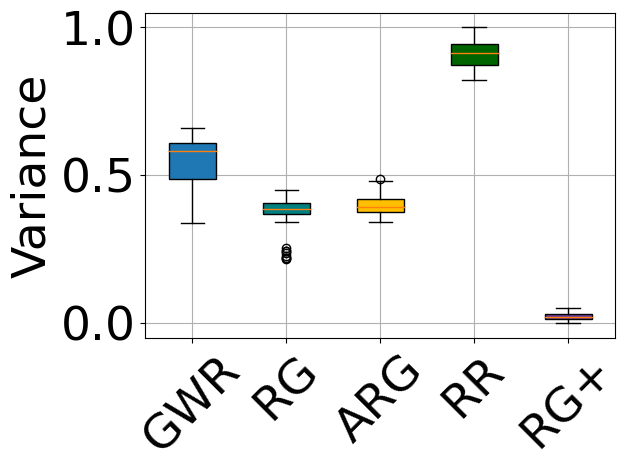

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

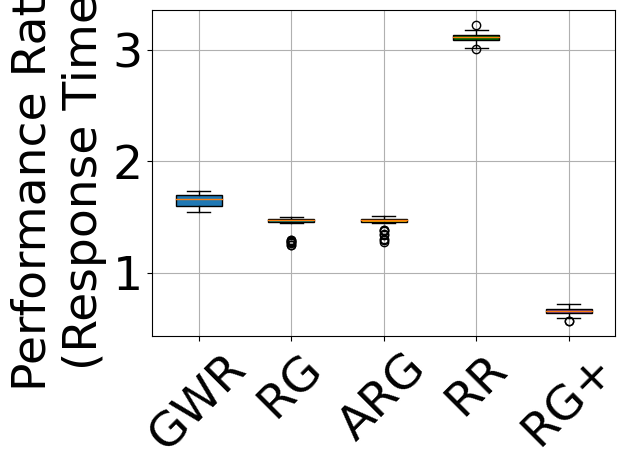

In [ ]:
BatchSet=generateBatchLogJob(0,5000,1,5000,1,50)
batch_test(BatchSet,1,0.3)


Performance ratio
[('GWR', [2.5888529886914378, 2.643867924528302, 2.7141744548286604, 2.6722354813046936, 2.6811023622047245, 2.5604395604395602, 2.5979462875197474, 2.6693227091633465, 2.6921259842519687, 2.573926868044515, 2.6413469068128426, 2.636937647987372, 2.581648522550544, 2.627279936558287, 2.6178343949044587, 2.65689381933439, 2.60224538893344, 2.541232986389111, 2.5382139983909897, 1.5559610705596107, 2.616588419405321, 1.509141494435612, 2.5827450980392155, 2.72, 2.5605095541401273, 2.661392405063291, 2.523543495610535, 3.727491961414791, 2.6378334680679063, 2.594896331738437, 2.604282315622522, 2.6408393866020985, 2.674565560821485, 2.591194968553459, 2.581320450885668, 2.6831604150039903, 2.5987606506584044, 2.611727416798732, 2.5945293644408687, 2.6551724137931036, 2.6056782334384856, 2.6040216550657385, 2.4908802537668517, 2.6457326892109503, 2.494901960784314, 2.58714859437751, 2.662348178137652, 2.6642216788916055, 2.6745283018867925, 2.5110410094637223]), ('RG', [2

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

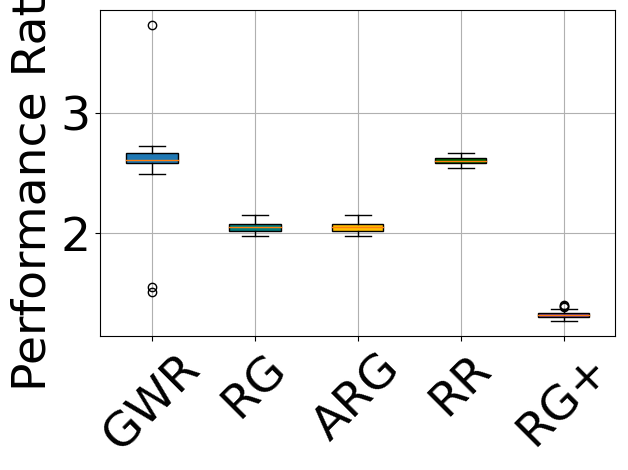

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

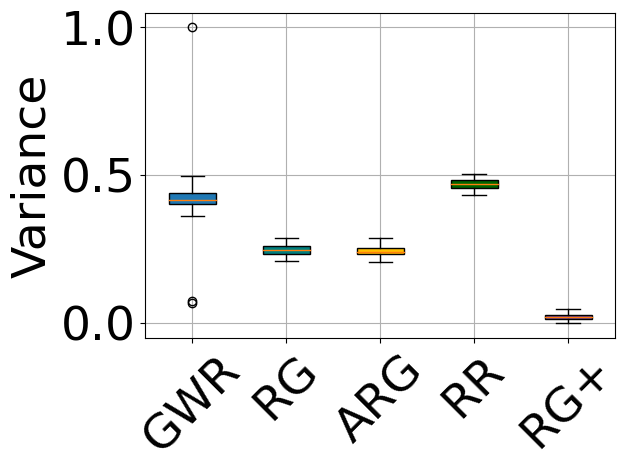

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

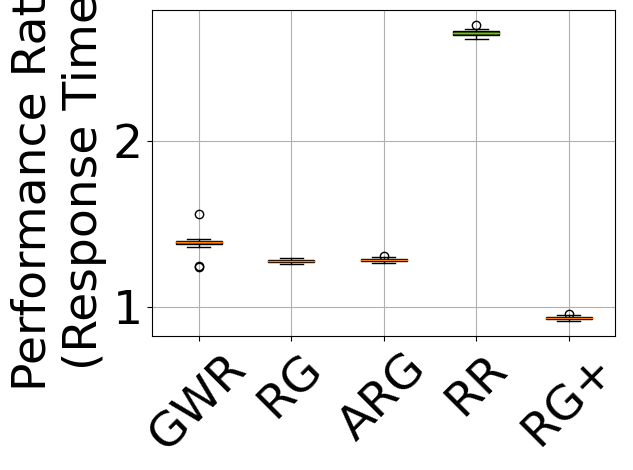

In [ ]:
BatchSet=generateBatchLogJob(0,5000,2,5000,1,50)
batch_test(BatchSet,1,0.3)


Performance ratio
[('GWR', [4.254843517138599, 2.8474331164135935, 2.962670495333812, 4.409425625920472, 4.143481427530954, 4.402777777777778, 5.5978021978021975, 2.8548387096774195, 4.243421052631579, 2.923076923076923, 4.351959361393324, 2.9338235294117645, 2.782041998551774, 2.976659372720642, 4.236511456023651, 2.8197548666186014, 2.953090096798213, 2.912490650710546, 4.43859649122807, 3.0752532561505066, 2.7948350071736012, 2.801598837209302, 2.8031088082901556, 4.225738396624473, 4.317126269956459, 2.8404726735598227, 4.2209043736100815, 4.3483727810650885, 4.245756457564576, 4.352549889135255, 4.1971428571428575, 3.123628383321141, 4.200145560407569, 2.8547445255474453, 2.911373707533235, 4.371641791044776, 4.337472607742878, 4.270622286541244, 2.8985401459854017, 4.298767222625091, 2.8306092124814266, 4.355506282335551, 4.362158167036216, 4.317777777777778, 2.9874074074074075, 2.9269911504424777, 3.032751091703057, 2.7624633431085046, 2.8687230989956958, 2.838038632986627]), ('

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

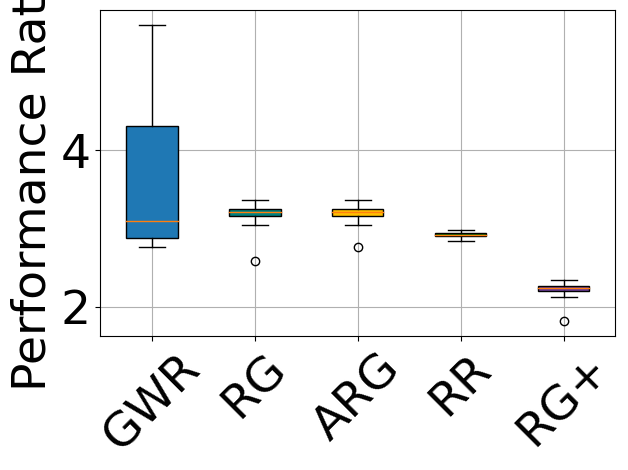

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

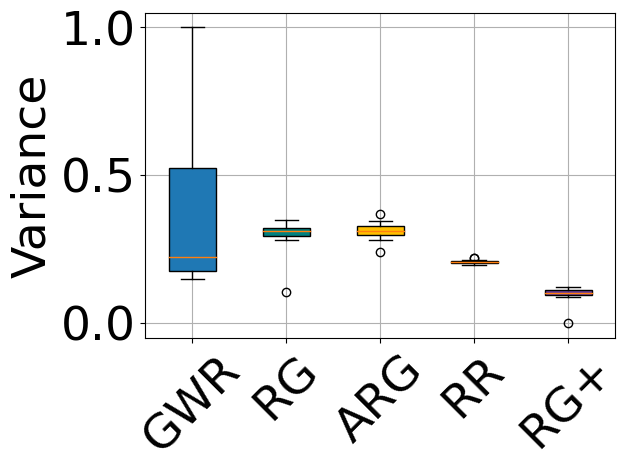

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

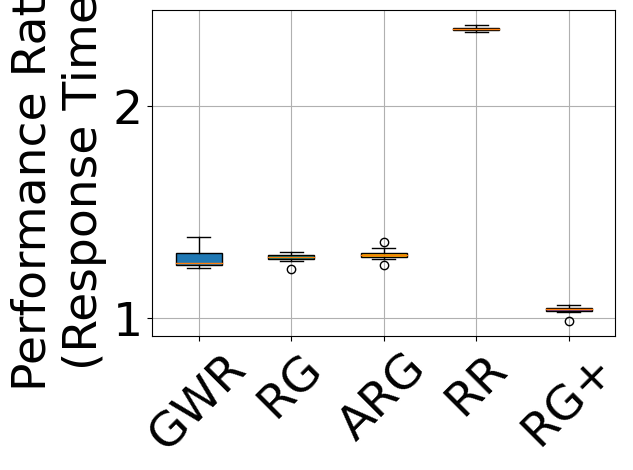

In [ ]:
BatchSet=generateBatchLogJob(0,5000,4,5000,1,50)
batch_test(BatchSet,1,0.3)



Performance ratio
[('GWR', [4.762090483619345, 4.742879746835443, 4.618153364632238, 6.091197462331483, 4.743038981702466, 3.433489827856025, 4.556432517758485, 4.490937746256895, 3.343725643024162, 6.17205998421468, 3.182888540031397, 4.539351851851852, 4.436728395061729, 4.705645161290323, 4.649136577708006, 6.09441384736428, 4.906902086677367, 3.327329678935004, 4.739567233384853, 4.656573705179283, 4.793265465935787, 4.9183006535947715, 4.778386844166014, 4.457943925233645, 4.5778466305189776, 4.6875993640699525, 3.356637863315004, 4.726218097447796, 7.6270783847981, 4.772261623325453, 7.370716510903427, 3.346729708431836, 3.322058823529412, 3.418769716088328, 4.78151918559123, 5.916796267496112, 4.612489991993595, 4.843089430894309, 4.72564302416212, 3.2905110935023774, 4.736801242236025, 6.036378334680679, 4.6357775987107175, 4.476780185758514, 4.727200634417129, 5.914285714285715, 4.650508209538702, 6.382113821138211, 4.498468606431853, 3.2990254574383453]), ('RG', [4.3291731669

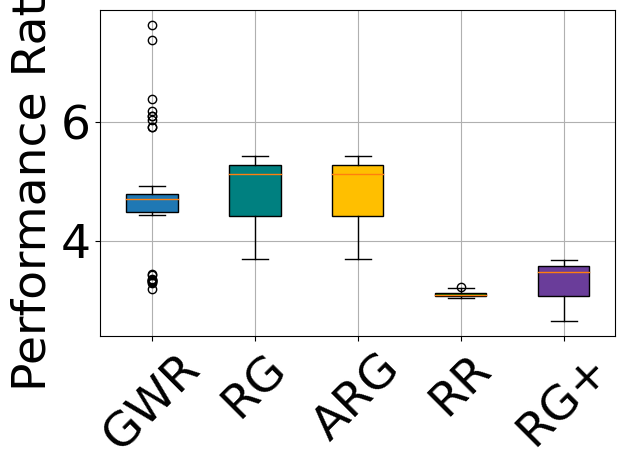

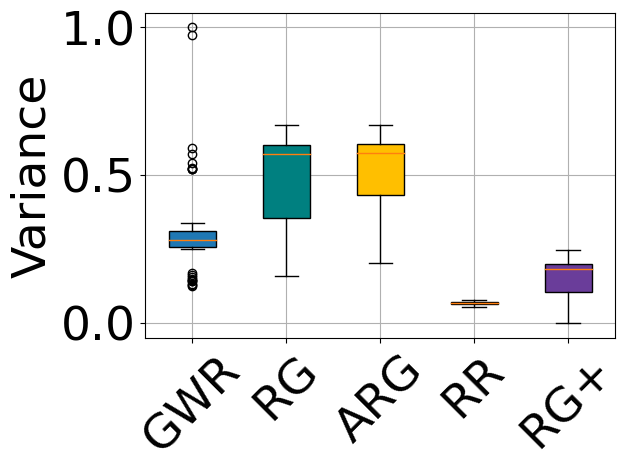

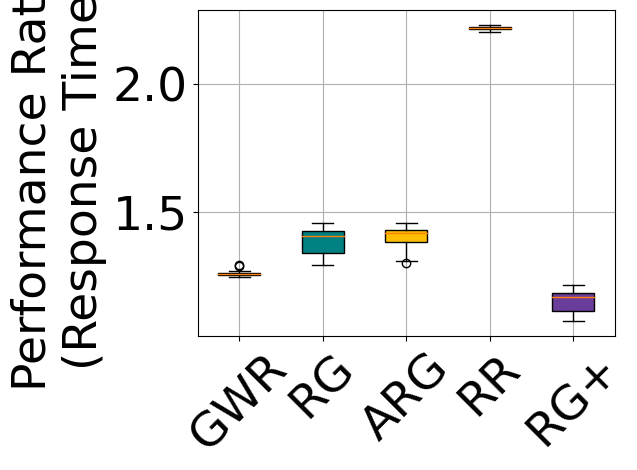

In [ ]:
BatchSet=generateBatchLogJob(0,5000,8,4500,1,50)
batch_test(BatchSet,1,0.3)

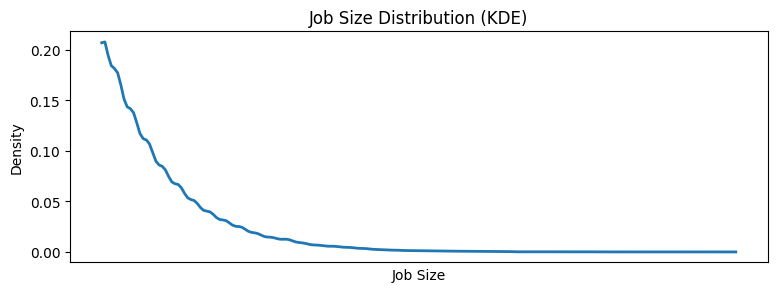

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from google.colab import files  # Importing files from google.colab

# Assuming BatchSet is already defined and contains your data
BatchSet = generateBatchLogJob(0, 5000, 4, 1000, 1, 50)
job_sizes = []
for jobs in BatchSet:
    for j in jobs:
        job_sizes.append(j.jobSize)

# Perform Kernel Density Estimation
kde = gaussian_kde(job_sizes)

# Generating a smooth range of job sizes
smooth_job_sizes = np.linspace(min(job_sizes), max(job_sizes), 200)

# Calculate the values of the density function
density = kde(smooth_job_sizes)

# Plotting the line graph with a 3:1 width-to-height ratio
plt.figure(figsize=(9, 3))  # Adjust the size here for 3:1 ratio
plt.plot(smooth_job_sizes, density, linewidth=2)

# Hiding the x-axis labels
plt.xticks([])

# Setting labels and title
plt.ylabel('Density')
plt.xlabel('Job Size')
plt.title('Job Size Distribution (KDE)')

# Saving the plot in PDF format
filename = 'job_size_distribution.pdf'
plt.savefig(filename, dpi=300)

# Show the plot
plt.show()

# Download the file
files.download(filename)

In [ ]:
BatchSet=generateBatchLogJob(0,4000,16,5000,1,50)
batch_test(BatchSet,1,0.3)


Performance ratio
[('Greedy with Rounding', [7.730847457627118, 6.994754098360656, 7.403520649966148, 7.262110152621101, 8.540175557056044, 8.153794940079894, 7.012855209742896, 7.462491397109429, 7.1133069828722, 6.633254716981132, 7.024080267558529, 8.1892247043364, 8.125930941096819, 6.594153636981646, 7.1686909581646425, 9.106254203093476, 7.268788083953961, 6.713921404682274, 9.745214521452144, 7.350067842605156, 6.59253518766756, 7.519217801753203, 8.602555480833894, 11.77278820375335, 7.072178477690288, 8.125169147496617, 8.39531772575251, 7.065508021390374, 7.15803631472764, 9.046666666666667, 9.339118825100133, 9.428381962864721, 8.166666666666666, 6.691749174917492, 8.699602122015914, 7.526635198921106, 8.14257555847569, 6.945638945233266, 6.725815948855989, 10.206477732793521, 8.80217539089055, 6.55277401894452, 6.666792929292929, 6.850367401469606, 7.063844086021505, 6.625750500333556, 7.069565217391304, 8.500677506775068, 7.716993464052288, 6.763504611330698]), ('Relaxed G

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

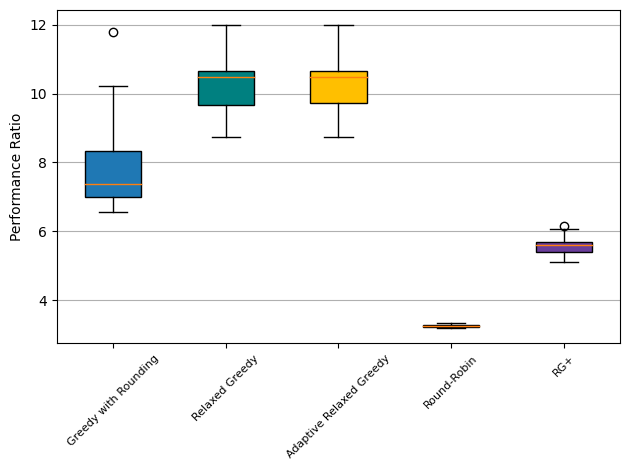

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

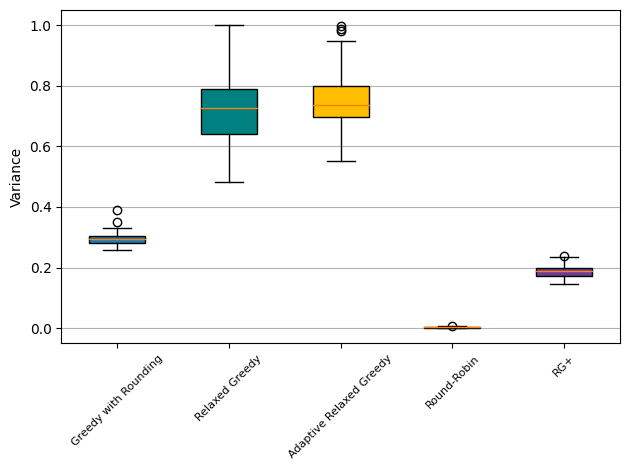

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

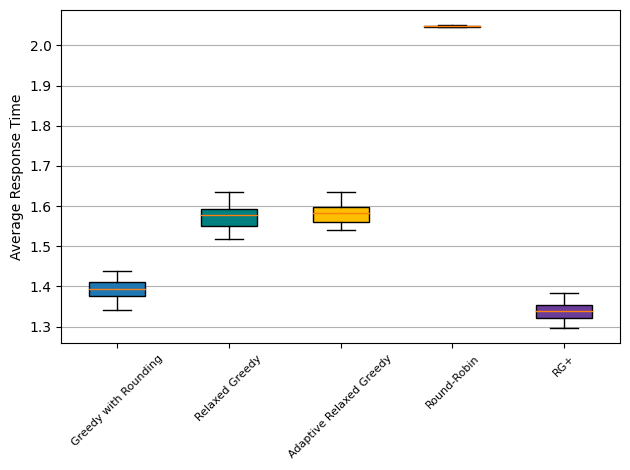

In [ ]:
BatchSet=generateBatchLogJob(0,4500,32,5000,1,50)
batch_test(BatchSet,1,0.3)

Performance ratio
[('Greedy with Rounding', [2.4107959743824336, 2.276555023923445, 2.3290083410565336, 2.333021515434986, 2.3189493433395874, 2.3055295220243672, 2.4442396313364054, 2.2602230483271377, 2.281015037593985, 2.3455743879472695]), ('Relaxed Greedy', [1.8767917047880454, 2.012759170653908, 2.0021624961384, 1.965076395385095, 1.9846779237023138, 1.9453295845048422, 1.9314900153609829, 2.021995043370508, 2.0350877192982457, 2.061519146264909]), ('Adaptive Relaxed Greedy', [1.8767917047880454, 2.012759170653908, 2.0021624961384, 1.965076395385095, 1.9846779237023138, 1.9453295845048422, 1.9314900153609829, 2.021995043370508, 2.0350877192982457, 2.061519146264909]), ('Round-Robin', [2.5238074887479307, 2.568027388007963, 2.5756012516819355, 2.56923778176792, 2.5843333713414287, 2.5528814205346055, 2.548942314032103, 2.581161394019966, 2.6067415029313628, 2.5982274665654383]), ('RG+', [1.191515488186593, 1.2603227513716306, 1.2445404605716754, 1.2202866605263862, 1.2534257884057

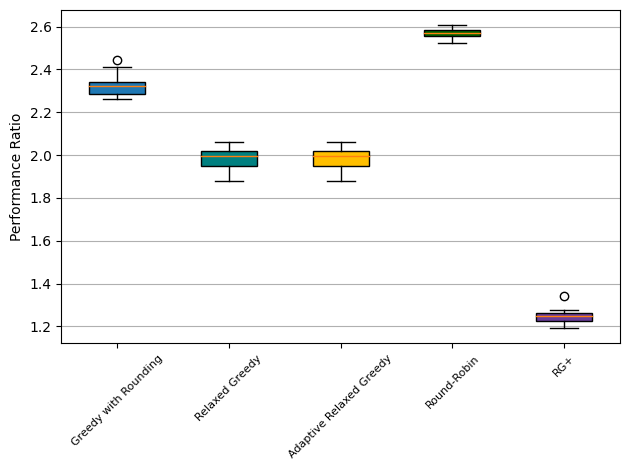

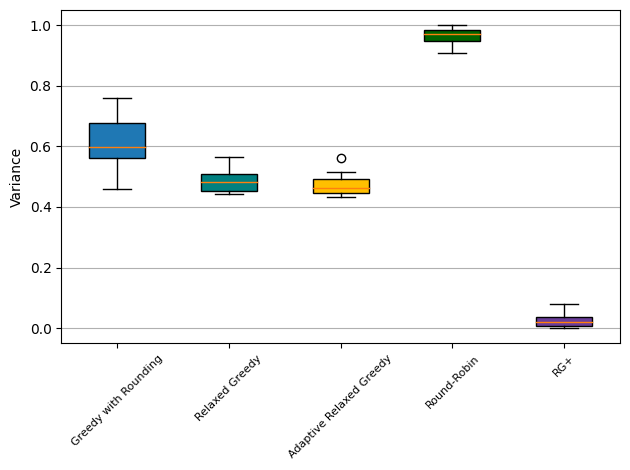

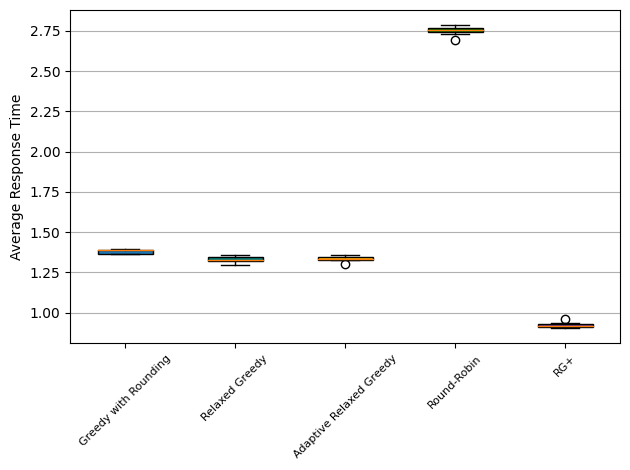

In [ ]:
BatchSet=generateBatchLogJob(0,5000,2,4500,1,10)
batch_test(BatchSet,1,0.3)

Performance ratio
[('Greedy with Rounding', [2.5049423393739705, 2.358428805237316, 4.090376569037657, 3.981270358306189, 4.067669172932331, 2.3640856672158157, 3.9439728353140917, 4.0388185654008435, 2.6218905472636815, 3.942339373970346]), ('Relaxed Greedy', [3.1480642504118617, 3.1370703764320784, 3.302510460251046, 3.0598534201954397, 3.129908103592314, 3.2014003294892914, 3.216893039049236, 3.160548523206751, 3.2284411276948592, 3.227553542009885]), ('Adaptive Relaxed Greedy', [3.1480642504118617, 3.1370703764320784, 3.302510460251046, 3.0598534201954397, 3.129908103592314, 3.2014003294892914, 3.216893039049236, 3.160548523206751, 3.2284411276948592, 3.227553542009885]), ('Round-Robin', [2.8911933587014342, 2.8466413777056525, 2.934947806208493, 2.841506758806496, 2.906722144661699, 2.895617278769447, 2.9344304824228478, 2.9186953267036575, 2.8862935290556675, 2.8770878020748394]), ('RG+', [2.1822426321092925, 2.176622568170817, 2.279725437255207, 2.115277289002117, 2.143438870216

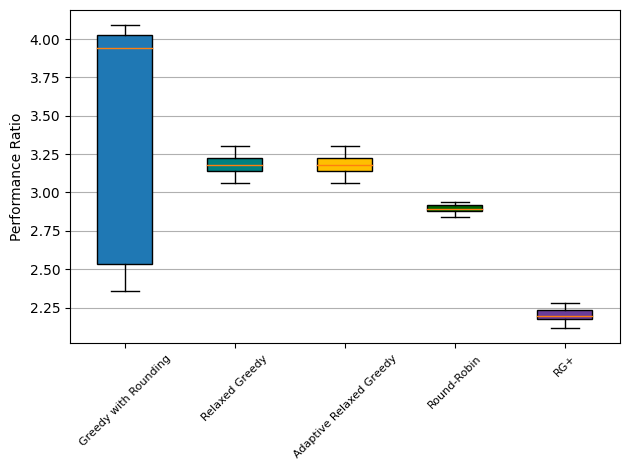

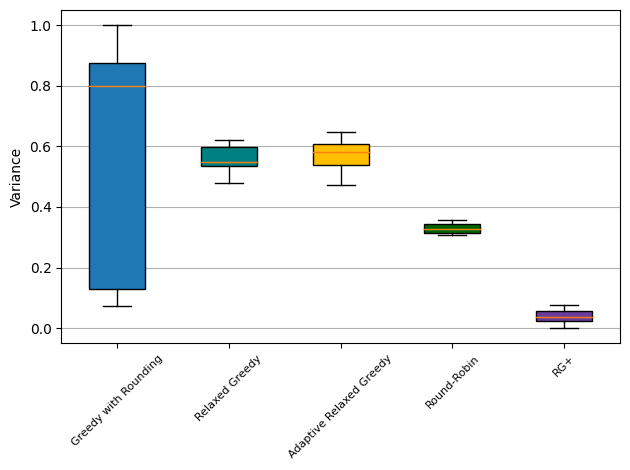

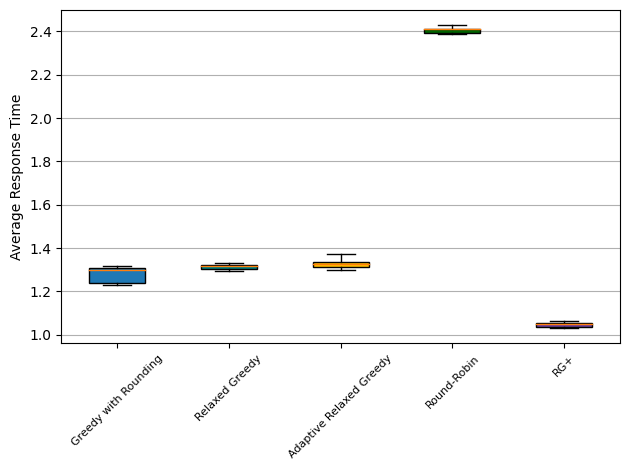

In [ ]:
BatchSet=generateBatchLogJob(0,5000,4,4500,1,10)
batch_test(BatchSet,1,0.3)

Performance ratio
[('Greedy with Rounding', [3.2886115444617783, 5.953560371517028, 3.373228346456693, 3.2568958818958818, 4.662948207171315, 4.67741935483871, 4.732967893500391, 4.48208722741433, 4.260601387818042, 5.952267303102626]), ('Relaxed Greedy', [5.14820592823713, 4.2480650154798765, 5.225669291338583, 5.2006216006216, 5.30215139442231, 4.442696039863625, 5.059044635865309, 4.34527518172378, 4.386019018247238, 4.441394855476001]), ('Adaptive Relaxed Greedy', [5.14820592823713, 4.2480650154798765, 5.225669291338583, 5.2006216006216, 5.30215139442231, 4.442696039863625, 5.059044635865309, 4.34527518172378, 4.386019018247238, 4.441394855476001]), ('Round-Robin', [3.0727865270106296, 3.0428605556109685, 3.0984745985364825, 3.0639535030391007, 3.1404287804306983, 3.09796402043557, 3.0750145657406813, 3.051099343984608, 3.0373549529569726, 3.148781552430528]), ('RG+', [3.505721007811984, 3.00053589251137, 3.5300158289084425, 3.5234506644454564, 3.557955159527656, 3.091515367288627,

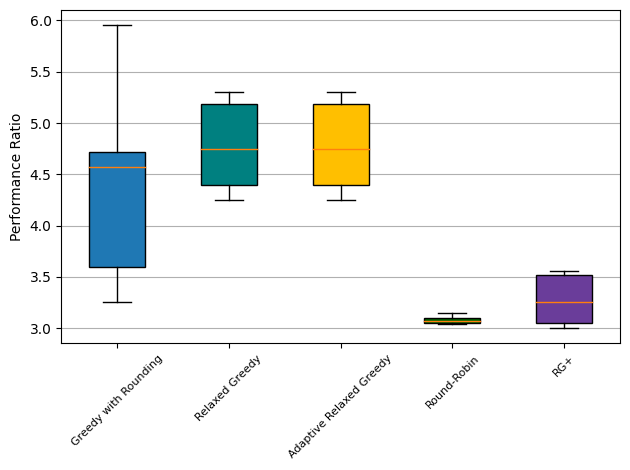

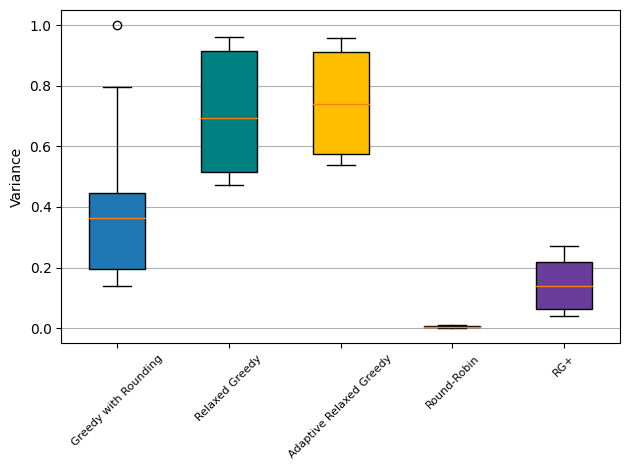

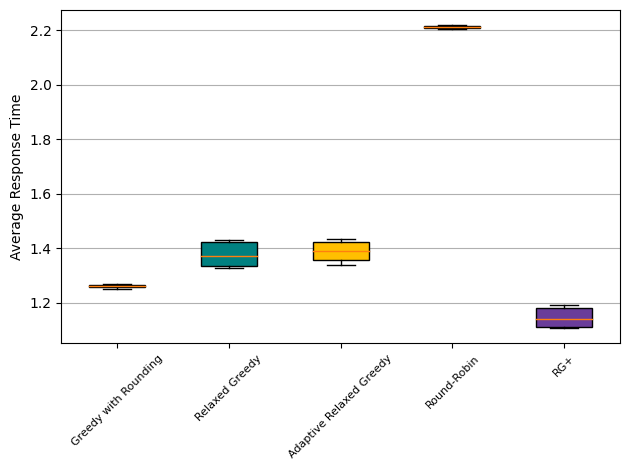

In [ ]:
BatchSet=generateBatchLogJob(0,5000,8,4500,1,10)
batch_test(BatchSet,1,0.3)

Performance ratio
[('Greedy with Rounding', [6.766513056835637, 5.526591760299626, 4.632105441027374, 4.856275014293882, 5.589939024390244, 6.757251908396946, 6.267843438219494, 5.316426949280848, 4.475980425942518, 6.45]), ('Relaxed Greedy', [6.511040706605223, 7.14414125200642, 7.325756771109931, 7.75381850853549, 7.523083623693379, 7.474263904034896, 6.82012663085188, 7.413972099059155, 7.158669988086212, 6.57594696969697]), ('Adaptive Relaxed Greedy', [6.511040706605223, 7.14414125200642, 7.325756771109931, 7.75381850853549, 7.523083623693379, 7.474263904034896, 6.82012663085188, 7.413972099059155, 7.158669988086212, 6.57594696969697]), ('Round-Robin', [3.226543241780781, 3.1708822065005564, 3.1389792819349798, 3.304394475192426, 3.2245951411692664, 3.2133747175860905, 3.2218497421298617, 3.1672825288662585, 3.1820350033135387, 3.1883251117888354]), ('RG+', [4.251575298815728, 4.479487096822451, 4.559918708755066, 4.786101221725156, 4.654066579652203, 4.678849677834107, 4.208157933

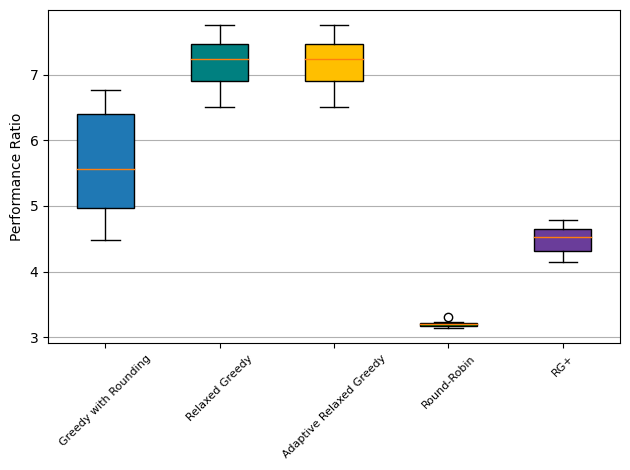

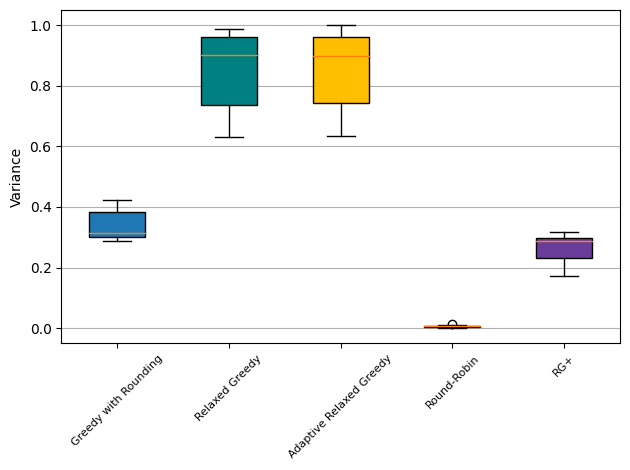

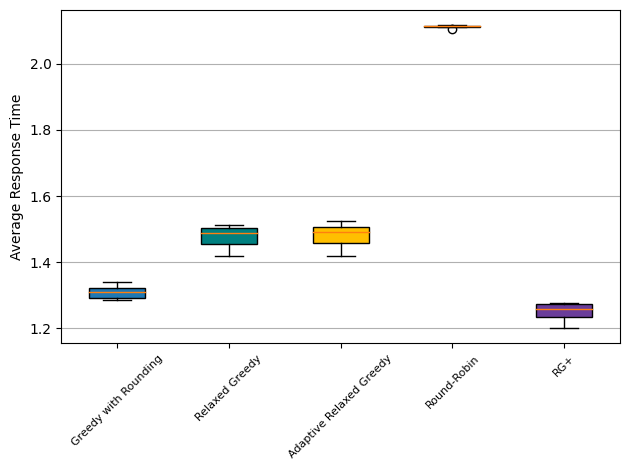

In [ ]:
BatchSet=generateBatchLogJob(0,5000,16,4500,1,10)
batch_test(BatchSet,1,0.3)

<ipython-input-28-e140dc1b1f41>:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_values = group_df.groupby('X_mapped').median()['Value']
<ipython-input-28-e140dc1b1f41>:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_values = group_df.groupby('X_mapped').median()['Value']
<ipython-input-28-e140dc1b1f41>:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_values = group_df.groupby('X_mapped'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

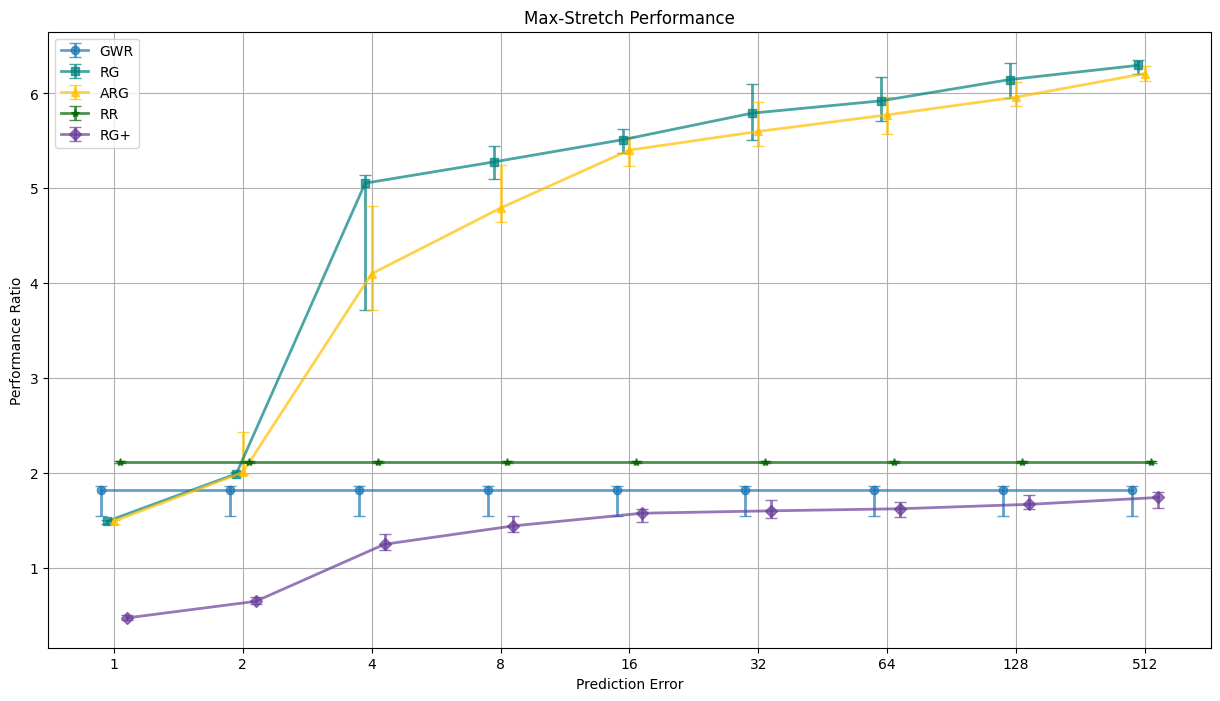

<ipython-input-28-e140dc1b1f41>:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_values = group_df.groupby('X_mapped').median()['Value']
<ipython-input-28-e140dc1b1f41>:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_values = group_df.groupby('X_mapped').median()['Value']
<ipython-input-28-e140dc1b1f41>:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_values = group_df.groupby('X_mapped'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

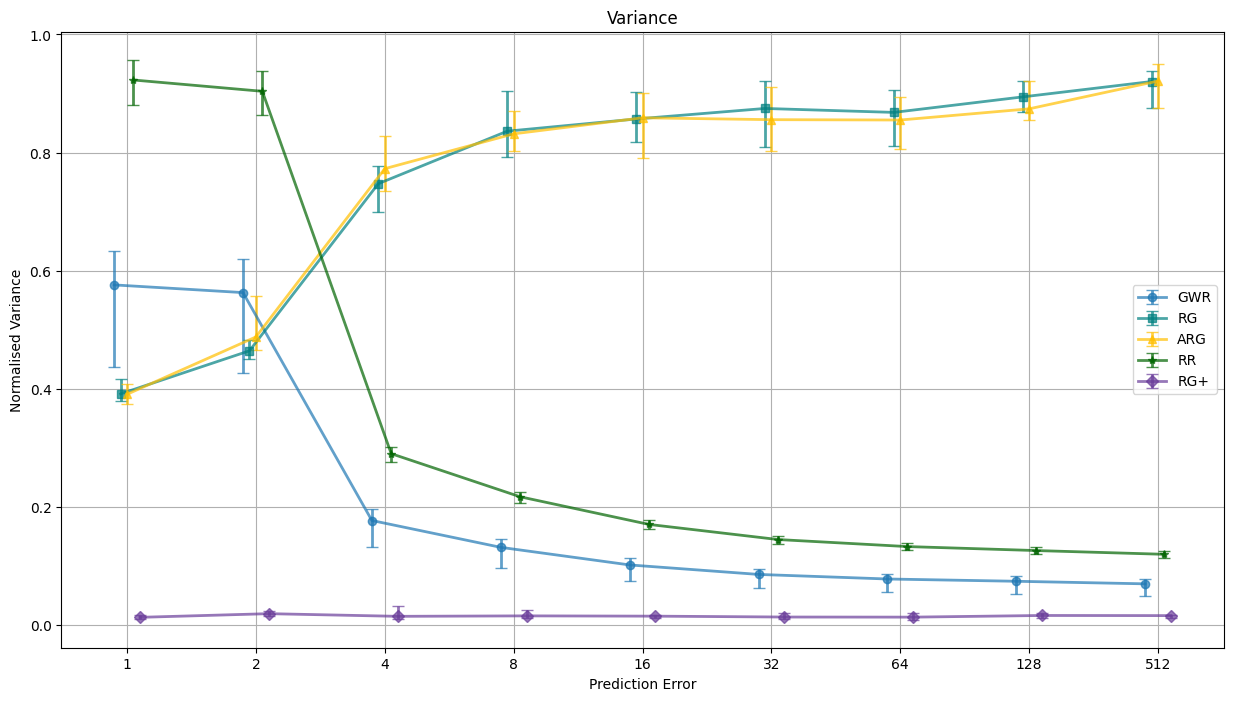

<ipython-input-28-e140dc1b1f41>:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_values = group_df.groupby('X_mapped').median()['Value']
<ipython-input-28-e140dc1b1f41>:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_values = group_df.groupby('X_mapped').median()['Value']
<ipython-input-28-e140dc1b1f41>:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_values = group_df.groupby('X_mapped'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

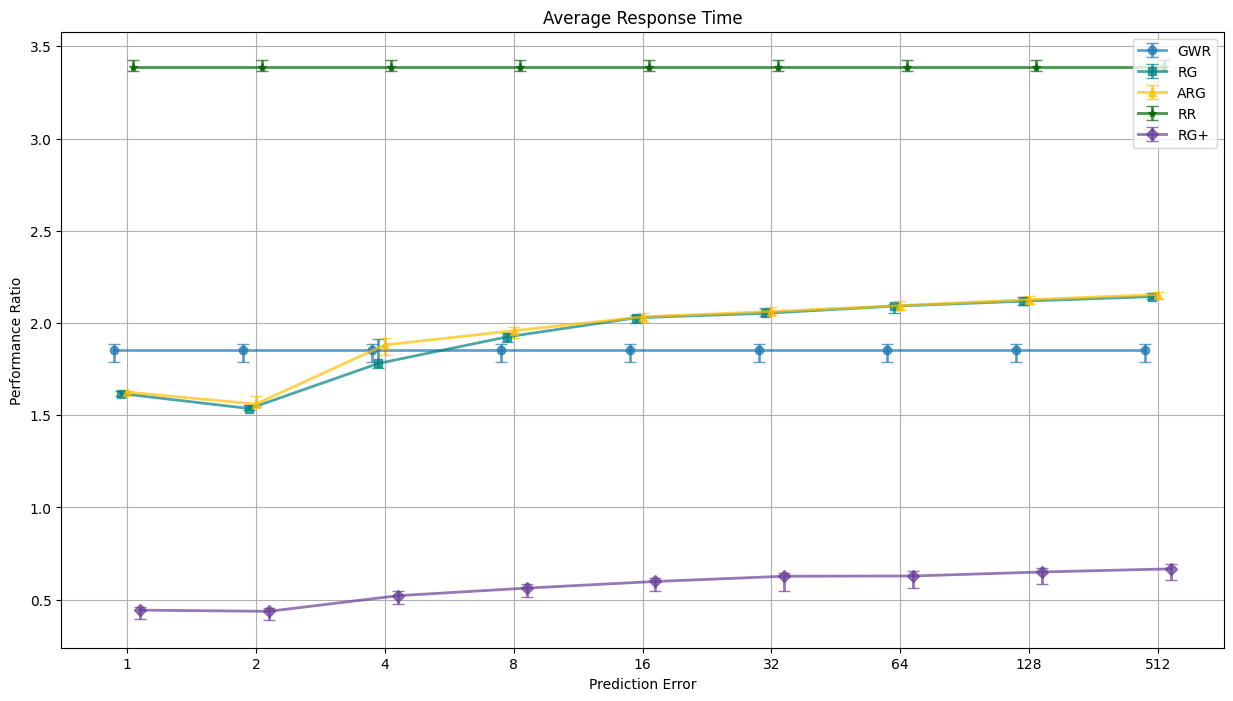

In [ ]:
BatchSet=generateBatchLogJob(0,5000,1,500,1,50)
batch_record(500,S_Data,V_Data,R_Data,BatchSet,1,0.5)
BatchSet=generateBatchLogJob(0,5000,1,10000,1,50)
batch_record(10000,S_Data,V_Data,R_Data,BatchSet,1,0.5)

KeyboardInterrupt: ignored

In [ ]:
backupS,backupV,backupR=S_Data,V_Data,R_Data
TS,TV,TR=copy.deepcopy(backupS),copy.deepcopy(backupV),copy.deepcopy(backupV)

In [ ]:
s_df = pd.DataFrame(TS)

In [ ]:
s_df[s_df['Group'] == "RG+"]

Group      X     Value
200    RG+   1000  1.833333
201    RG+   1000  3.166667
202    RG+   1000  4.142857
203    RG+   1000  4.296296
204    RG+   1000  2.666667
...    ...    ...       ...
5245   RG+  10000  0.757029
5246   RG+  10000  0.751636
5247   RG+  10000  0.717089
5248   RG+  10000  0.712632
5249   RG+  10000  0.712447

[1050 rows x 3 columns]

from matplotlib import pyplot as plt
_df_16['X'].plot(kind='hist', bins=20, title='X')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_17['Value'].plot(kind='hist', bins=20, title='Value')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_18.plot(kind='scatter', x='X', y='Value', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_19['X'].plot(kind='line', figsize=(8, 4), title='X')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_20['Value'].plot(kind='line', figsize=(8, 4), title='Value')
plt.gca().spines[['top', 'right']].set_visible(False)

Performance ratio
[('Greedy with Rounding', [1.823943661971831, 1.768939393939394, 1.4742857142857142, 1.6660117878192535, 1.3901996370235934, 1.396678966789668]), ('Relaxed Greedy', [7.061619718309859, 7.015151515151516, 6.659047619047619, 6.81335952848723, 6.911070780399274, 6.645756457564576]), ('Adaptive Relaxed Greedy', [7.033450704225352, 6.833333333333333, 6.64, 6.8055009823182715, 6.856624319419238, 6.645756457564576]), ('Round-Robin', [2.1073122137990263, 2.094143296630713, 2.102551089463793, 2.032640228162338, 2.04641532577196, 1.9672617136876276]), ('RG+', [0.4215670974745889, 0.3230509788737129, 0.388417169786599, 0.4183345441500542, 0.24966121389005339, 0.229102914092846])]
variance
[('Greedy with Rounding', [0.08127029243664599, 0.07179782016692648, 0.05210163548096015, 0.05481009433532437, 0.04684426578285702, 0.042296968112869225]), ('Relaxed Greedy', [1.0, 0.8032210449302802, 0.7257332852655161, 0.7012154579005052, 0.8836944989116964, 0.7752474087744093]), ('Adaptive R

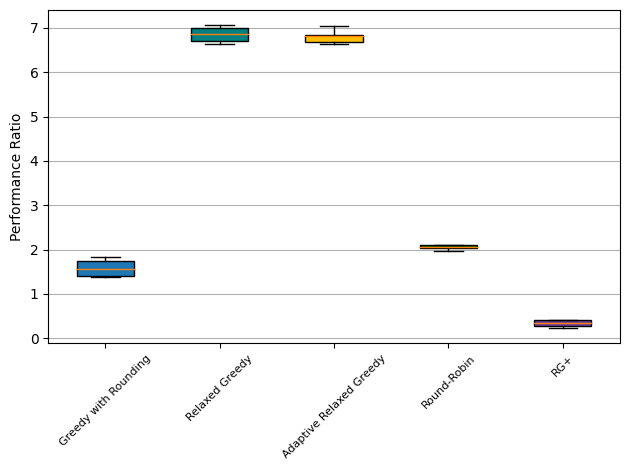

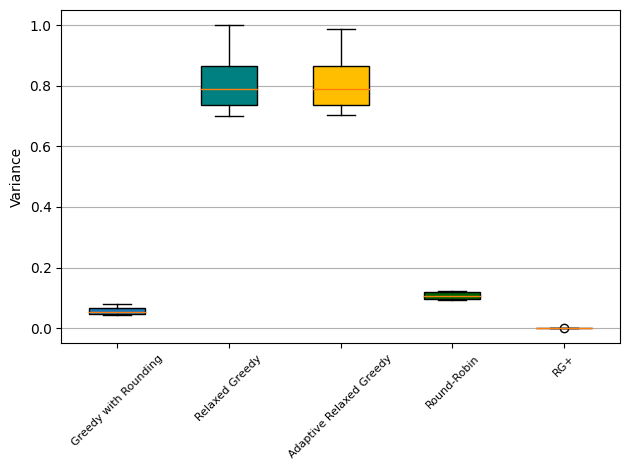

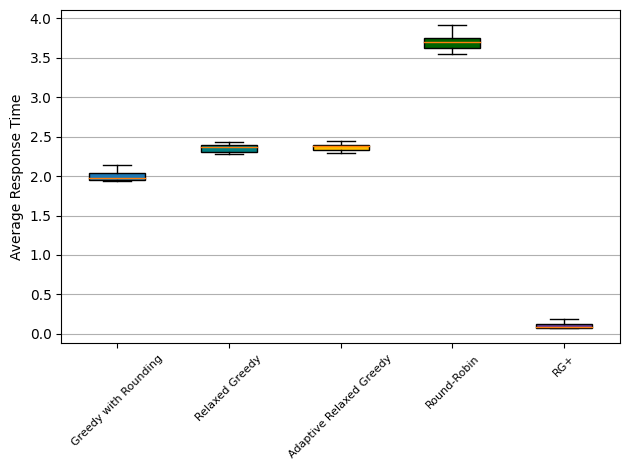

In [ ]:
BatchSet=generateBatchLogJob(0,5000,1,4000,512,6)
batch_test(BatchSet,1,0.3)

Performance ratio
[('Greedy with Rounding', [1.8022813688212929, 1.8003696857670979, 1.7634011090573012, 1.4716636197440585, 1.7779816513761468, 1.7408759124087592]), ('Relaxed Greedy', [1.5922053231939164, 1.5720887245841035, 1.5813308687615526, 1.553016453382084, 1.5091743119266054, 1.4543795620437956]), ('Adaptive Relaxed Greedy', [1.5922053231939164, 1.5720887245841035, 1.5813308687615526, 1.553016453382084, 1.5091743119266054, 1.4543795620437956]), ('Round-Robin', [2.064953744338214, 1.9950381080064032, 2.052115907462688, 2.0769652348156655, 2.077286685126033, 1.994704718193114]), ('RG+', [1.052599648985283, 0.9295458079535409, 0.9931400904434144, 1.0047003511908688, 0.9862881329445555, 0.9566436598235268])]
variance
[('Greedy with Rounding', [0.5187693068768247, 0.5777607931766485, 0.5835280998649852, 0.3723883182890115, 0.5727131463585295, 0.578170921656662]), ('Relaxed Greedy', [0.28600850343721645, 0.27884117487738624, 0.3415400843656336, 0.32016809097212573, 0.334677713851062

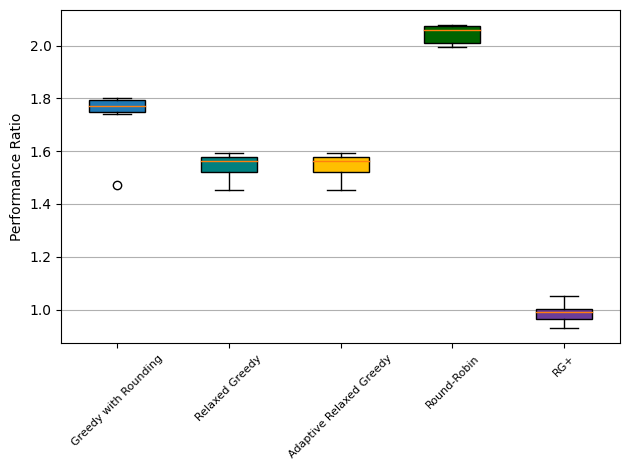

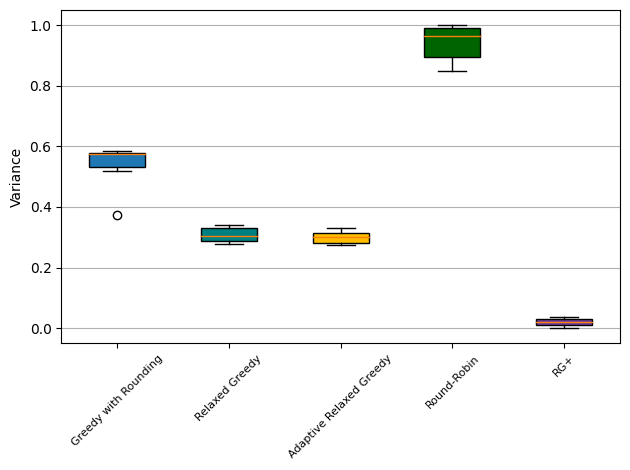

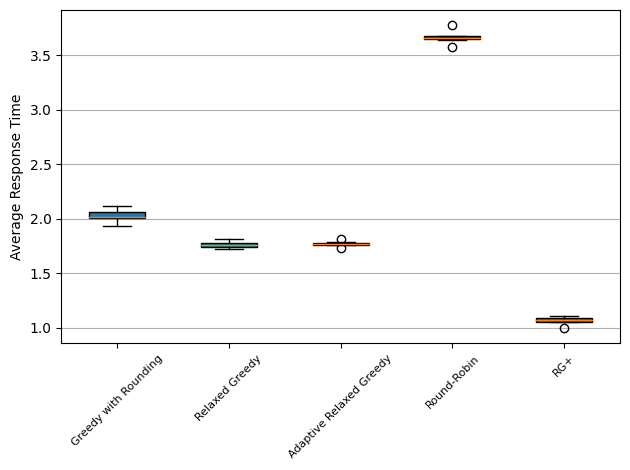

In [ ]:
BatchSet=generateBatchLogJob(0,5000,1,4000,1,6)
batch_test(BatchSet,1,0.1)

In [ ]:
BatchSet=generateBatchLogJob(0,5000,1,4000,1,6)
batch_test(BatchSet,1,0)

In [ ]:
S1_Data,V1_Data,R1_Data=[],[],[]
BatchSet=generateBatchLogJob(0,5000,1,1000,1,6)
batch_record(1000,S1_Data,V1_Data,R1_Data,BatchSet,1,0.3)

In [ ]:
S1_Data,V1_Data,R1_Data=[],[],[]
BatchSet=generateBatchLogJob(0,5000,1,500,1,6)
batch_record(500,S1_Data,V_Data,R_Data,BatchSet,1,0.3)
BatchSet=generateBatchLogJob(0,5000,1,1000,1,6)
batch_record(1000,S1_Data,V_Data,R_Data,BatchSet,1,0.3)
BatchSet=generateBatchLogJob(0,5000,1,2000,1,6)
batch_record(2000,S1_Data,V_Data,R_Data,BatchSet,1,0.3)
BatchSet=generateBatchLogJob(0,5000,1,3000,1,6)
batch_record(3000,S1_Data,V_Data,R_Data,BatchSet,1,0.3)
BatchSet=generateBatchLogJob(0,5000,1,4000,1,6)
batch_record(4000,S1_Data,V_Data,R_Data,BatchSet,1,0.3)
BatchSet=generateBatchLogJob(0,5000,1,5000,1,6)
batch_record(5000,S1_Data,V_Data,R_Data,BatchSet,1,0.3)
BatchSet=generateBatchLogJob(0,5000,1,10000,1,6)
batch_record(10000,S1_Data,V_Data,R_Data,BatchSet,1,0.3)


<ipython-input-42-8a339c8d4dbd>:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_values = group_df.groupby('X_mapped').median()['Value']
<ipython-input-42-8a339c8d4dbd>:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_values = group_df.groupby('X_mapped').median()['Value']
<ipython-input-42-8a339c8d4dbd>:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_values = group_df.groupby('X_mapped'

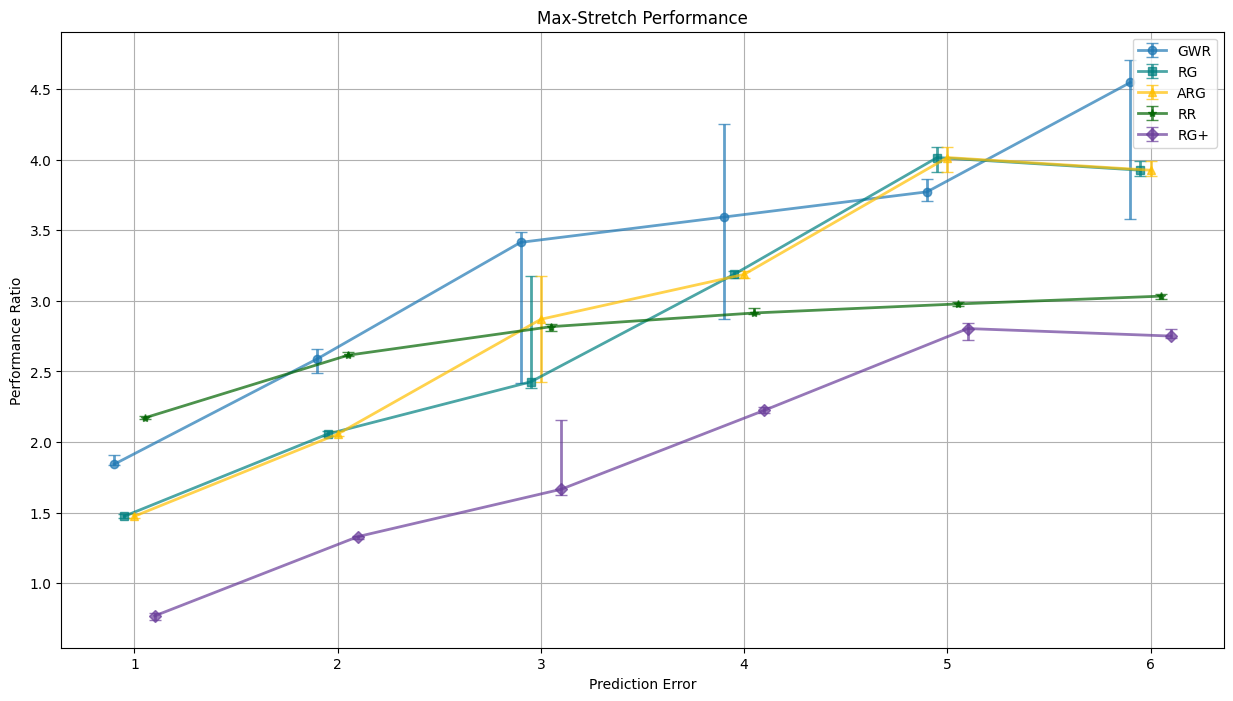

In [ ]:
S2_Data,V2_Data,R2_Data=[],[],[]
BatchSet=generateBatchLogJob(0,5000,1,5000,1,10)
batch_record(1,S2_Data,V2_Data,R2_Data,BatchSet,1,0.3)
BatchSet=generateBatchLogJob(0,5000,2,5000,1,10)
batch_record(2,S2_Data,V2_Data,R2_Data,BatchSet,1,0.3)
BatchSet=generateBatchLogJob(0,5000,3,5000,1,10)
batch_record(3,S2_Data,V2_Data,R2_Data,BatchSet,1,0.3)
BatchSet=generateBatchLogJob(0,5000,4,5000,1,10)
batch_record(4,S2_Data,V2_Data,R2_Data,BatchSet,1,0.3)
BatchSet=generateBatchLogJob(0,5000,5,5000,1,10)
batch_record(5,S2_Data,V2_Data,R2_Data,BatchSet,1,0.3)
BatchSet=generateBatchLogJob(0,5000,6,5000,1,10)
batch_record(6,S2_Data,V2_Data,R2_Data,BatchSet,1,0.3)
s_df = pd.DataFrame(S2_Data)
draw_error_bar(s_df,"Max-Stretch Performance","Job Size","Performance Ratio")

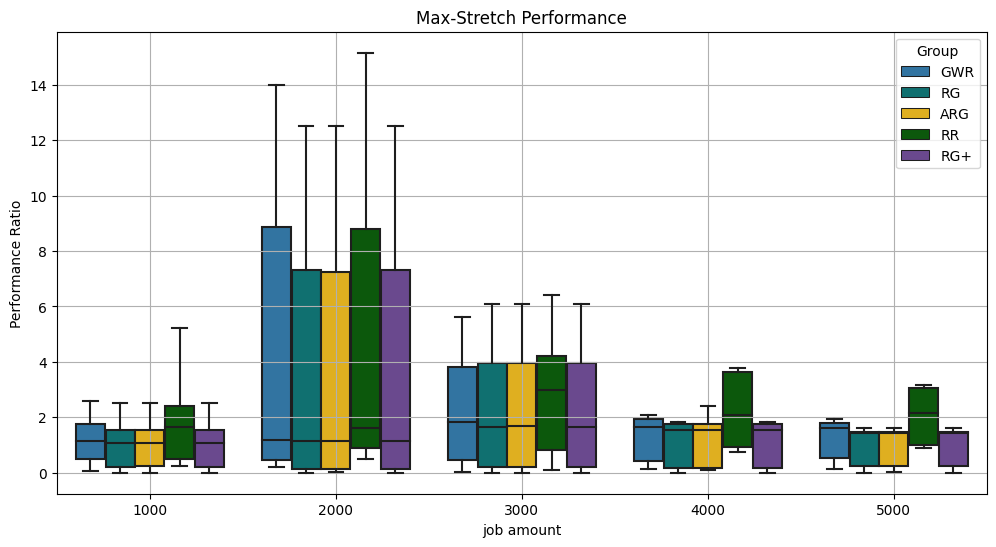

In [ ]:
draw_seaborn_box_plot(s_df,"Max-Stretch Performance","job amount","Performance Ratio")

In [ ]:
BatchSet=generateBatchLogJob(0,5000,1,5000,1,50)
batch_test(BatchSet,1,0.3)

Group     X     Value  X_mapped
0     GWR  1000  1.733524         1
1     GWR  1000  1.787966         1
2     GWR  1000  1.703390         1
3     GWR  1000  1.704142         1
4     GWR  1000  2.589666         1
..    ...   ...       ...       ...
895   RG+  5000  1.428708         5
896   RG+  5000  1.285808         5
897   RG+  5000  1.469813         5
898   RG+  5000  1.482724         5
899   RG+  5000  1.473005         5

[900 rows x 4 columns]

from matplotlib import pyplot as plt
s_df['X'].plot(kind='hist', bins=20, title='X')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
s_df['Value'].plot(kind='hist', bins=20, title='Value')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
s_df['X_mapped'].plot(kind='hist', bins=20, title='X_mapped')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
s_df.groupby('Group').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
s_df.plot(kind='scatter', x='X', y='Value', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
s_df.plot(kind='scatter', x='Value', y='X_mapped', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['X']
  ys = series['Value']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = s_df.sort_values('X', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Group')):
  _plot_series(series, series_name, i)
  fig.legend(title='Group', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('X')
_ = plt.ylabel('Value')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['X']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'X'}, axis=1)
              .sort_values('X', ascending=True))
  xs = counted['X']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = s_df.sort_values('X', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Group')):
  _plot_series(series, series_name, i)
  fig.legend(title='Group', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('X')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['X_mapped']
  ys = series['Value']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = s_df.sort_values('X_mapped', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Group')):
  _plot_series(series, series_name, i)
  fig.legend(title='Group', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('X_mapped')
_ = plt.ylabel('Value')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['X_mapped']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'X_mapped'}, axis=1)
              .sort_values('X_mapped', ascending=True))
  xs = counted['X_mapped']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = s_df.sort_values('X_mapped', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Group')):
  _plot_series(series, series_name, i)
  fig.legend(title='Group', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('X_mapped')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
s_df['X'].plot(kind='line', figsize=(8, 4), title='X')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
s_df['Value'].plot(kind='line', figsize=(8, 4), title='Value')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
s_df['X_mapped'].plot(kind='line', figsize=(8, 4), title='X_mapped')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(s_df['Group'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(s_df, x='X', y='Group', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(s_df['Group'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(s_df, x='Value', y='Group', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(s_df['Group'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(s_df, x='X_mapped', y='Group', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

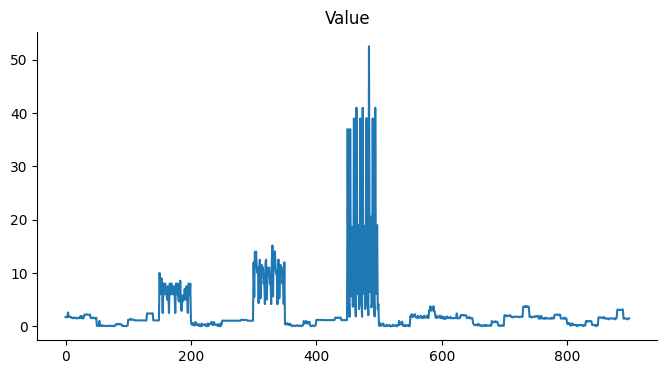

In [ ]:
from matplotlib import pyplot as plt
s_df['Value'].plot(kind='line', figsize=(8, 4), title='Value')
plt.gca().spines[['top', 'right']].set_visible(False)

TypeError: ignored

In [ ]:
def draw_box_plot(df_data, title_str, xlabel_str, ylabel_str):
    groups = ["GWR", "RG", "ARG", "RR", "RG+"]

    # Map the X-axis values to integers
    x_values = [500, 1000, 2000, 3000, 4000, 5000, 10000]
    x_mapping = {x: i for i, x in enumerate(x_values, start=1)}
    df_data['X_mapped'] = df_data['X'].map(x_mapping)

    plt.figure(figsize=(15, 8))
    colors = ['#1F78B4', '#008080', '#FFBF00', '#006400', '#6A3D9A']

    # Calculate the width of each group and positions
    total_width = 0.8  # Total width to occupy at each X value
    individual_width = total_width / len(groups)
    group_positions = np.arange(len(groups)) - len(groups) / 2 + 0.5

    for i, (color, group) in enumerate(zip(colors, groups)):
        group_df = df_data[df_data['Group'] == group]
        values = [group_df[group_df['X_mapped'] == x]['Value'].tolist() for x in range(1, len(x_values) + 1)]
        positions = np.array(range(len(values))) * len(groups) + group_positions[i]
        plt.boxplot(values, positions=positions, widths=individual_width, patch_artist=True, boxprops=dict(facecolor=color, color=color), medianprops=dict(color='black'), whiskerprops=dict(color=color), capprops=dict(color=color), showfliers=False)

    # Set custom X-axis labels
    plt.xticks(range(len(x_values)), x_values)

    plt.title(title_str)
    plt.xlabel(xlabel_str)
    plt.ylabel(ylabel_str)
    plt.grid(True)
    plt.show()

# Replace 'df_data' with your actual DataFrame
# draw_box_plot(df_data, 'Box Plot Example', 'X-axis', 'Values')


In [ ]:
#Release Time 0-1000
#Job Size Variance Scale 1
#Job Amount 2000
#Test Repeat 20 Times
#PredictError=1
#P_min_e_error=1
BatchSet=generateBatchLogJob(0,2000,1,500,1,50)
batch_test(BatchSet,1,0.5)

In [ ]:
#Release Time 0-1000
#Job Size Variance Scale 1
#Job Amount 2000
#Test Repeat 20 Times
#PredictError=1
#P_min_e_error=1
BatchSet=generateBatchLogJob(0,2000,1,1000,1,50)
batch_test(BatchSet,1,0.5)

Performance ratio
[('Greedy with Rounding', [1.8363636363636364, 1.8807339449541285, 1.8446601941747574, 1.569767441860465, 1.7872340425531914, 1.8, 1.7036144578313253, 1.5058823529411764, 1.484560570071259, 1.5571428571428572, 1.513953488372093, 1.7915632754342432, 1.8705357142857142, 1.4766584766584767, 1.4129930394431554, 1.9302884615384615, 1.484705882352941, 1.819047619047619, 1.8329411764705883, 1.5279805352798053, 1.4988179669030732, 1.5819477434679334, 1.7995049504950495, 1.4473067915690867, 1.3940092165898617, 1.5011547344110854, 1.5153061224489797, 1.4680851063829787, 1.8578088578088578, 1.9031476997578693, 1.775943396226415, 1.8200934579439252, 1.4819277108433735, 1.9311163895486936, 1.8798076923076923, 1.8433179723502304, 1.5011655011655012, 1.4811320754716981, 1.536470588235294, 1.7868852459016393, 1.481981981981982, 1.8266978922716628, 1.4342723004694835, 1.5117924528301887, 1.8714285714285714, 1.466824644549763, 1.8747099767981439, 1.9047619047619047, 1.8509174311926606,

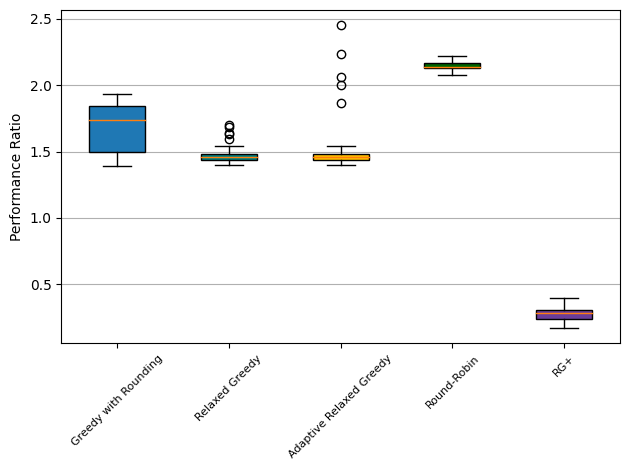

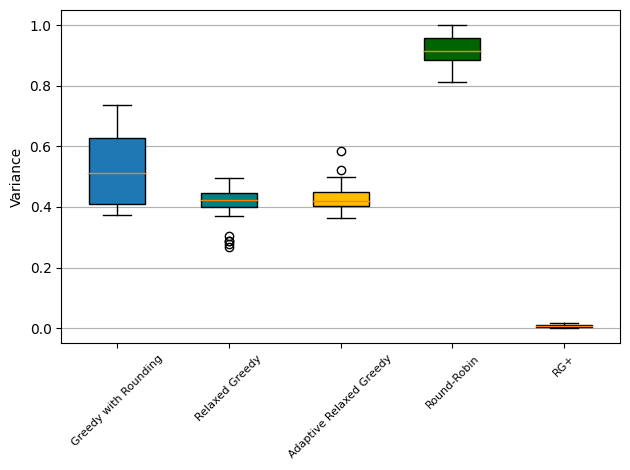

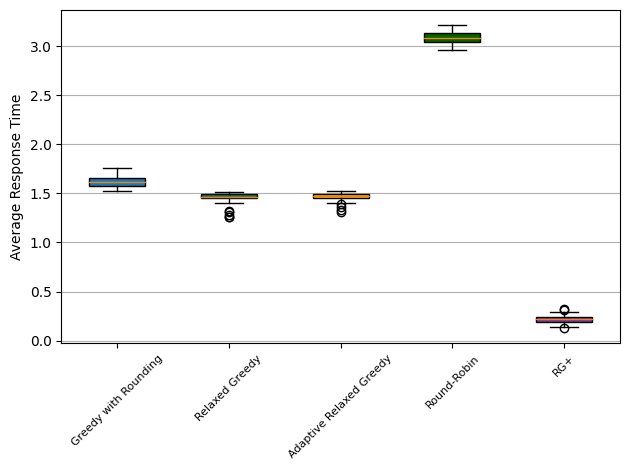

In [ ]:
#Release Time 0-1000
#Job Size Variance Scale 1
#Job Amount 2000
#Test Repeat 20 Times
#PredictError=1
#P_min_e_error=1
BatchSet=generateBatchLogJob(0,2000,1,2000,1,50)
batch_test(BatchSet,1,0.5)

In [ ]:
#Release Time 0-1000
#Job Size Variance Scale 1
#Job Amount 2000
#Test Repeat 20 Times
#PredictError=1
#P_min_e_error=1
BatchSet=generateBatchLogJob(0,2000,1,4000,1,100)
batch_test(BatchSet,1,0.5)

Performance ratio
[('Greedy with Rounding', [1.5217391304347827, 1.4675925925925926, 1.4774774774774775, 1.6055045871559632, 1.5392156862745099, 1.4454976303317535, 1.504950495049505, 1.6237623762376239, 1.427906976744186, 1.4803921568627452, 1.6188340807174888, 1.6238532110091743, 1.4864864864864864, 1.5807860262008733, 1.3896103896103895, 1.609375, 1.5458715596330275, 1.5317073170731708, 1.9275362318840579, 1.5467289719626167, 1.7366071428571428, 1.490909090909091, 1.6064814814814814, 1.4834123222748816, 1.6211453744493391, 1.8883720930232557, 1.5069124423963134, 1.8858447488584476, 1.6650246305418719, 1.4811320754716981, 1.5687203791469195, 1.456896551724138, 1.8447488584474885, 1.4908256880733946, 1.5622119815668203, 1.5518867924528301, 1.5161290322580645, 1.4672897196261683, 1.5115207373271888, 1.5260663507109005, 1.9289340101522843, 1.8839285714285714, 1.6, 1.5333333333333334, 1.5048543689320388, 1.9368932038834952, 2.0434782608695654, 1.5522388059701493, 1.4976303317535544, 1.63

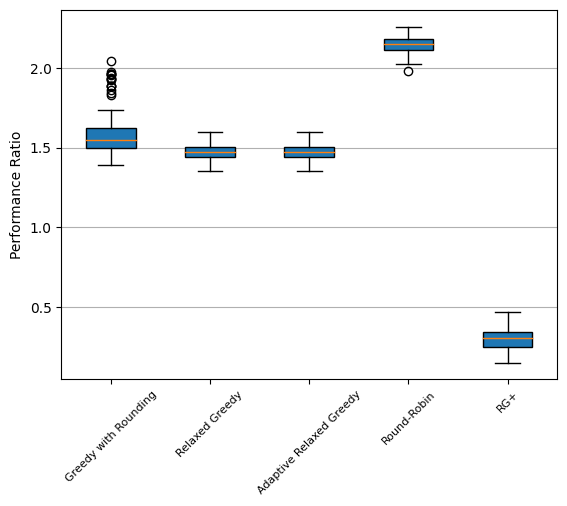

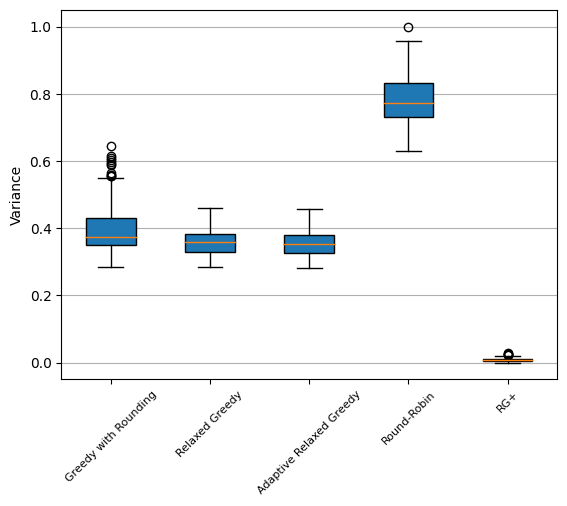

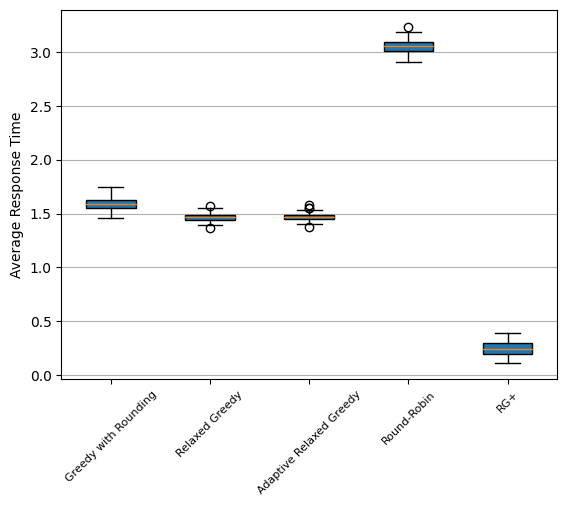

In [ ]:
#Release Time 0-1000
#Job Size Variance Scale 1
#Job Amount 2000
#Test Repeat 20 Times
#PredictError=1
#P_min_e_error=1
BatchSet=generateBatchLogJob(0,1000,1,1000,1,100)
batch_test(BatchSet,1,0.5)

Performance ratio
[('Greedy with Rounding', [2.5311143270622285, 1.6700288184438041, 2.5244444444444443, 1.749640287769784, 2.5165945165945165, 2.5464071856287425, 1.7710487444608567, 2.407514450867052, 2.4606413994169096, 1.7863501483679525, 2.472058823529412, 1.7566371681415929, 1.7730600292825769, 2.514792899408284, 1.719941348973607, 2.4465049928673324, 1.7533834586466166, 1.751453488372093, 1.750373692077728, 2.575402635431918, 1.7963246554364471, 2.533923303834808, 1.733931240657698, 2.527941176470588, 1.7437888198757765, 1.7965860597439545, 2.4963396778916547, 2.5543964232488823, 2.533033033033033, 1.7038123167155426, 2.451519536903039, 2.4817518248175183, 2.4949640287769785, 2.5242290748898677, 2.456681350954479, 2.4705014749262535, 2.4681159420289855, 2.445558739255014, 2.510355029585799, 2.55096011816839, 1.8172362555720654, 2.4415954415954415, 1.7564296520423601, 1.7828054298642535, 1.7613469985358712, 1.7356828193832599, 2.528888888888889, 1.783941605839416, 2.4943019943019

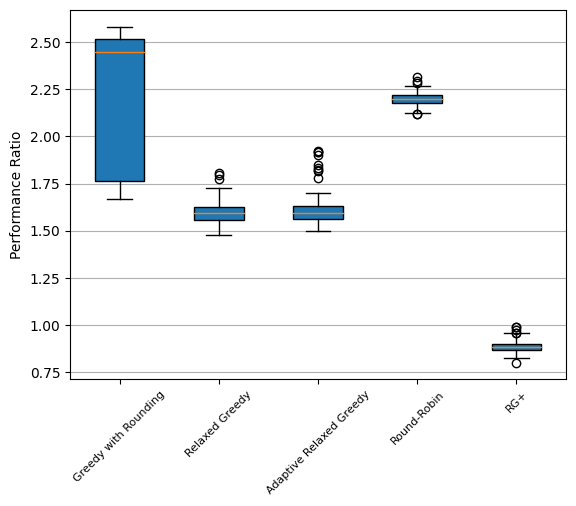

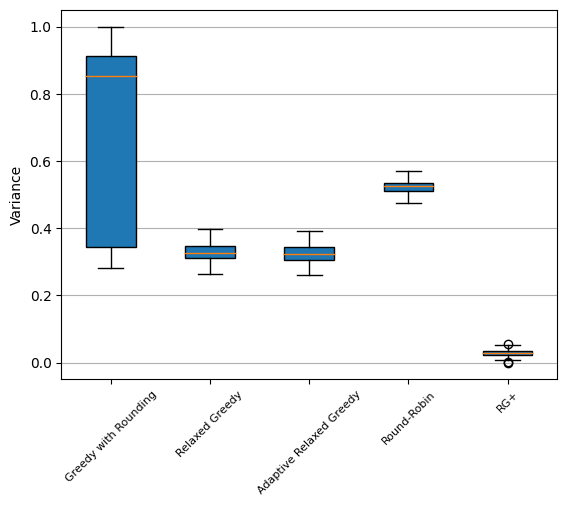

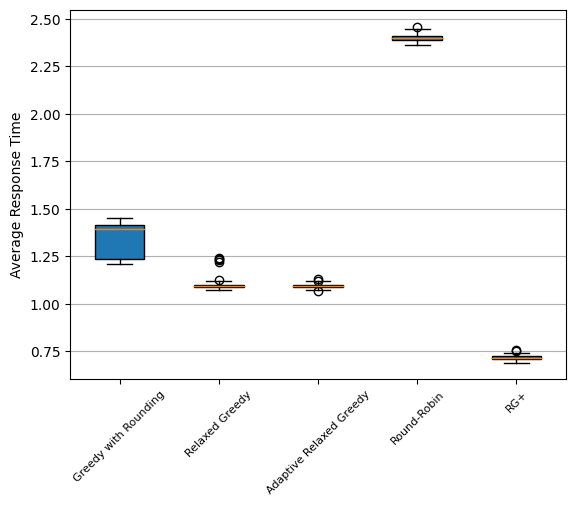

In [ ]:
#Release Time 0-1000
#Job Size Variance Scale 1
#Job Amount 2000
#Test Repeat 20 Times
#PredictError=1
#P_min_e_error=1
BatchSet=generateBatchLogJob(0,1000,1,2000,1,100)
batch_test(BatchSet,1,0.5)

Performance ratio
[('Greedy with Rounding', [1.6732851985559567, 1.8740875912408759, 1.7696737044145874, 1.4293577981651375, 1.8315217391304348, 1.7783687943262412, 1.8635514018691588, 1.6505376344086022, 1.7132867132867133, 1.8357142857142856, 1.490272373540856, 1.7748091603053435, 1.7648183556405355, 1.7783882783882783, 1.6734693877551021, 1.841897233201581, 1.7473498233215548, 1.7814685314685315, 1.8185255198487713, 1.819838056680162, 1.8051470588235294, 1.841549295774648, 1.7294776119402986, 1.7703180212014133, 1.7925233644859813, 1.7635658914728682, 1.5120967741935485, 1.464, 1.8755020080321285, 1.4479553903345725, 1.3847549909255898, 1.4875239923224568, 1.6865942028985508, 1.4382022471910112, 1.7287234042553192, 1.8176470588235294, 1.4315196998123827, 1.4708029197080292, 1.4616788321167884, 1.905123339658444, 1.4212523719165084, 1.71160409556314, 1.8330134357005758, 1.8195211786372008, 1.685288640595903, 1.7078260869565218, 1.661590524534687, 1.701657458563536, 1.7323420074349443

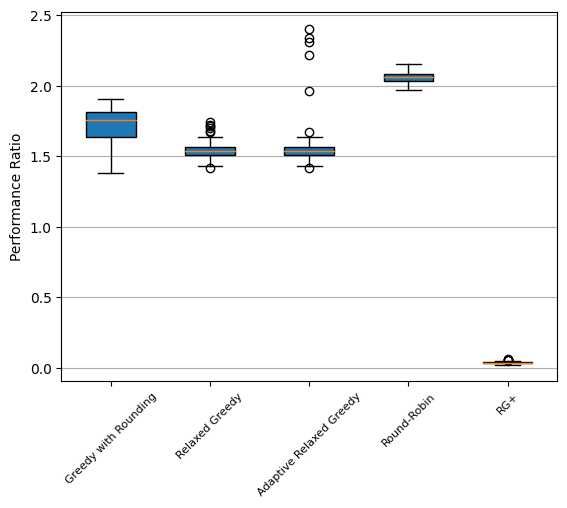

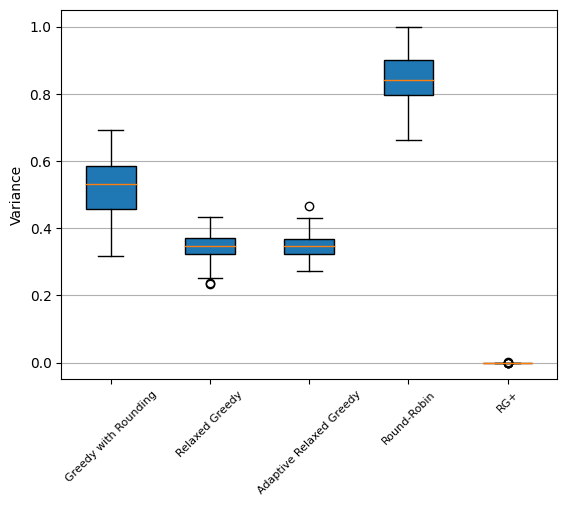

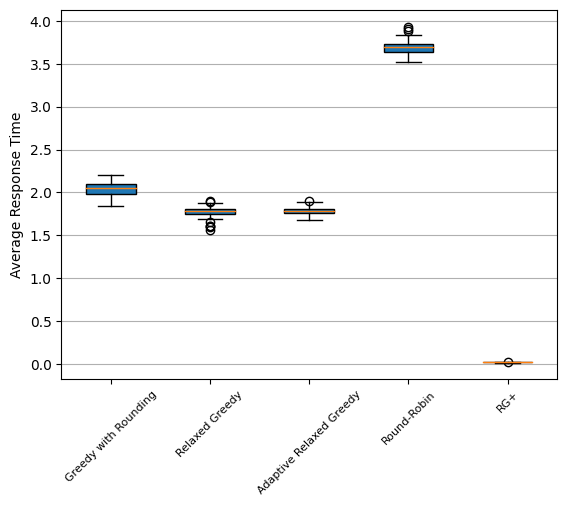

In [ ]:
#Release Time 0-1000
#Job Size Variance Scale 1
#Job Amount 2000
#Test Repeat 20 Times
#PredictError=1
#P_min_e_error=1
BatchSet=generateBatchLogJob(0,5000,1,4000,1,100)
batch_test(BatchSet,1,0.5)

In [ ]:
#Release Time 0-1000
#Job Size Variance Scale 1
#Job Amount 2000
#Test Repeat 20 Times
#PredictError=1
#P_min_e_error=1
BatchSet=generateBatchLogJob(0,5000,1,1000,1,10)
batch_test(BatchSet,1,0.5)

KeyboardInterrupt: ignored

In [ ]:
#Release Time 0-1000
#Job Size Variance Scale 1
#Job Amount 2000
#Test Repeat 20 Times
#PredictError=1
#P_min_e_error=1
BatchSet=generateBatchLogJob(0,1000,1,10000,1,100)
batch_test(BatchSet,1,0.5)

In [ ]:
#Release Time 0-1000
#Job Size Variance Scale 1
#Job Amount 2000
#Test Repeat 20 Times
#PredictError=1
#P_min_e_error=1
BatchSet=generateBatchLogJob(0,1000,1,8000,1,10)
batch_test(BatchSet,1,0.7)

In [ ]:
#Release Time 0-1000
#Job Size Variance Scale 1
#Job Amount 2000
#Test Repeat 20 Times
#PredictError=1
#P_min_e_error=1
BatchSet=generateBatchLogJob(0,1000,1,8000,1,10)
batch_test(BatchSet,1,0.8)

Performance ratio
[('Greedy with Rounding', [5.25, 15.0, 6.0, 1.8571428571428572, 3.0, 6.5, 5.0, 2.0, 13.0, 22.0, 21.0, 11.0, 3.25, 13.0, 15.0, 2.75, 6.0, 7.5, 8.5, 14.0]), ('Relaxed Greedy', [4.625, 12.5, 6.0, 2.357142857142857, 3.125, 5.25, 5.0, 2.0, 12.5, 21.5, 27.0, 10.0, 2.875, 13.0, 11.0, 3.0, 5.25, 8.25, 7.5, 15.0]), ('Adaptive Relaxed Greedy', [4.625, 12.5, 6.0, 2.357142857142857, 3.125, 5.25, 5.0, 2.0, 12.5, 21.5, 27.0, 10.0, 2.875, 13.0, 11.0, 2.875, 5.0, 8.25, 7.5, 15.0]), ('Round-Robin', [5.425516933803934, 15.767462964020183, 7.340220461335093, 1.6598307241920338, 3.7414560090745965, 7.160083915681753, 5.039153141943018, 2.6250590510079066, 15.54340339469286, 24.174129826778767, 26.42332141231134, 10.123002221764182, 3.2977767936545916, 13.86059847119742, 14.303823031340016, 3.0386841777055906, 5.673699274081912, 8.85149015060017, 9.934271556823944, 13.74443172253541]), ('RG+', [1.5833333333333357, 3.833333333333144, 2.2499999999999716, 0.9459245566247991, 1.20570439758391

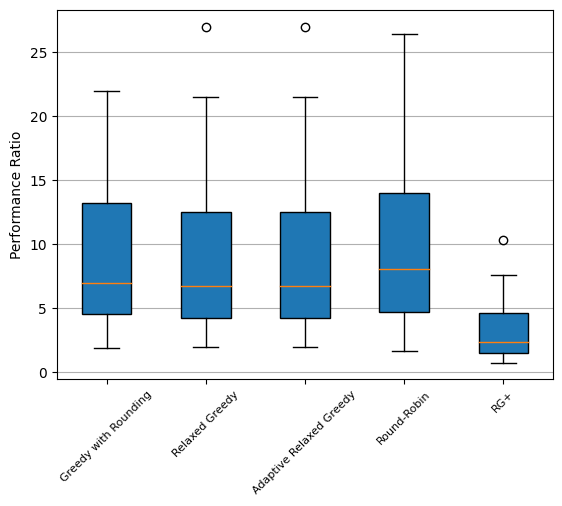

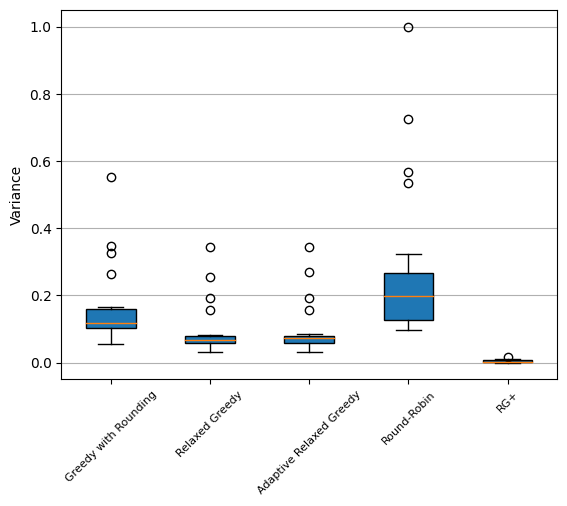

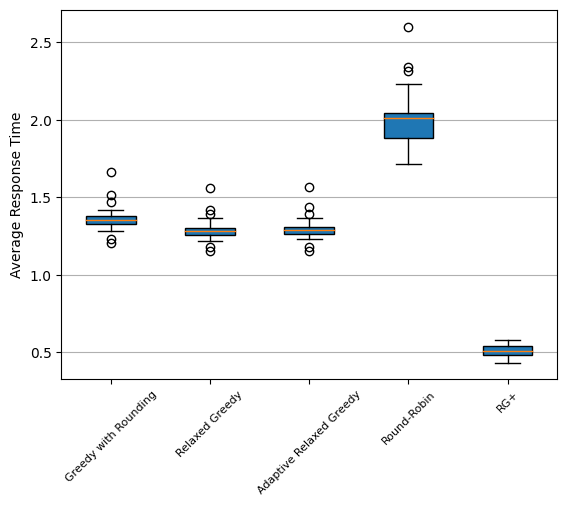

In [ ]:
#Release Time 0-1000
#Job Size Variance Scale 1
#Job Amount 2000
#Test Repeat 20 Times
#PredictError=1
#P_min_e_error=1
BatchSet=generateBatchLogJob(0,1000,1,500,1,20)
batch_test(BatchSet,1,0.5)

Performance ratio
[('Greedy with Rounding', [3.1758241758241756, 2.908450704225352, 2.9895833333333335, 2.9241877256317688, 3.982394366197183, 3.0921985815602837, 3.120879120879121, 2.7118055555555554, 2.927007299270073, 3.098901098901099, 2.9190140845070425, 2.9, 2.741007194244604, 2.6903914590747333, 4.138686131386861, 2.769230769230769, 2.875886524822695, 4.253623188405797, 2.859848484848485, 3.152173913043478]), ('Relaxed Greedy', [4.083028083028084, 4.0, 3.846064814814815, 3.966305655836342, 3.317781690140845, 3.9030732860520096, 3.1227106227106227, 3.1041666666666665, 3.4315693430656933, 3.07967032967033, 4.039906103286385, 4.2061728395061735, 3.303956834532374, 3.2330960854092528, 3.2855839416058394, 4.323565323565323, 4.540189125295508, 3.027173913043478, 3.115530303030303, 3.198369565217391]), ('Adaptive Relaxed Greedy', [4.083028083028084, 4.0, 3.846064814814815, 3.966305655836342, 3.317781690140845, 3.9030732860520096, 3.1227106227106227, 3.1041666666666665, 3.43156934306569

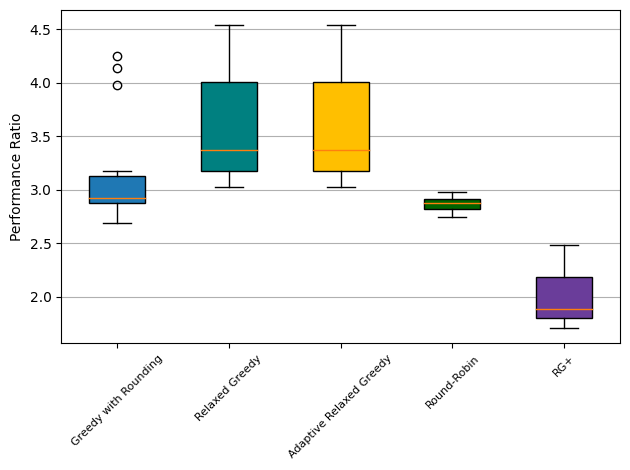

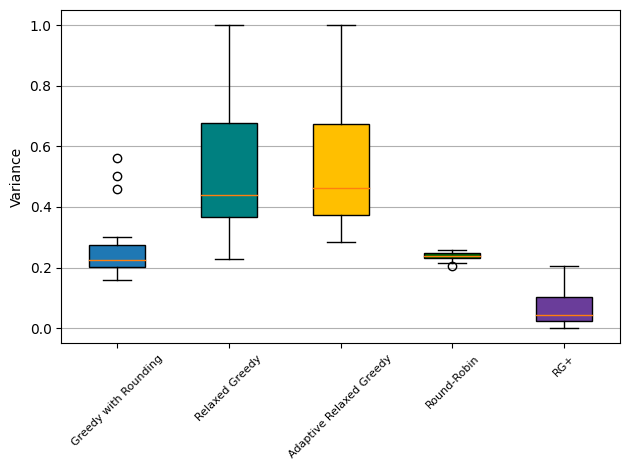

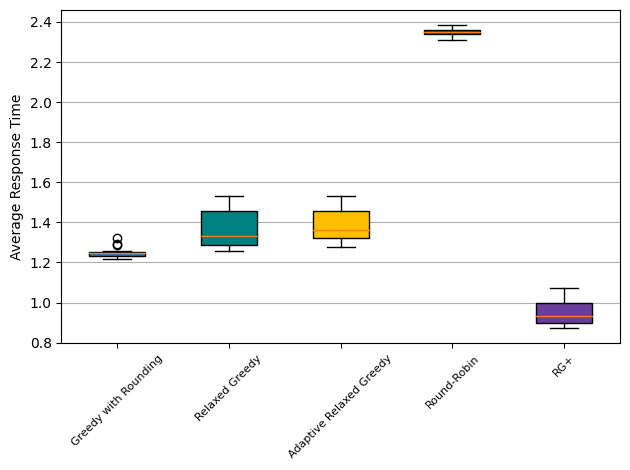

In [ ]:
#Release Time 0-1000
#Job Size Variance Scale 1
#Job Amount 2000
#Test Repeat 20 Times
#PredictError=1
#P_min_e_error=1
BatchSet=generateBatchLogJob(0,1000,4,1000,1,20)
batch_test(BatchSet,1,0.5)

Performance ratio
[('Greedy with Rounding', [2.450074515648286, 1.7667638483965014, 1.7515060240963856, 1.7680945347119645, 1.7821637426900585]), ('Relaxed Greedy', [1.6050670640834575, 1.5685131195335278, 1.598644578313253, 1.601181683899557, 1.5380116959064327]), ('Adaptive Relaxed Greedy', [1.6050670640834575, 1.5685131195335278, 1.598644578313253, 1.8685376661742983, 1.5380116959064327]), ('Round-Robin', [2.233683153542023, 2.178223704542077, 2.2434993360790374, 2.202190418557394, 2.172474247943704]), ('RG+', [0.9012713801599707, 0.8676405406193622, 0.8907242791800281, 0.8655936158227087, 0.8592826417029734])]
variance
[('Greedy with Rounding', [1.0, 0.39446072615022126, 0.3255458893079972, 0.3844294599002846, 0.3932597262757439]), ('Relaxed Greedy', [0.3721364895449714, 0.3807463996822724, 0.32613853864080056, 0.35183385002032413, 0.3494546376222542]), ('Adaptive Relaxed Greedy', [0.35377295567992256, 0.3795420504230865, 0.3235761298684723, 0.36076464941216996, 0.3359317901716147]

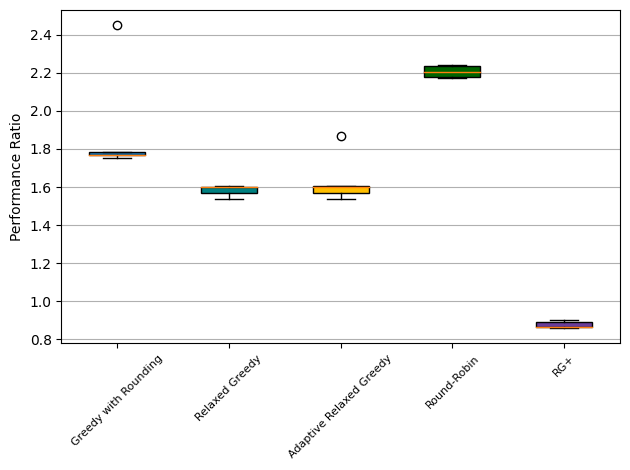

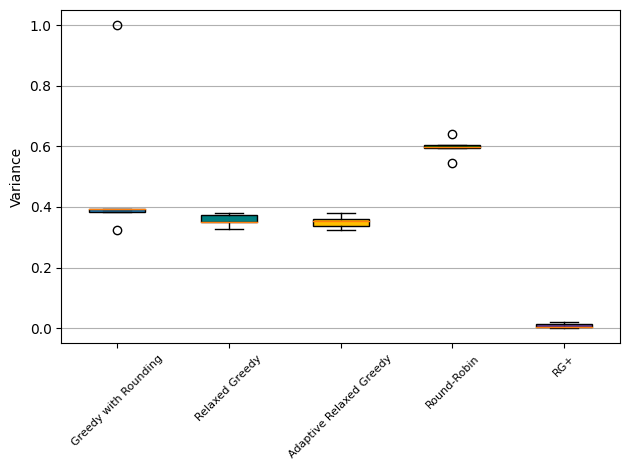

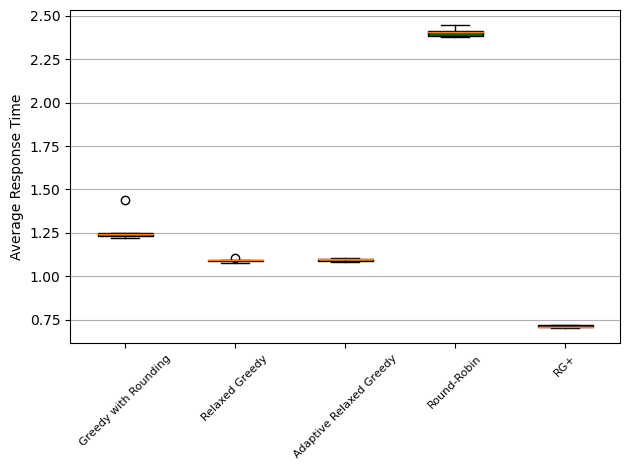

In [ ]:
#Release Time 0-1000
#Job Size Variance Scale 1
#Job Amount 2000
#Test Repeat 20 Times
#PredictError=1
#P_min_e_error=1
BatchSet=generateBatchLogJob(0,1000,1,2000,1,5)
batch_test(BatchSet,1,0.5)

Performance ratio
[('Greedy with Rounding', [2.51171875, 2.3122529644268774, 2.6463878326996197, 1.5166666666666666, 1.5977822580645162, 2.49609375, 2.475, 1.500965250965251, 1.5620300751879699, 2.5461847389558234, 1.4919354838709677, 1.6108870967741935, 1.4035580524344569, 2.6885245901639343, 2.7041666666666666, 2.614785992217899, 2.653386454183267, 2.47265625, 2.608058608058608, 1.5368217054263567]), ('Relaxed Greedy', [2.1171875, 2.251646903820817, 1.946768060836502, 2.0313725490196077, 2.129032258064516, 1.9791666666666667, 2.218055555555556, 1.9948519948519947, 2.083959899749374, 2.1954484605087012, 1.9502688172043012, 2.120967741935484, 1.8689138576779025, 2.1092896174863385, 2.1375, 1.9559014267185475, 2.0199203187250996, 2.0859375, 1.9328449328449326, 2.0478036175710597]), ('Adaptive Relaxed Greedy', [2.564453125, 2.251646903820817, 2.011406844106464, 2.0313725490196077, 2.129032258064516, 2.607421875, 2.218055555555556, 2.106177606177606, 2.1390977443609023, 2.1954484605087012

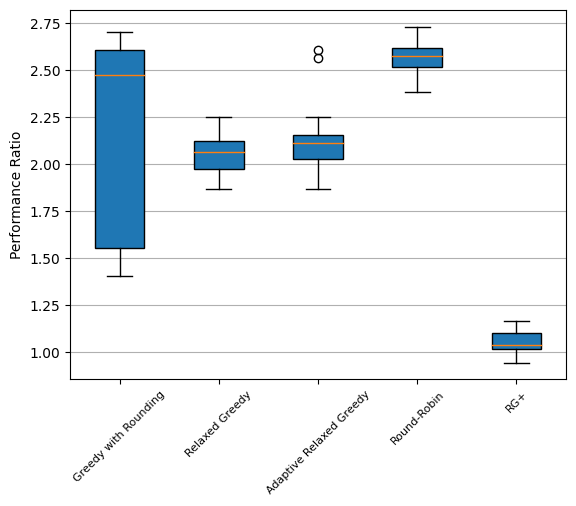

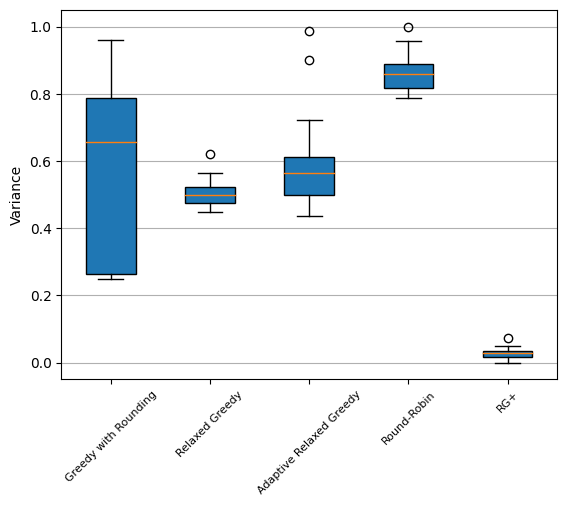

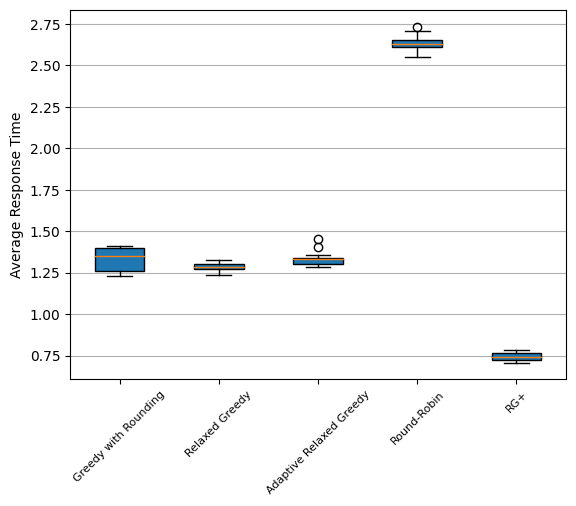

In [ ]:
BatchSet=generateBatchLogJob(0,1000,2,1000,1,20)
batch_test(BatchSet,1,0.5)

Performance ratio
[('Greedy with Rounding', [2.781569965870307, 2.772241992882562, 2.973384030418251, 2.5543478260869565, 3.20817843866171, 2.495970695970696, 2.5946360153256705, 2.7649122807017545, 2.9130434782608696, 2.8345588235294117, 3.037313432835821, 4.254612546125461, 2.98828125, 2.5354609929078014, 2.749063670411985, 2.7509025270758123, 2.9483394833948338, 4.120567375886525, 2.8296296296296295, 2.975177304964539]), ('Relaxed Greedy', [3.1680887372013653, 3.1512455516014235, 3.2927756653992395, 3.261775362318841, 3.328996282527881, 4.188034188034187, 4.459770114942529, 3.977777777777778, 4.239130434782608, 3.2950367647058822, 3.0904850746268657, 3.2186346863468636, 3.2529296875, 3.1808510638297873, 3.4428838951310863, 3.4070397111913358, 4.157441574415745, 3.2065602836879434, 4.393827160493827, 3.149822695035461]), ('Adaptive Relaxed Greedy', [3.1680887372013653, 3.1512455516014235, 3.2927756653992395, 3.261775362318841, 3.328996282527881, 4.188034188034187, 4.459770114942529, 

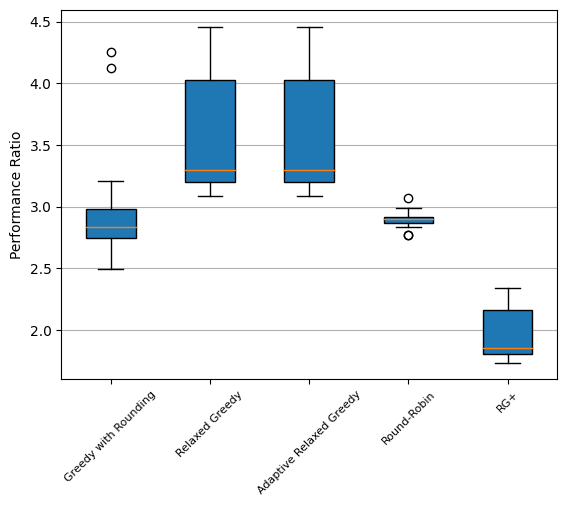

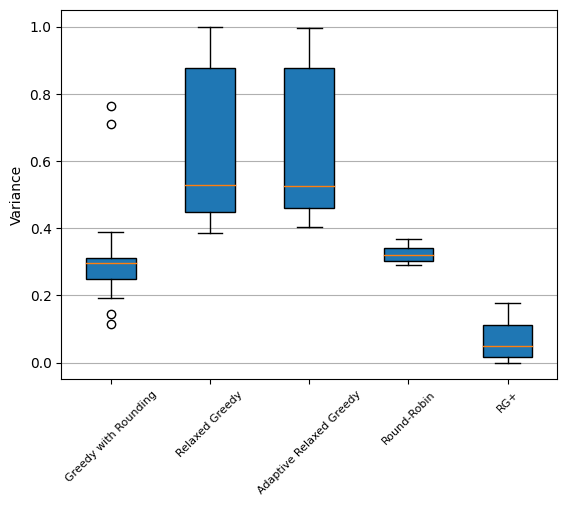

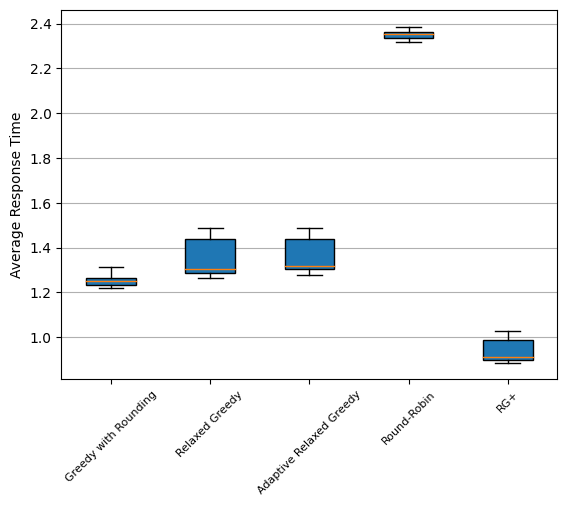

In [ ]:
BatchSet=generateBatchLogJob(0,1000,4,1000,1,20)
batch_test(BatchSet,1,0.5)

Performance ratio
[('Greedy with Rounding', [3.3194444444444446, 3.5584415584415585, 3.3664383561643834, 3.2797202797202796, 3.5824915824915826, 4.874149659863946, 5.105263157894737, 4.823920265780731, 3.4652777777777777, 3.2857142857142856, 3.7966101694915255, 3.4713804713804715, 3.7167832167832167, 5.419928825622776, 5.017241379310345, 3.511713367018833, 3.23875, 3.630508474576271, 3.7869415807560136, 3.5464285714285713]), ('Relaxed Greedy', [5.363194444444444, 4.924025974025974, 5.252054794520547, 5.027972027972028, 4.853198653198653, 5.030612244897959, 4.725657894736842, 4.878405315614618, 5.375, 5.081632653061225, 4.742372881355932, 5.169023569023569, 5.187412587412587, 4.186239620403321, 5.242068965517242, 6.143086816720257, 5.223333333333334, 5.056271186440678, 4.9876288659793815, 5.253571428571429]), ('Adaptive Relaxed Greedy', [5.363194444444444, 4.924025974025974, 5.252054794520547, 5.027972027972028, 4.853198653198653, 5.030612244897959, 4.725657894736842, 4.878405315614618,

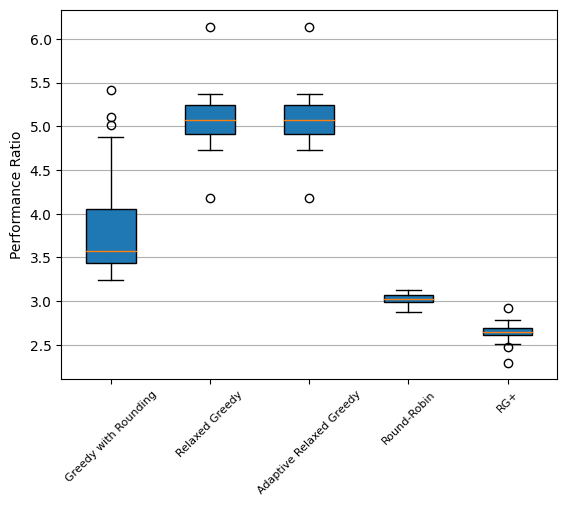

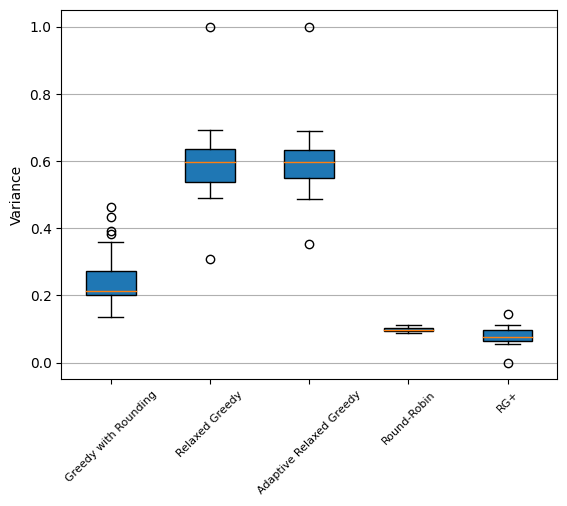

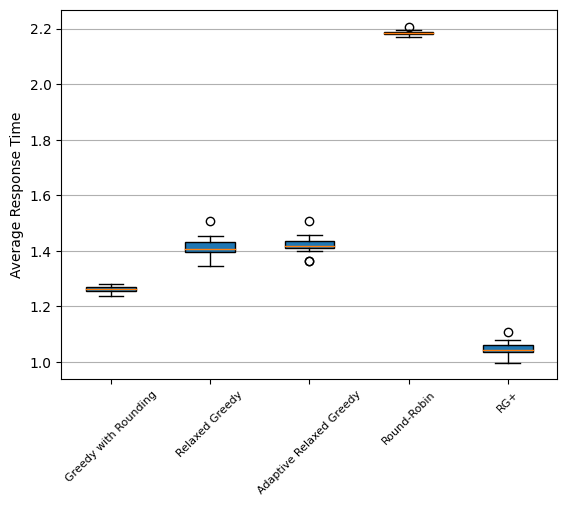

In [ ]:
BatchSet=generateBatchLogJob(0,1000,8,1000,1,20)
batch_test(BatchSet,1,0.5)

Performance ratio
[('Greedy with Rounding', [6.56551724137931, 5.283586720446788, 5.728187919463087, 5.510416666666667, 4.466721672167217, 4.505575117370892, 4.324716816729596, 5.527027027027027, 5.958620689655173, 4.829844497607655, 4.5247003800058465, 4.999348534201954, 6.73841059602649, 4.422036823935557, 4.6493949736270554, 5.816666666666666, 4.8936716993254095, 5.17542662116041, 4.557657107992679, 4.482866043613707]), ('Relaxed Greedy', [7.883743842364532, 9.402730375426621, 7.423777564717162, 7.557043650793651, 7.513908533710514, 7.5241448692152915, 7.246006389776358, 7.406853281853282, 7.99704433497537, 7.612781954887218, 6.2792834175470835, 8.284473398479914, 6.479718543046357, 7.945675105485233, 7.365675280351049, 7.29, 7.803129732458354, 8.667804323094424, 7.142857142857142, 7.039608366711171]), ('Adaptive Relaxed Greedy', [7.883743842364532, 9.402730375426621, 7.423777564717162, 7.557043650793651, 7.513908533710514, 7.5241448692152915, 7.246006389776358, 7.856981981981981, 7

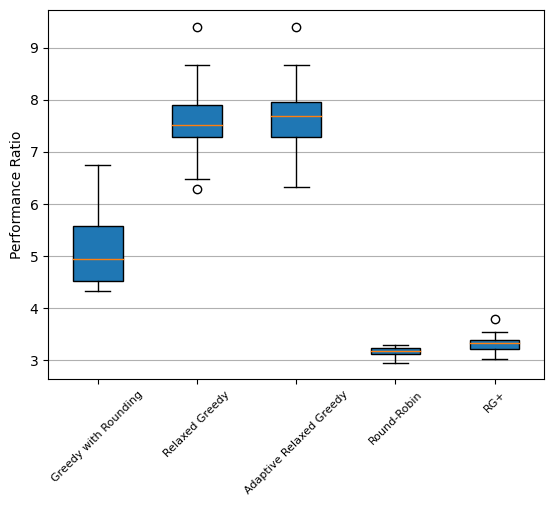

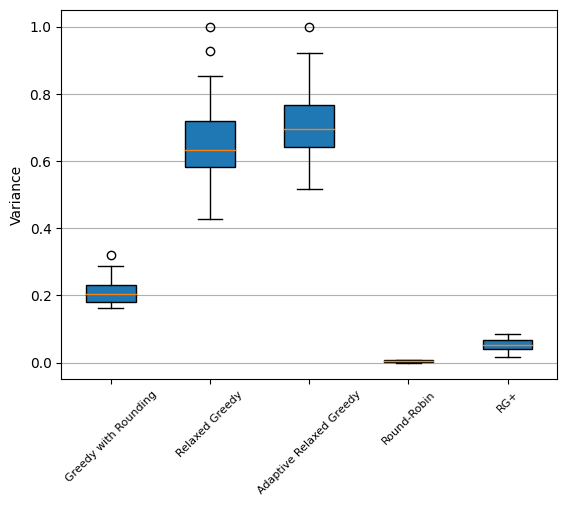

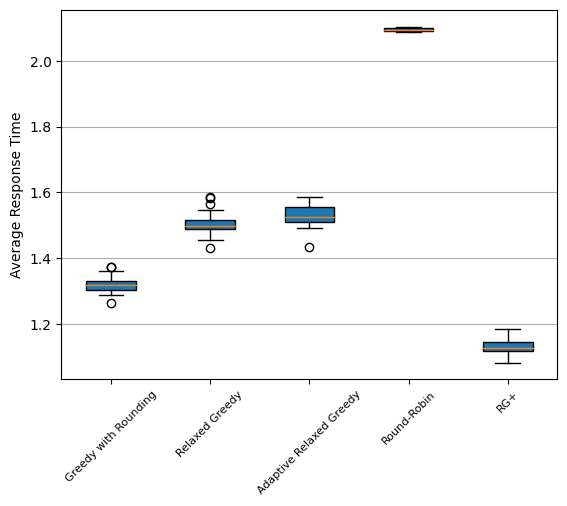

In [ ]:
BatchSet=generateBatchLogJob(0,1000,16,1000,1,20)
batch_test(BatchSet,1,0.5)

Performance ratio
[('Greedy with Rounding', [3.0, 2.0, 3.0, 2.5, 5.0, 7.0, 4.0, 5.0, 3.0, 6.0, 3.0, 4.0, 5.0, 6.0, 2.3333333333333335, 3.0, 3.0, 2.0, 6.0, 5.0]), ('Relaxed Greedy', [3.0, 2.0, 3.0, 2.5, 5.0, 4.0, 4.0, 5.0, 3.0, 6.0, 3.0, 4.0, 5.0, 3.0, 2.3333333333333335, 3.0, 3.0, 2.0, 6.0, 5.0]), ('Adaptive Relaxed Greedy', [3.0, 2.0, 3.0, 2.5, 5.0, 4.0, 4.0, 5.0, 3.0, 6.0, 3.0, 4.0, 5.0, 3.0, 2.3333333333333335, 3.0, 3.0, 2.0, 6.0, 5.0]), ('Round-Robin', [3.0, 2.0, 2.5, 2.5, 3.0, 3.6666666666666288, 3.0, 3.0, 2.5, 2.5, 2.0, 2.0, 2.5, 3.0, 3.0, 3.0, 2.5, 3.0, 2.5, 3.0]), ('RG+', [1.6666666666666572, 1.3333333333333286, 1.6666666666666288, 1.3333333333333428, 2.6666666666666288, 4.0, 2.3333333333333286, 3.0, 1.6666666666666288, 3.3333333333332575, 1.6666666666667425, 2.3333333333333144, 2.6666666666666288, 1.9999999999998863, 1.5555555555555525, 1.6666666666666572, 1.6666666666666288, 1.3333333333333712, 3.3333333333332575, 3.3999999999999773])]
variance
[('Greedy with Rounding', [0.13

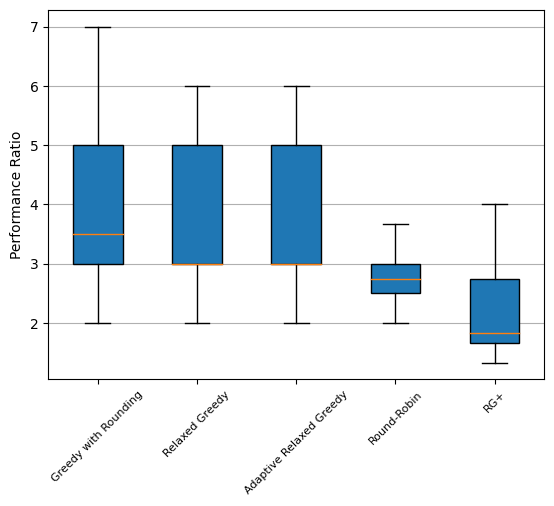

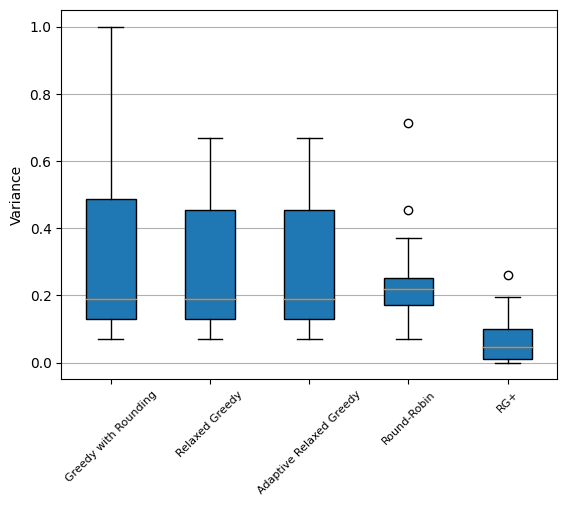

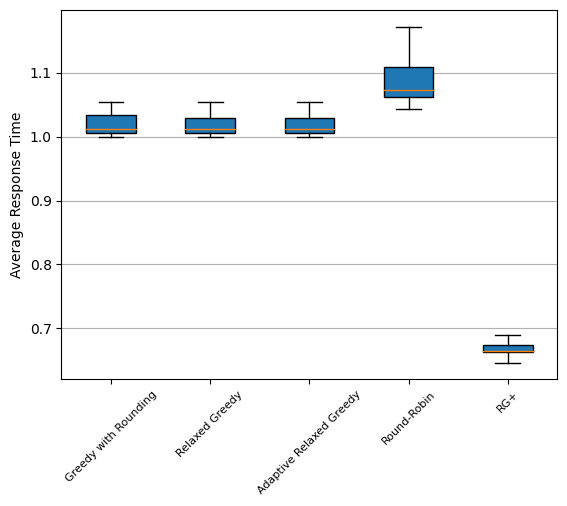

In [ ]:
BatchSet=generateBatchLogJob(0,1000,1,100,1,20)
batch_test(BatchSet,1,0.5)

Performance ratio
[('Greedy with Rounding', [12.0, 28.0, 4.333333333333333, 2.75, 12.0, 3.6, 13.0, 16.0, 14.0, 15.0, 14.0, 5.0, 12.0, 7.0, 6.0, 13.0, 16.0, 22.0, 15.0, 2.6]), ('Relaxed Greedy', [12.5, 22.5, 3.3333333333333335, 2.625, 10.0, 3.5, 9.0, 12.0, 12.0, 12.0, 14.0, 3.0, 10.0, 6.0, 5.0, 12.5, 16.0, 24.0, 14.0, 2.4]), ('Adaptive Relaxed Greedy', [12.5, 22.5, 3.3333333333333335, 2.625, 10.0, 3.5, 9.0, 12.0, 12.0, 12.0, 14.0, 3.0, 10.0, 6.0, 5.0, 12.5, 16.0, 23.0, 14.0, 2.4]), ('Round-Robin', [13.049234841862699, 21.282802572151127, 4.061848046246799, 3.0743455478304043, 11.77578192551249, 4.5227283868953405, 12.687724982117686, 17.18925746919888, 16.04773784525605, 14.867054729549864, 13.264438960693724, 4.718434065934086, 12.539242981044936, 7.36136422095052, 6.2625076022170605, 13.772051855071368, 18.829886915692725, 23.669432234349983, 16.612610977906172, 2.8612515944373085]), ('RG+', [6.117687405801917, 5.5, 1.5641099275886698, 1.3478224622788417, 4.487816457047273, 1.06213732

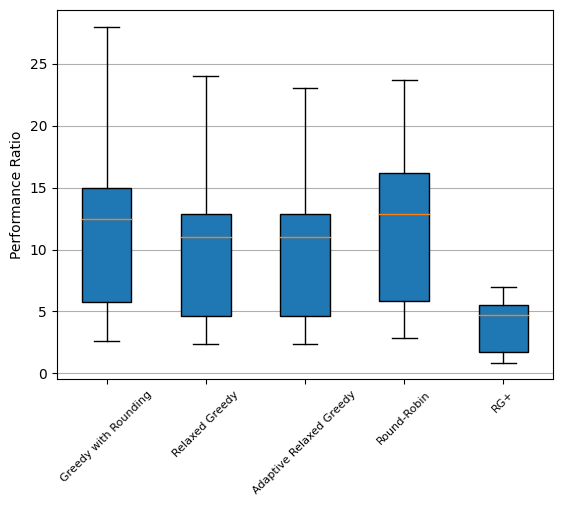

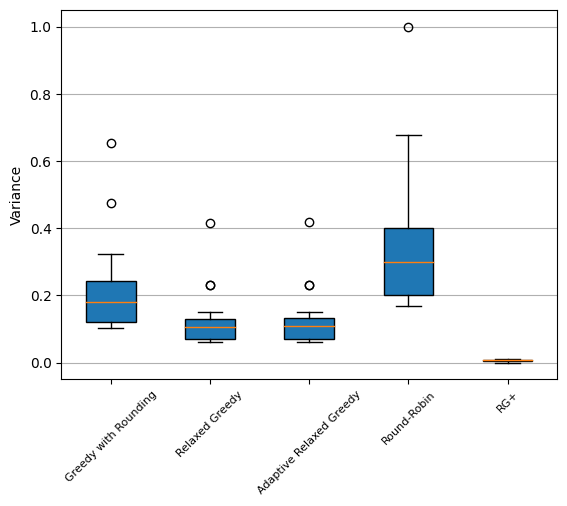

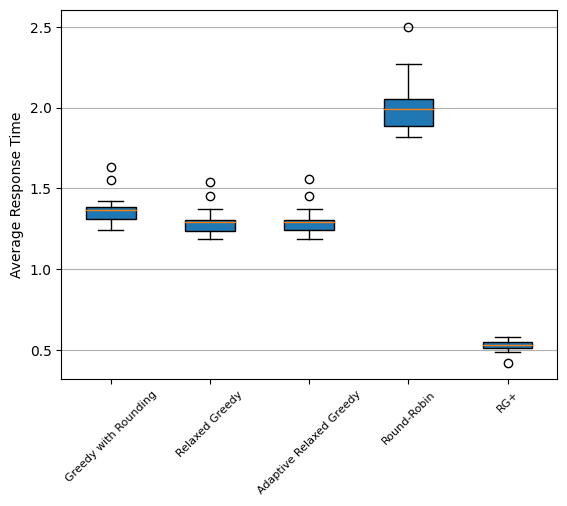

In [ ]:
BatchSet=generateBatchLogJob(0,1000,1,500,1,20)
batch_test(BatchSet,1,0.5)

Performance ratio
[('Greedy with Rounding', [1.4218009478672986, 1.477832512315271, 1.5265700483091786, 1.8423423423423424, 1.7402597402597402, 1.5022222222222221, 1.8790697674418604, 1.5538461538461539, 1.880184331797235, 1.9024390243902438, 1.4951923076923077, 1.4774774774774775, 1.6354679802955665, 1.5097087378640777, 1.4476190476190476, 1.4611650485436893, 1.54337899543379, 1.8803827751196172, 1.4976076555023923, 1.5612244897959184]), ('Relaxed Greedy', [1.40521327014218, 1.4827586206896552, 1.5845410628019323, 1.5247747747747749, 1.4307359307359306, 1.46, 1.4883720930232558, 1.5743589743589743, 1.467741935483871, 1.4780487804878049, 1.4350961538461537, 1.4324324324324325, 1.4334975369458127, 1.6019417475728155, 1.4666666666666666, 1.4854368932038835, 1.3744292237442923, 1.5382775119617225, 1.4952153110047848, 1.4566326530612246]), ('Adaptive Relaxed Greedy', [1.40521327014218, 1.4827586206896552, 1.5845410628019323, 1.5247747747747749, 1.4307359307359306, 1.46, 1.4883720930232558,

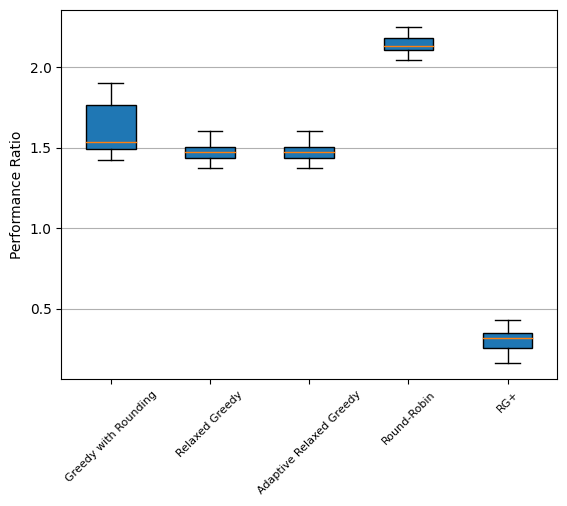

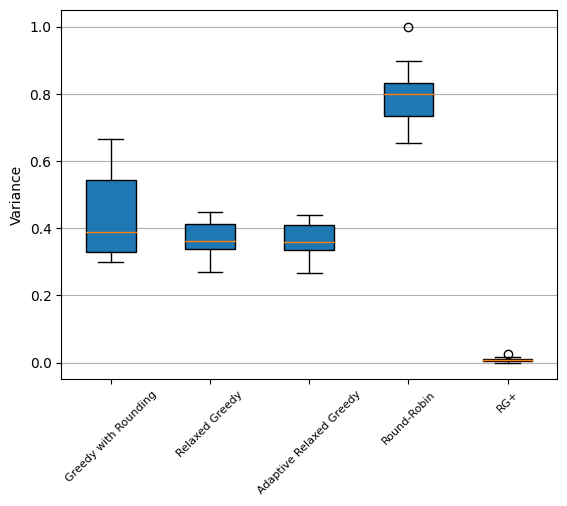

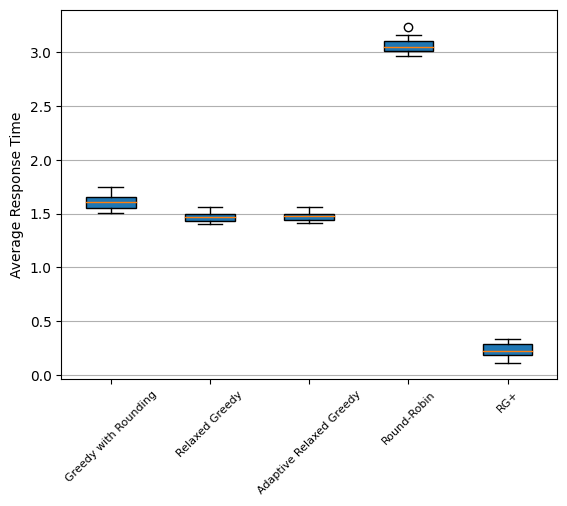

In [ ]:
BatchSet=generateBatchLogJob(0,1000,1,1000,1,20)
batch_test(BatchSet,1,0.5)

Performance ratio
[('Greedy with Rounding', [1.8845419847328244, 1.4863813229571985, 1.7811634349030472, 1.5076775431861804, 1.8861244019138756]), ('Relaxed Greedy', [1.9136450381679388, 1.997568093385214, 1.9353647276084949, 1.916506717850288, 1.998086124401914]), ('Adaptive Relaxed Greedy', [3.553435114503817, 3.9815175097276265, 1.9353647276084949, 1.916506717850288, 1.998086124401914]), ('Round-Robin', [2.150496032857702, 2.154551284261565, 2.140927481117837, 2.2111790670949807, 2.1854676929422556]), ('RG+', [0.32129802253004824, 0.2936896506803125, 0.40664633366877717, 0.39389244090933284, 0.4307136512695417])]
variance
[('Greedy with Rounding', [0.6408776479250434, 0.3886242931796283, 0.6071384833642199, 0.4093483273834377, 0.6196124421536846]), ('Relaxed Greedy', [0.524159753247149, 0.4796514454334047, 0.607227431220655, 0.5272297799874222, 0.5708761151109891]), ('Adaptive Relaxed Greedy', [0.7734270027046888, 0.8022080616721927, 0.5959198086567419, 0.5237756019692604, 0.5636289

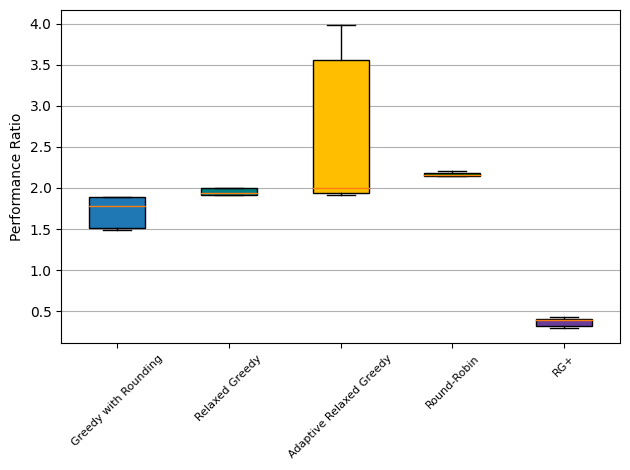

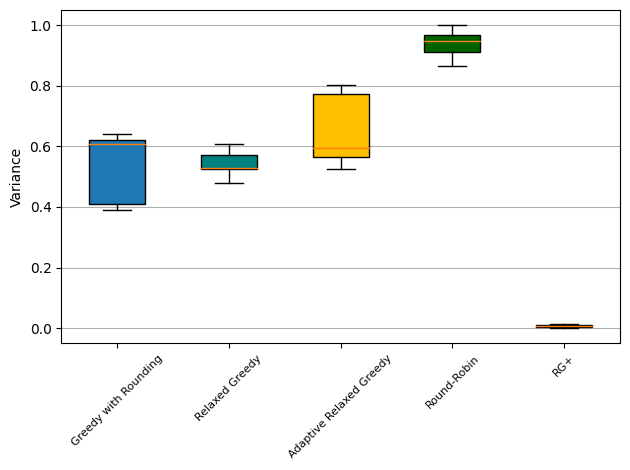

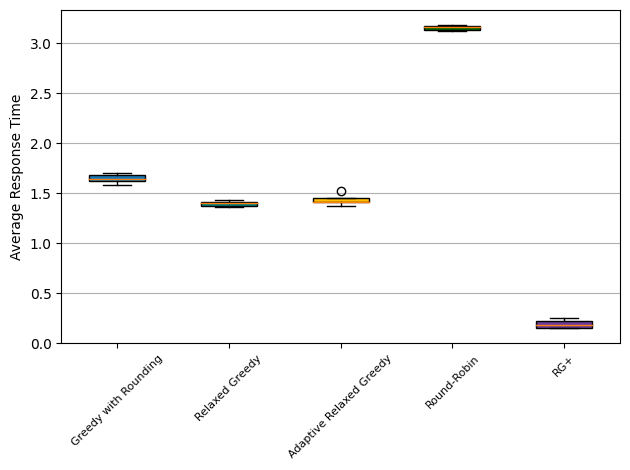

In [ ]:
BatchSet=generateBatchLogJob(0,5000,1,5000,2,5)
batch_test(BatchSet,1,0.5)

Performance ratio
[('Greedy with Rounding', [1.4409302325581395, 1.9287833827893175, 1.9119373776908024, 1.8780019212295869, 1.8436018957345972]), ('Relaxed Greedy', [4.908837209302326, 4.824925816023739, 5.1682974559686885, 5.068203650336216, 5.265402843601896]), ('Adaptive Relaxed Greedy', [4.77953488372093, 4.824925816023739, 5.011741682974559, 5.007684918347743, 5.074881516587678]), ('Round-Robin', [2.145819052120222, 2.168270779307292, 2.1961019561706236, 2.1818360418273266, 2.1267338554425814]), ('RG+', [0.5281267111183268, 0.4149053057653293, 0.5829031329021825, 0.5503145074424718, 0.4203996252800008])]
variance
[('Greedy with Rounding', [0.09789848209193665, 0.13389160431739333, 0.14087952227716563, 0.14838781853374894, 0.1457066252240872]), ('Relaxed Greedy', [0.9830762794973619, 0.9451835986894506, 0.9799130153256699, 0.9923421784194473, 0.849047581716901]), ('Adaptive Relaxed Greedy', [0.9907833104048811, 0.9449166099486015, 0.9886731536310491, 1.0, 0.9139081853373267]), ('R

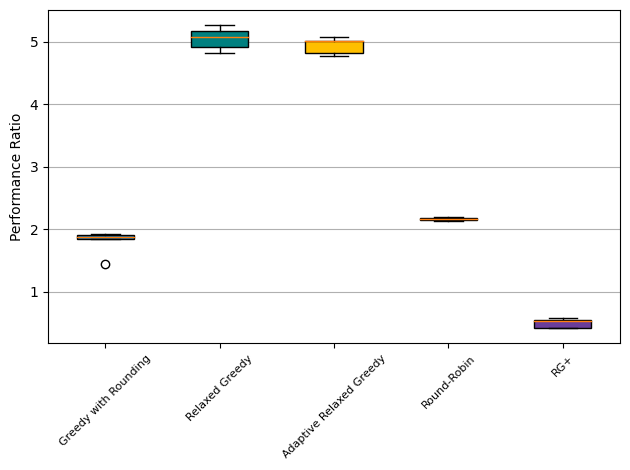

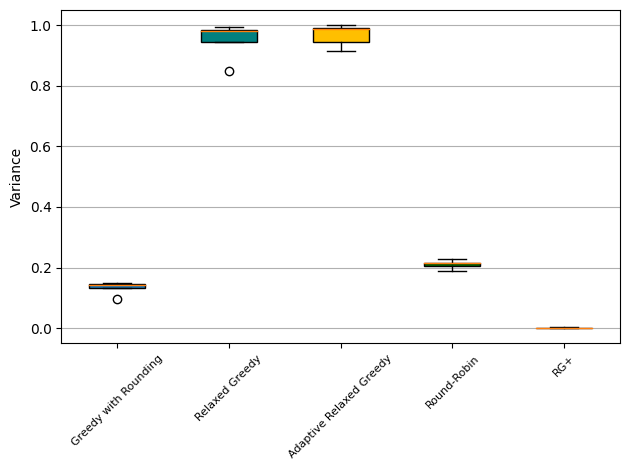

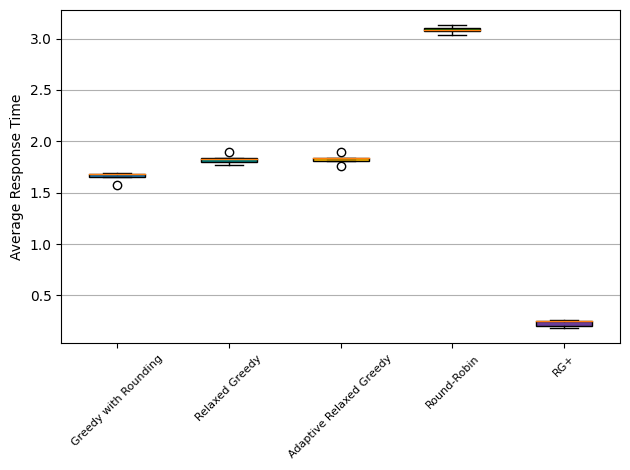

In [ ]:
BatchSet=generateBatchLogJob(0,5000,1,5000,16,5)
batch_test(BatchSet,1,0.5)

Performance ratio
[('Greedy with Rounding', [1.7685589519650655, 1.5229357798165137, 1.455813953488372, 1.4887892376681615, 1.6702127659574468, 1.6526315789473685, 1.4444444444444444, 1.4375, 1.7155963302752293, 1.5093457943925233, 1.7637130801687764, 1.92, 1.4851485148514851, 1.6255924170616114, 1.8826530612244898, 1.489795918367347, 1.7512437810945274, 1.5023696682464456, 1.8159203980099503, 1.509433962264151]), ('Relaxed Greedy', [1.5109170305676856, 1.341743119266055, 1.3906976744186046, 1.468609865470852, 1.4574468085106382, 1.486842105263158, 1.4259259259259258, 1.5223214285714286, 1.4655963302752293, 1.4345794392523366, 1.3839662447257384, 1.555, 1.4702970297029703, 1.504739336492891, 1.7704081632653061, 1.5765306122448979, 1.5597014925373134, 1.4407582938388626, 1.5671641791044777, 1.4599056603773586]), ('Adaptive Relaxed Greedy', [1.5109170305676856, 1.341743119266055, 1.3906976744186046, 1.468609865470852, 1.4574468085106382, 1.486842105263158, 1.4259259259259258, 1.522321428

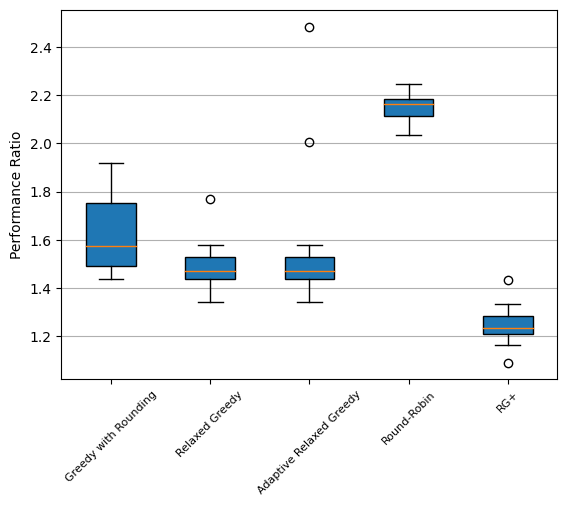

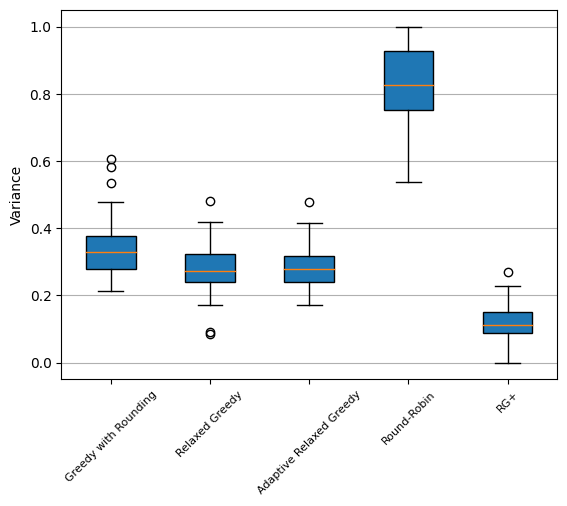

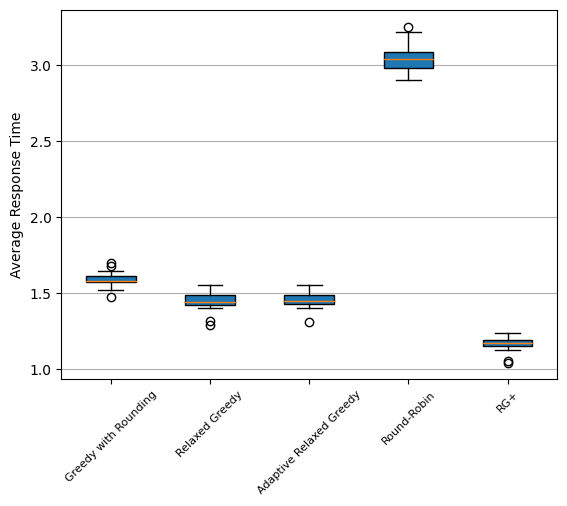

In [ ]:
BatchSet=generateBatchLogJob(0,1000,1,1000,1,20)
batch_test(BatchSet,1,0.1)

Performance ratio
[('Greedy with Rounding', [1.5876777251184835, 1.9066666666666667, 1.6081081081081081, 1.4504504504504505, 1.4299065420560748, 1.5288461538461537, 1.4389140271493213, 1.4193548387096775, 1.493273542600897, 1.4545454545454546, 1.935483870967742, 1.516431924882629, 1.53, 1.5792079207920793, 1.8387096774193548, 1.9705882352941178, 1.518348623853211, 1.569377990430622, 1.4241071428571428, 1.4321608040201006]), ('Relaxed Greedy', [2.0639810426540284, 2.7244444444444444, 2.5495495495495497, 2.6936936936936937, 1.9018691588785046, 1.9230769230769231, 2.4615384615384617, 2.7465437788018434, 1.8139013452914798, 1.934090909090909, 1.9930875576036866, 2.676056338028169, 2.0325, 1.9876237623762376, 1.976958525345622, 1.8946078431372548, 2.518348623853211, 3.0382775119617227, 1.9151785714285714, 2.9346733668341707]), ('Adaptive Relaxed Greedy', [4.037914691943128, 2.7244444444444444, 2.5495495495495497, 2.6936936936936937, 3.1869158878504673, 2.9903846153846154, 2.4615384615384617

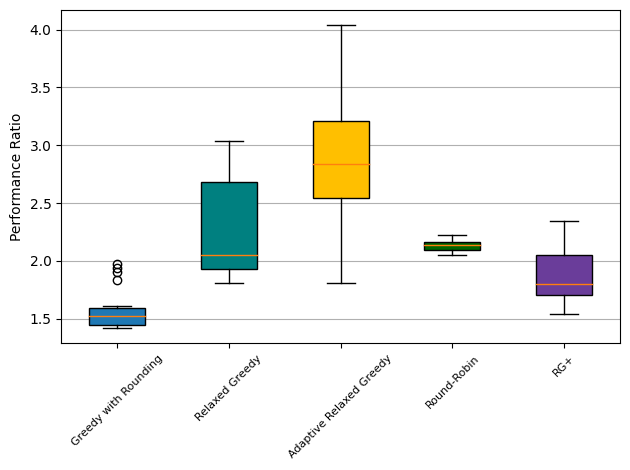

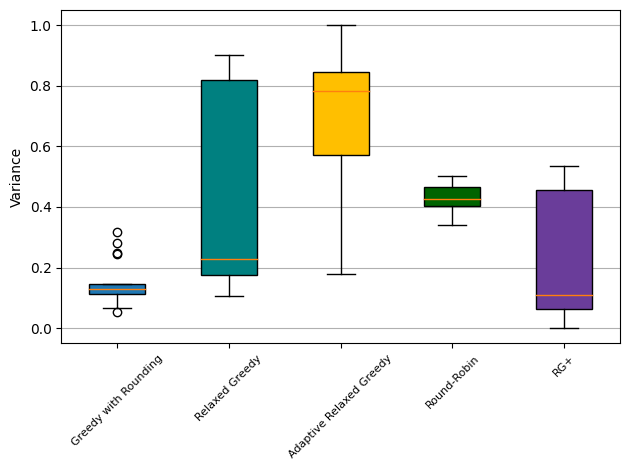

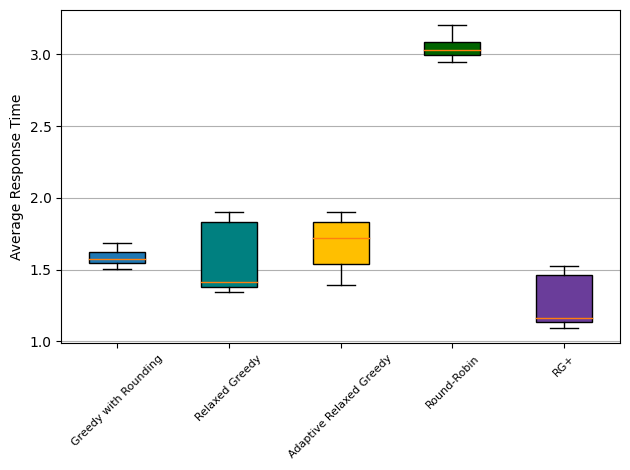

In [ ]:
BatchSet=generateBatchLogJob(0,1000,1,1000,2,20)
batch_test(BatchSet,1,0.1)

Performance ratio
[('Greedy with Rounding', [1.5373831775700935, 1.5414634146341464, 1.4688995215311005, 1.4727272727272727, 1.4908256880733946, 1.5445544554455446, 1.9278846153846154, 1.449339207048458, 1.603864734299517, 1.4170616113744077, 2.0, 1.5884955752212389, 1.5454545454545454, 1.8227272727272728, 2.077294685990338, 1.4727272727272727, 1.6208530805687205, 1.577319587628866, 1.8181818181818181, 1.4372294372294372]), ('Relaxed Greedy', [3.2663551401869158, 3.7219512195121953, 3.444976076555024, 3.668181818181818, 3.4220183486238533, 3.5396039603960396, 4.408653846153846, 3.3876651982378854, 3.5458937198067635, 4.696682464454977, 3.4776119402985075, 3.6327433628318584, 3.7525252525252526, 3.7045454545454546, 3.8067632850241546, 3.581818181818182, 3.5308056872037916, 3.365979381443299, 3.411483253588517, 3.380952380952381]), ('Adaptive Relaxed Greedy', [3.2663551401869158, 3.7219512195121953, 3.444976076555024, 3.668181818181818, 3.4220183486238533, 3.5396039603960396, 3.509615384

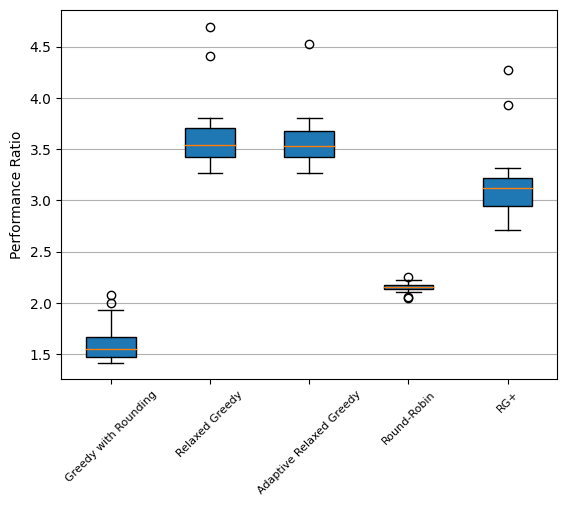

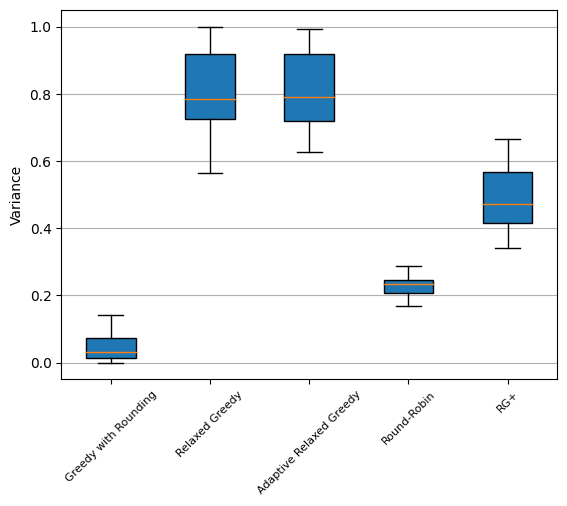

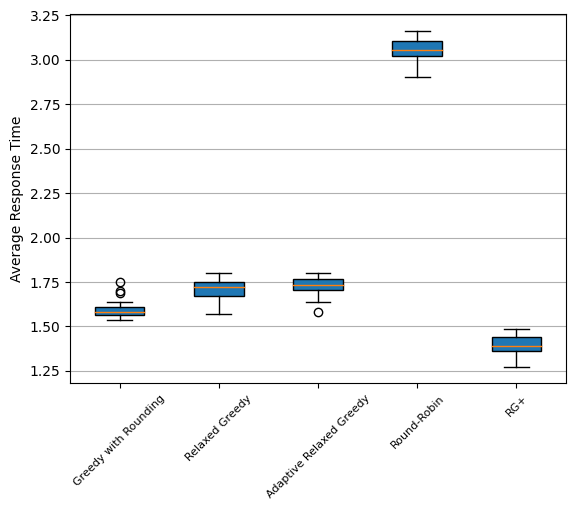

In [ ]:
BatchSet=generateBatchLogJob(0,1000,1,1000,4,20)
batch_test(BatchSet,1,0.1)

Performance ratio
[('Greedy with Rounding', [1.4879227053140096, 1.5775862068965518, 1.4930232558139536, 1.8333333333333333, 1.5942028985507246, 1.7850467289719627, 1.5023041474654377, 1.7889908256880733, 1.5570776255707763, 1.8511627906976744, 1.6172248803827751, 1.368663594470046, 1.5625, 1.9817351598173516, 1.5714285714285714, 1.9255813953488372, 2.0295566502463056, 1.6586538461538463, 1.6213592233009708, 1.4504950495049505]), ('Relaxed Greedy', [4.0144927536231885, 3.875, 4.0, 4.63963963963964, 3.995169082125604, 4.91588785046729, 3.9953917050691246, 3.981651376146789, 4.242009132420091, 5.037209302325581, 4.526315789473684, 4.529953917050691, 4.5, 4.712328767123288, 4.9, 4.902325581395349, 4.403940886699507, 4.384615384615385, 3.941747572815534, 4.648514851485149]), ('Adaptive Relaxed Greedy', [4.0144927536231885, 3.875, 3.827906976744186, 4.202702702702703, 3.995169082125604, 4.383177570093458, 3.847926267281106, 3.981651376146789, 3.9406392694063928, 4.506976744186047, 4.2870813

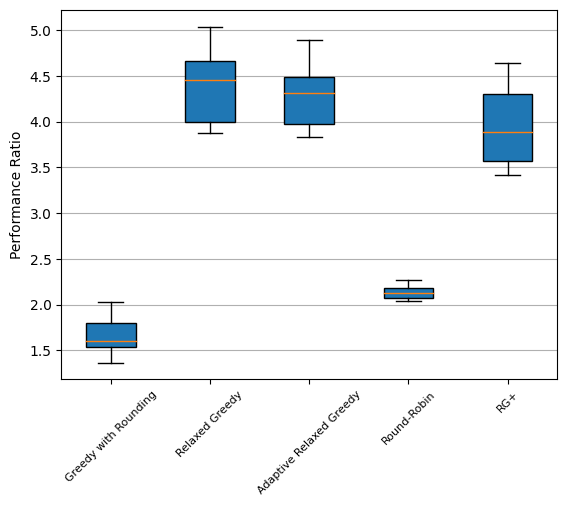

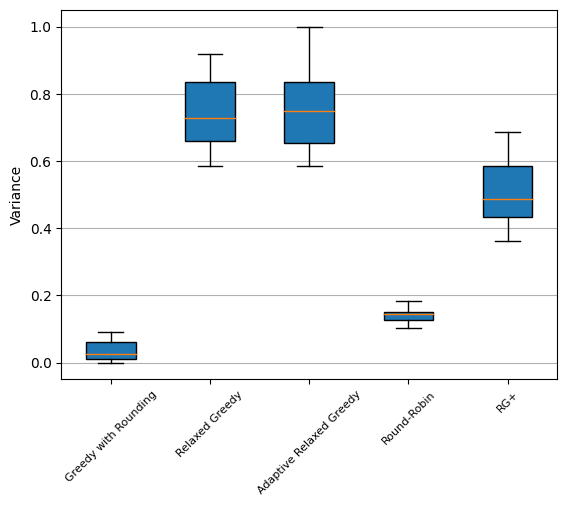

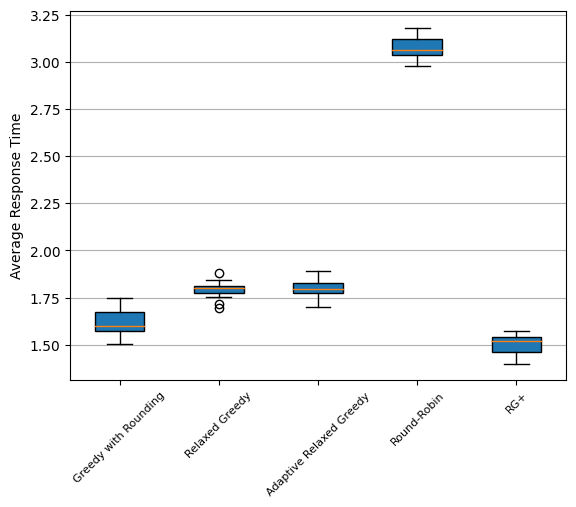

In [ ]:
BatchSet=generateBatchLogJob(0,1000,1,1000,8,20)
batch_test(BatchSet,1,0.1)

Performance ratio
[('Greedy with Rounding', [1.4796380090497738, 1.5198237885462555, 2.099476439790576, 1.54, 1.6127450980392157, 1.5345622119815667, 1.6403940886699508, 1.4504504504504505, 1.6465116279069767, 1.6556603773584906, 1.5666666666666667, 1.6, 1.5854922279792747, 1.5248868778280542, 1.591549295774648, 1.4035874439461884, 1.3846153846153846, 1.5317073170731708, 1.511737089201878, 1.525]), ('Relaxed Greedy', [4.65158371040724, 4.352422907488987, 5.696335078534031, 4.97, 5.147058823529412, 4.953917050691245, 4.679802955665025, 4.693693693693693, 4.920930232558139, 4.919811320754717, 4.585714285714285, 5.080952380952381, 4.642487046632124, 4.855203619909502, 4.342723004694836, 4.838565022421525, 4.257918552036199, 5.512195121951219, 4.755868544600939, 4.655]), ('Adaptive Relaxed Greedy', [4.65158371040724, 4.343612334801762, 5.277486910994765, 4.97, 4.598039215686274, 4.953917050691245, 4.679802955665025, 4.648648648648648, 4.748837209302326, 4.919811320754717, 4.585714285714285

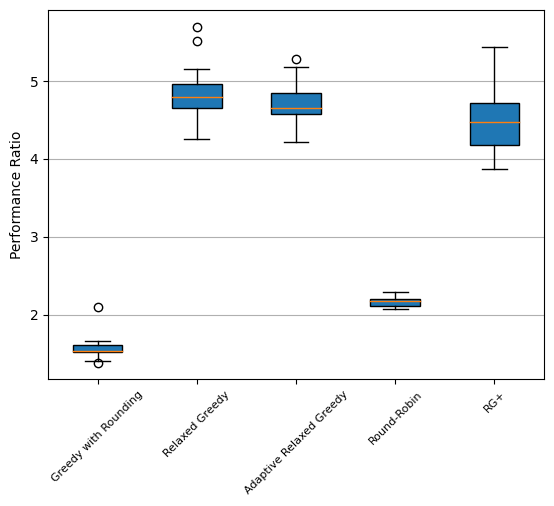

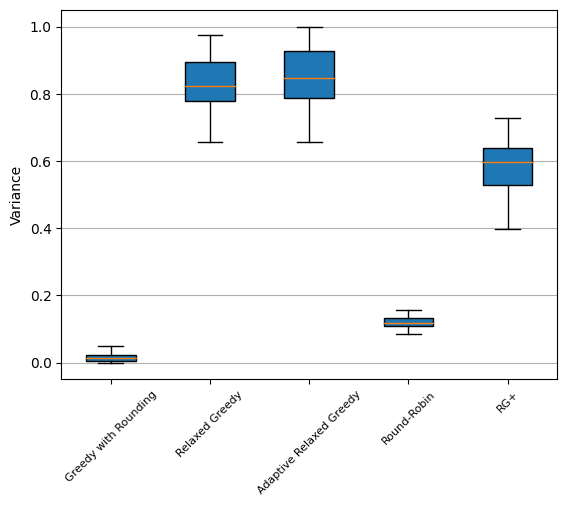

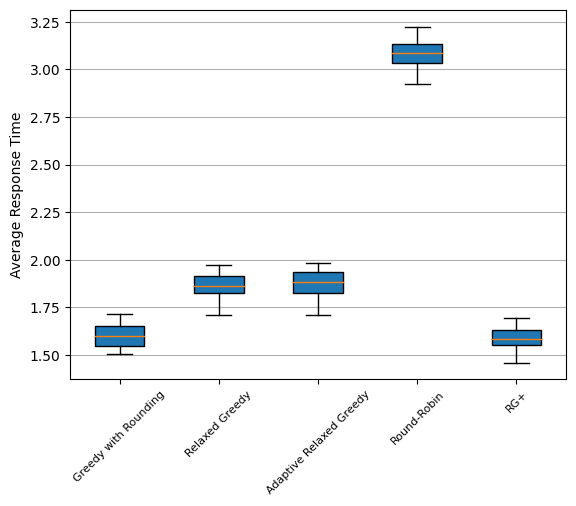

In [ ]:
BatchSet=generateBatchLogJob(0,1000,1,1000,16,20)
batch_test(BatchSet,1,0.1)

In [ ]:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

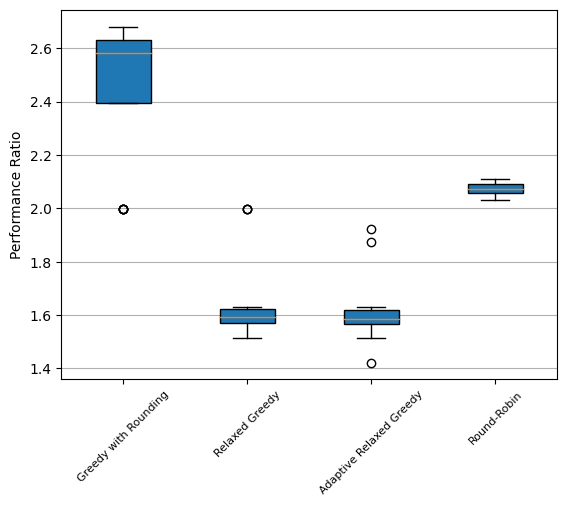

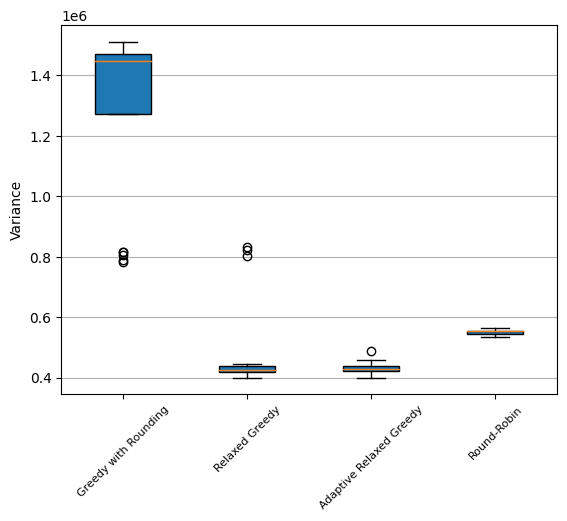

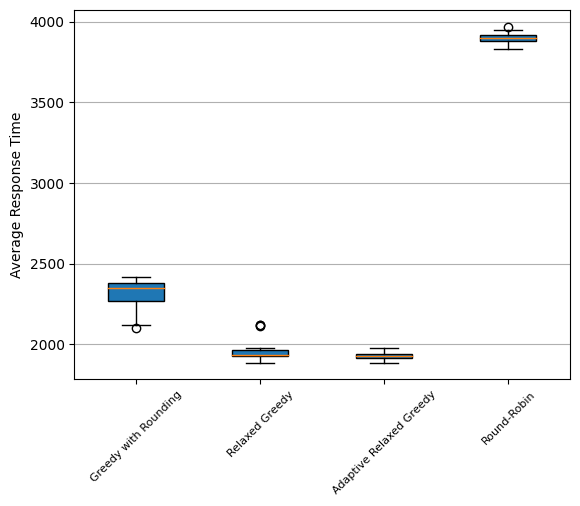

In [ ]:
#Release Time 0-1000
#Job Size Variance Scale 1
#Job Amount 4000
#Test Repeat 20 Times
#PredictError=1
#P_min_e_error=1
BatchSet=generateBatchLogJob(0,1000,1,4000,1,20)
batch_test(BatchSet)

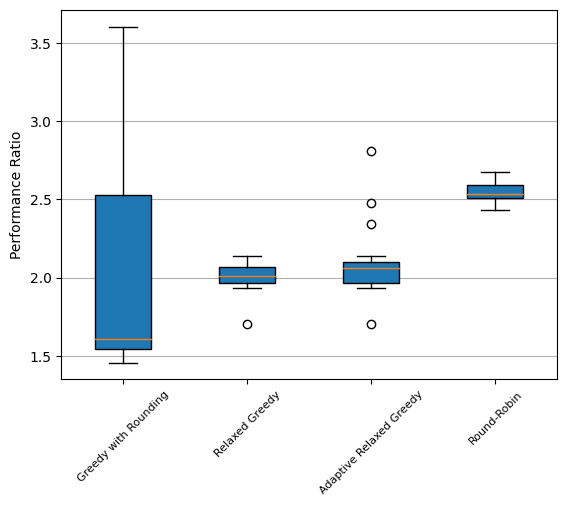

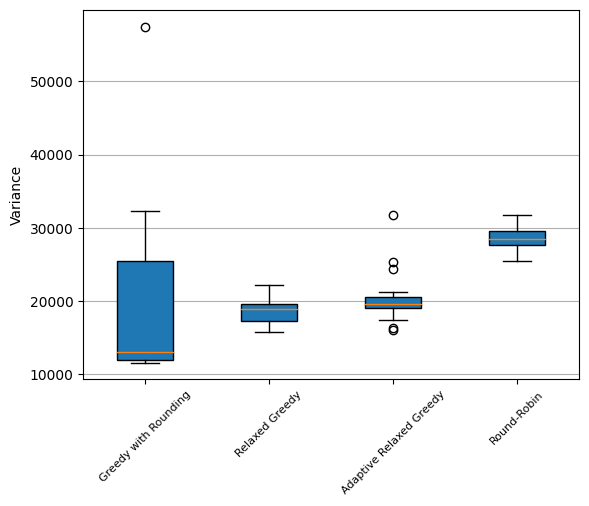

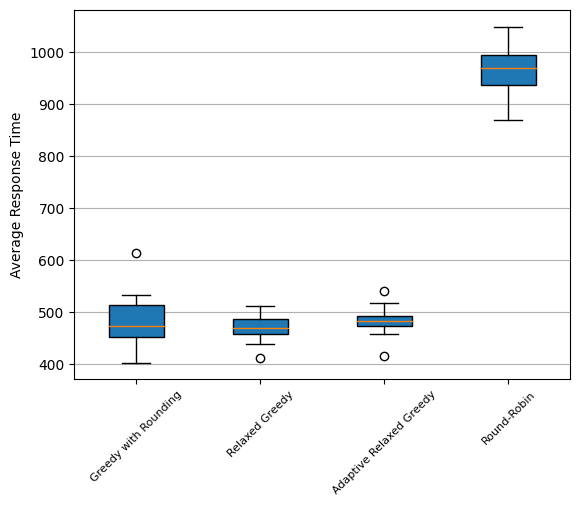

In [ ]:
#Release Time 0-1000
#Job Size Variance Scale 2
#Job Amount 1000
#Test Repeat 20 Times
#PredictError=1
#P_min_e_error=1
BatchSet=generateBatchLogJob(0,1000,2,1000,1,20)
batch_test(BatchSet)

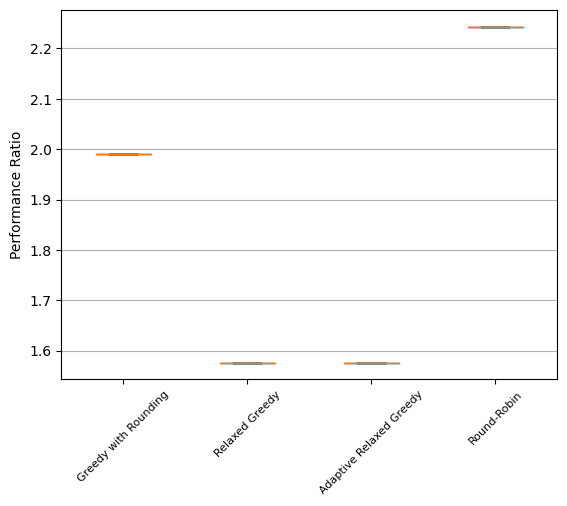

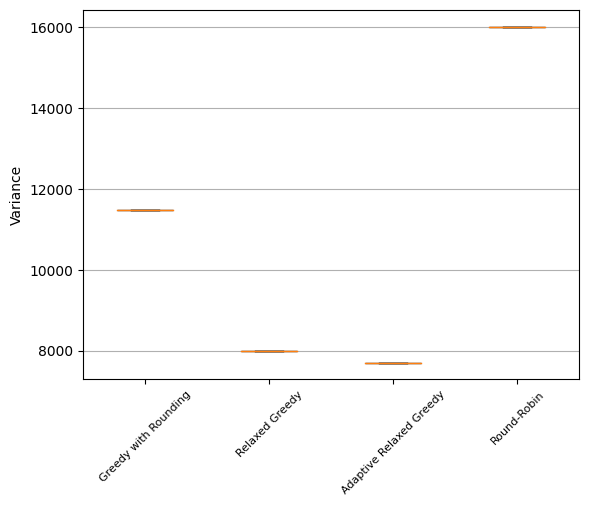

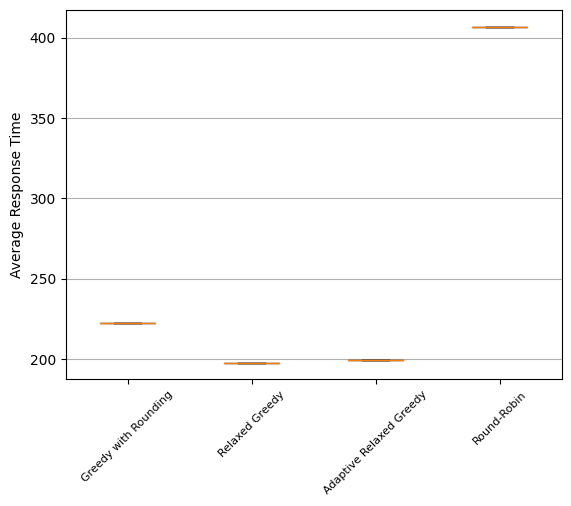

In [ ]:
#Release Time 0-1000
#Job Size Variance Scale 4
#Job Amount 1000
#Test Repeat 20 Times
#PredictError=1
#P_min_e_error=1
BatchSet=generateBatchLogJob(0,1000,1,1000,1,20,True)
batch_test(BatchSet)

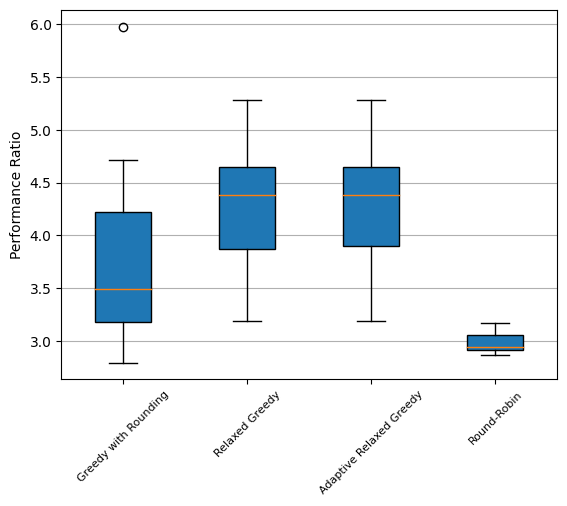

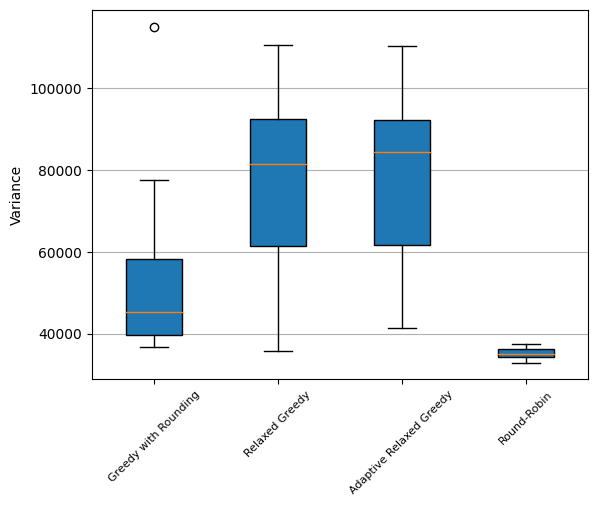

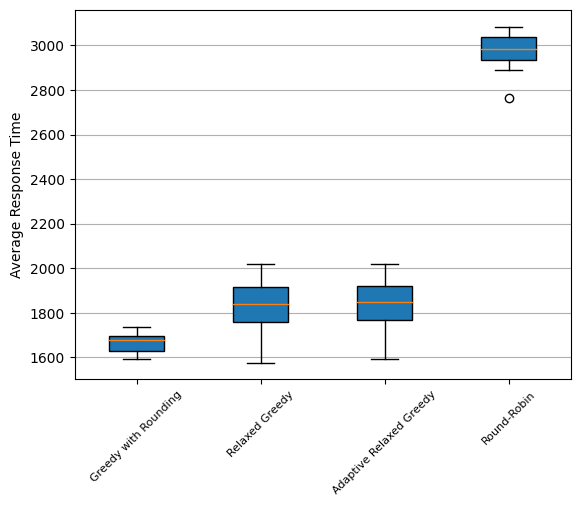

In [ ]:
#Release Time 0-1000
#Job Size Variance Scale 2
#Job Amount 1000
#Test Repeat 20 Times
#PredictError=1
#P_min_e_error=1
BatchSet=generateBatchLogJob(0,1000,6,1000,1,20)
batch_test(BatchSet)

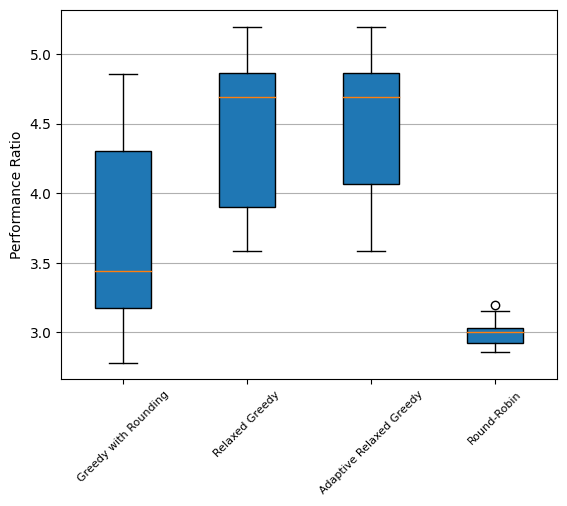

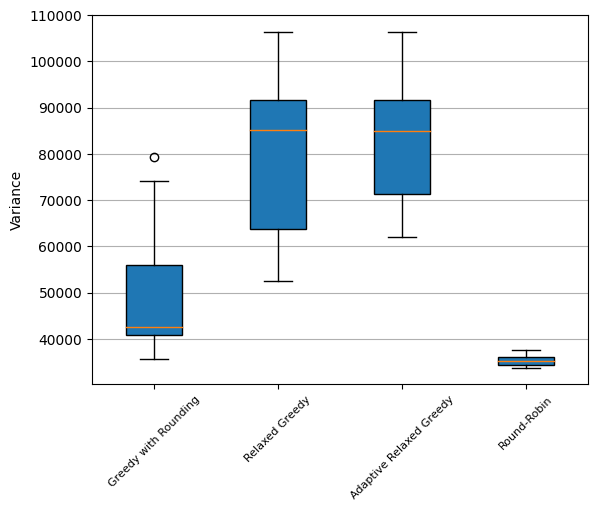

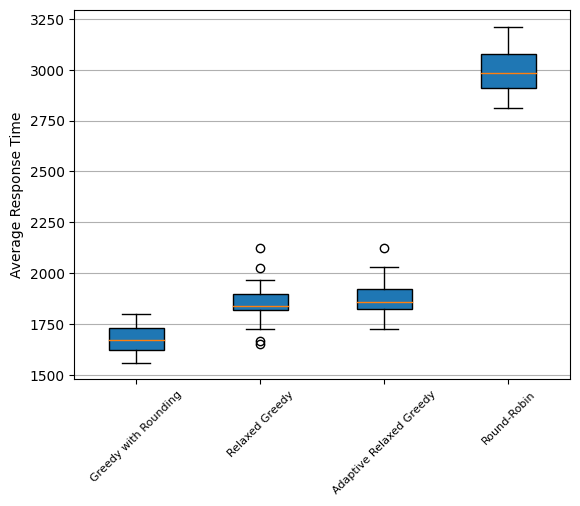

In [ ]:
#Release Time 0-1000
#Job Size Variance Scale 2
#Job Amount 1000
#Test Repeat 20 Times
#PredictError=1
#P_min_e_error=1
BatchSet=generateBatchLogJob(0,1000,6,1000,1,20)
batch_test(BatchSet)

In [ ]:
#Predict Error 2

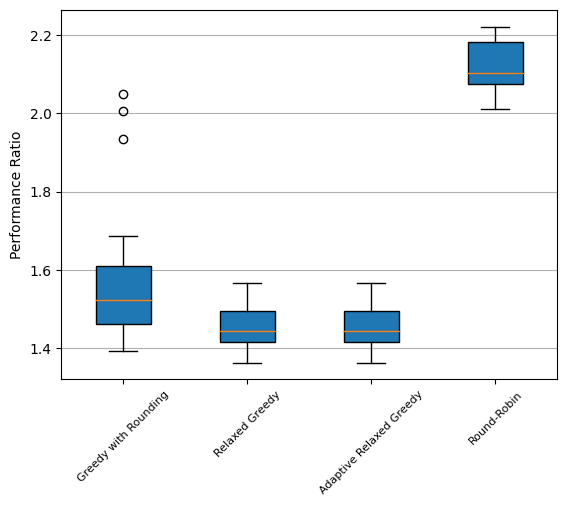

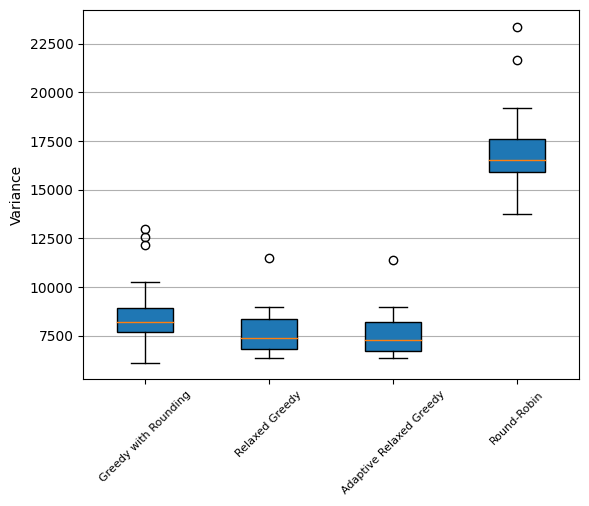

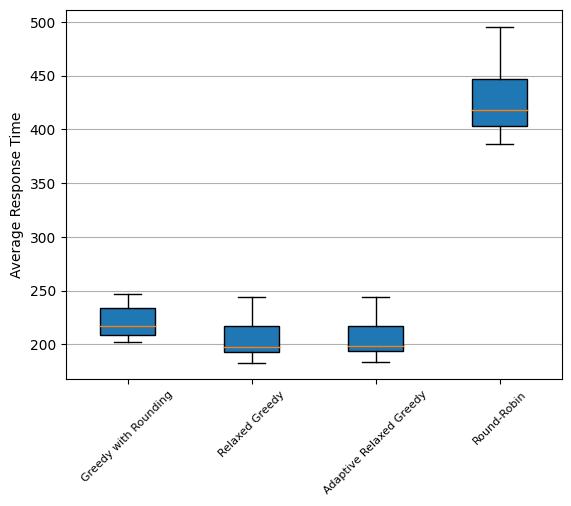

In [ ]:
#Release Time 0-1000
#Job Size Variance Scale 1
#Job Amount 1000
#Test Repeat 20 Times
#PredictError=2
#P_min_e_error=1
BatchSet=generateBatchLogJob(0,1000,1,1000,2,20)
batch_test(BatchSet)

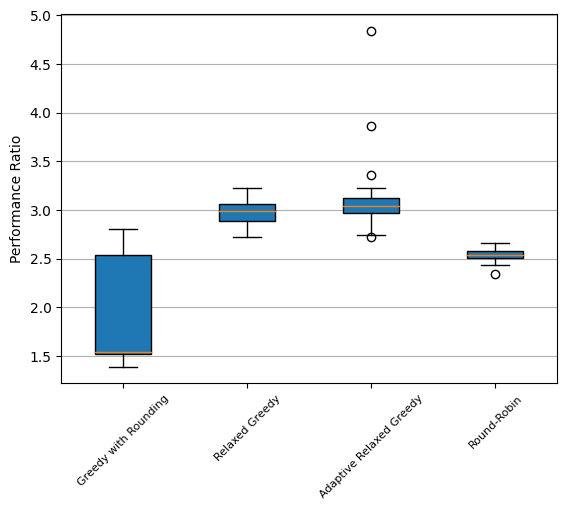

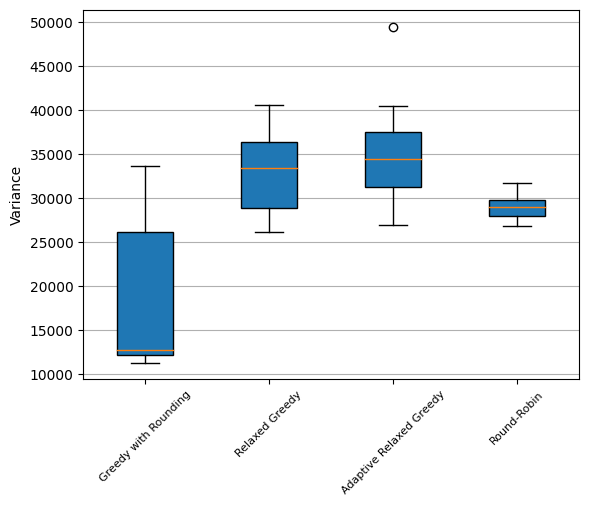

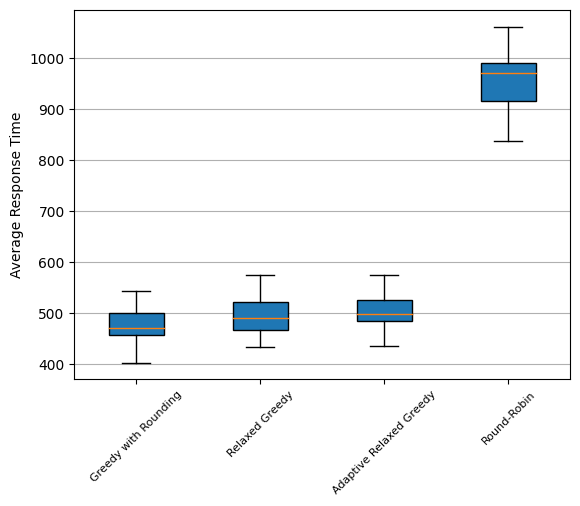

In [ ]:
#Release Time 0-1000
#Job Size Variance Scale 2
#Job Amount 1000
#Test Repeat 20 Times
#PredictError=2
#P_min_e_error=1
BatchSet=generateBatchLogJob(0,1000,2,1000,2,20)
batch_test(BatchSet)

In [ ]:
#Generate rr worst cases
mul=2
amount=100
counter=1
test=[]
while counter<amount:
  js=mul**counter-mul**(counter-1)
  test.append([js,0,js,counter,0.0])
  counter+=1
print(test)
test=convert_jobs(test)
#测试一开始手动加大job会不会有类似效果


[[1, 0, 1, 1, 0.0], [2, 0, 2, 2, 0.0], [4, 0, 4, 3, 0.0], [8, 0, 8, 4, 0.0], [16, 0, 16, 5, 0.0], [32, 0, 32, 6, 0.0], [64, 0, 64, 7, 0.0], [128, 0, 128, 8, 0.0], [256, 0, 256, 9, 0.0], [512, 0, 512, 10, 0.0], [1024, 0, 1024, 11, 0.0], [2048, 0, 2048, 12, 0.0], [4096, 0, 4096, 13, 0.0], [8192, 0, 8192, 14, 0.0], [16384, 0, 16384, 15, 0.0], [32768, 0, 32768, 16, 0.0], [65536, 0, 65536, 17, 0.0], [131072, 0, 131072, 18, 0.0], [262144, 0, 262144, 19, 0.0], [524288, 0, 524288, 20, 0.0], [1048576, 0, 1048576, 21, 0.0], [2097152, 0, 2097152, 22, 0.0], [4194304, 0, 4194304, 23, 0.0], [8388608, 0, 8388608, 24, 0.0], [16777216, 0, 16777216, 25, 0.0], [33554432, 0, 33554432, 26, 0.0], [67108864, 0, 67108864, 27, 0.0], [134217728, 0, 134217728, 28, 0.0], [268435456, 0, 268435456, 29, 0.0], [536870912, 0, 536870912, 30, 0.0], [1073741824, 0, 1073741824, 31, 0.0], [2147483648, 0, 2147483648, 32, 0.0], [4294967296, 0, 4294967296, 33, 0.0], [8589934592, 0, 8589934592, 34, 0.0], [17179869184, 0, 17179

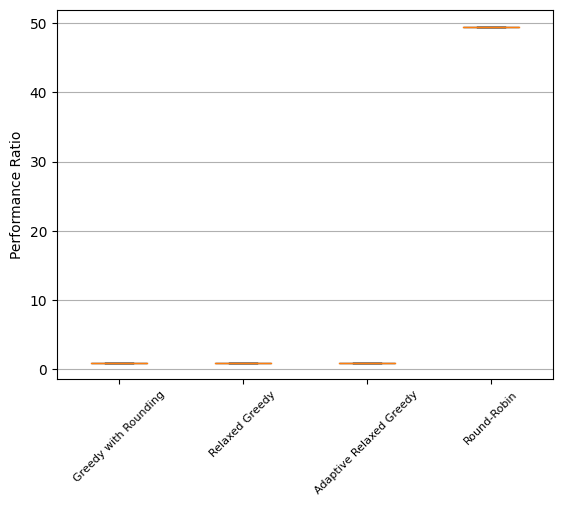

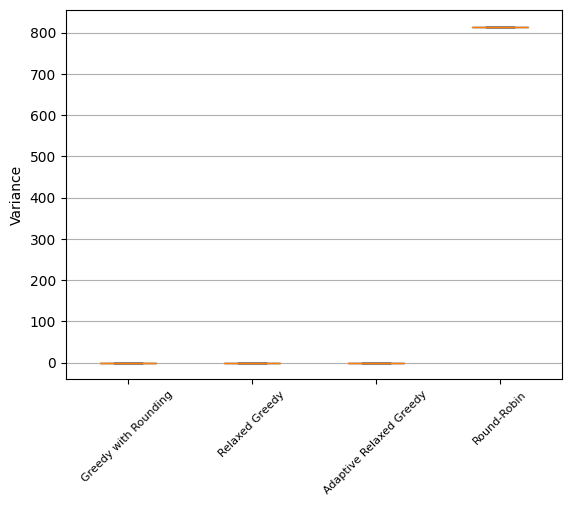

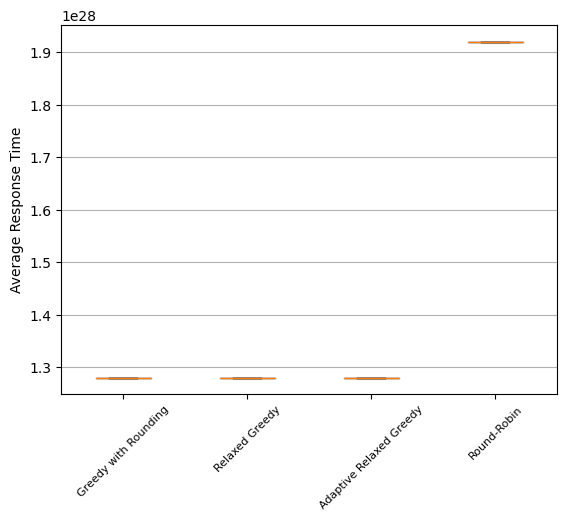

In [ ]:
#Release Time 0-1000
#Job Size Variance Scale 10
#Job Amount 100
#Test Repeat 20 Times
#PredictError=1
#P_min_e_error=1
BatchSet=generateBatchLogJob(0,1000,10,100,1,20)
BatchSet=[test]
batch_test(BatchSet)

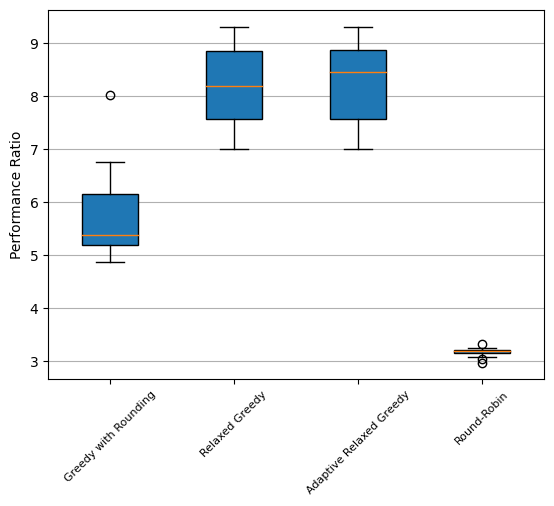

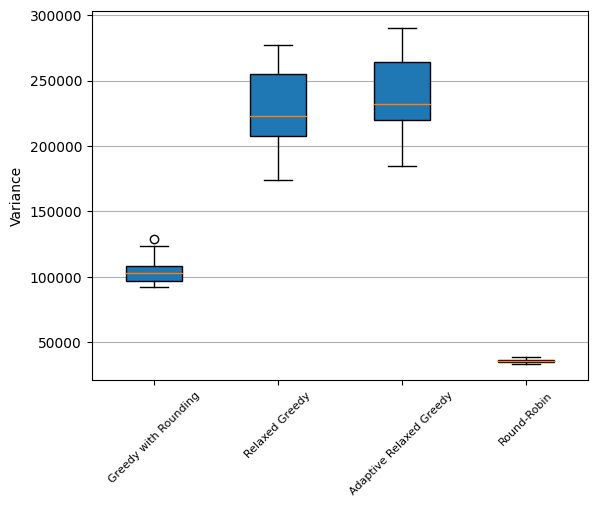

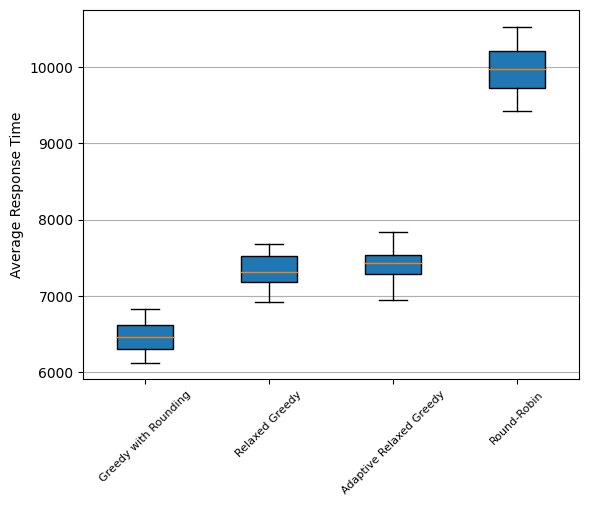

In [ ]:
#Release Time 0-1000
#Job Size Variance Scale 20
#Job Amount 100
#Test Repeat 20 Times
#PredictError=1
#P_min_e_error=1
BatchSet=generateBatchLogJob(0,1000,20,1000,1,20)
batch_test(BatchSet)

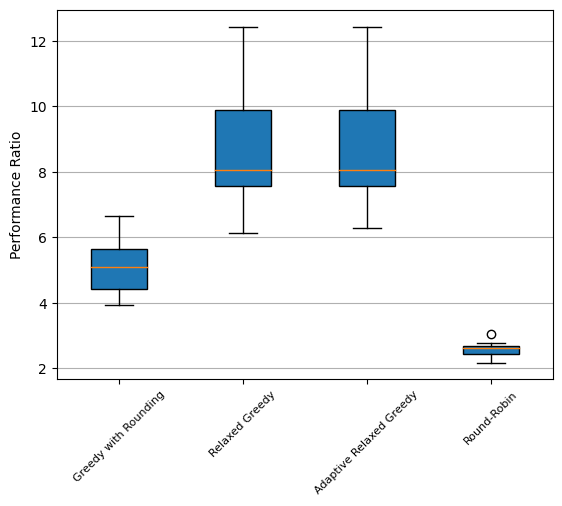

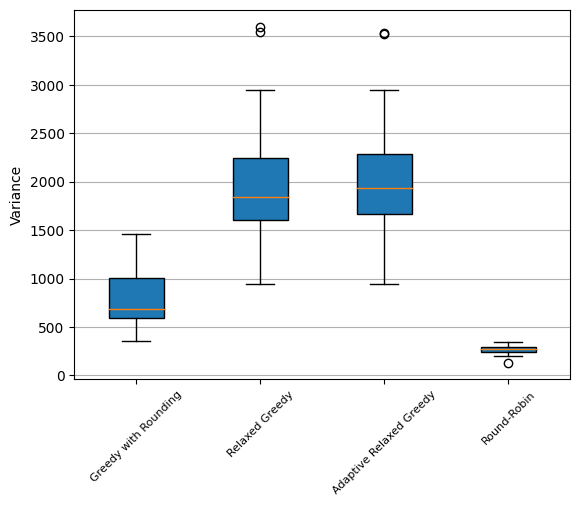

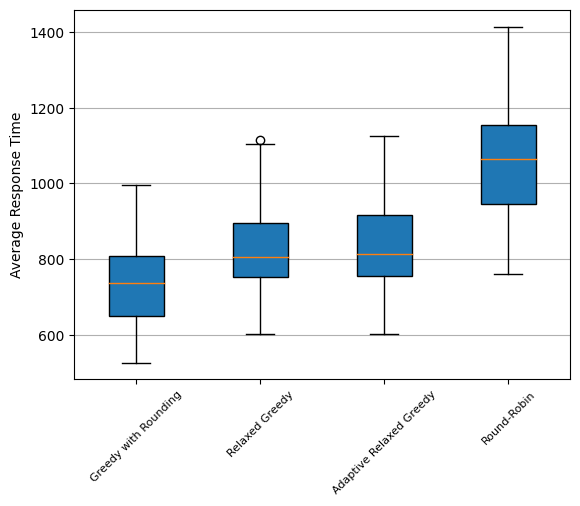

In [ ]:
#Release Time 0-1000
#Job Size Variance Scale 10
#Job Amount 100
#Test Repeat 30 Times
#PredictError=1
#P_min_e_error=1
BatchSet=generateBatchLogJob(0,1000,30,100,1,20)
batch_test(BatchSet)

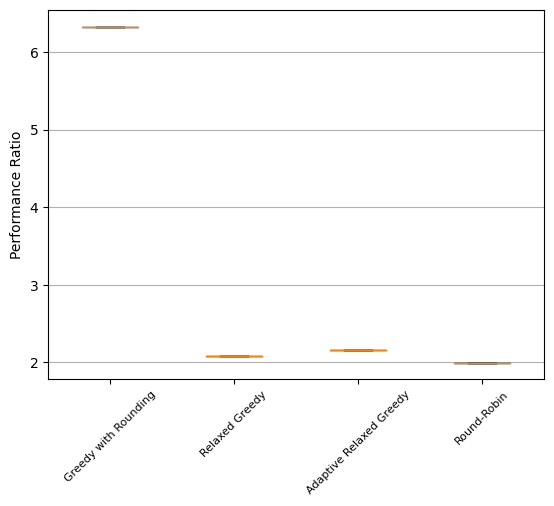

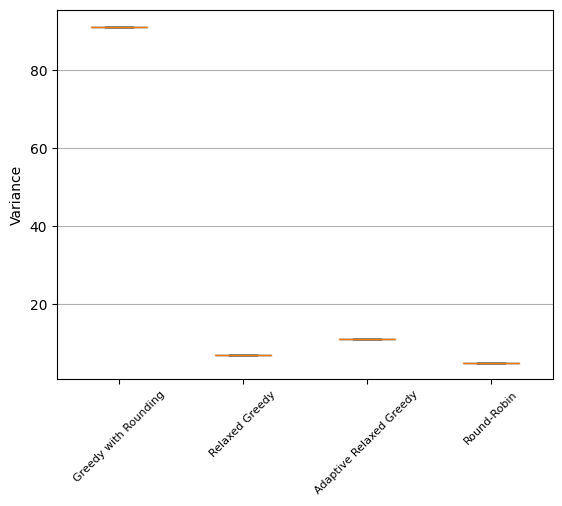

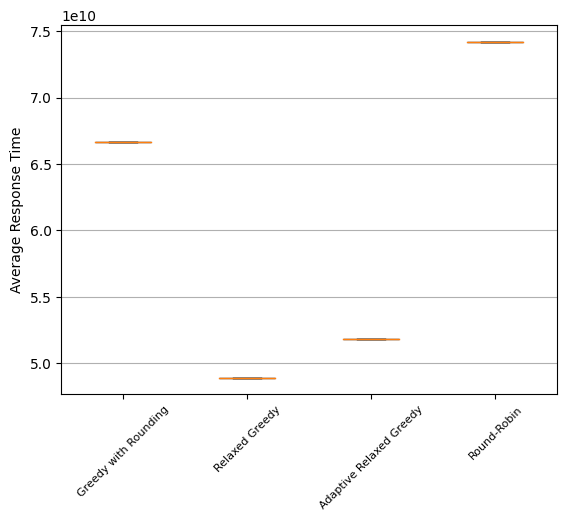

In [ ]:
20#Release Time 0-1000
#Job Size Variance Scale 10
#Job Amount 100
#Test Repeat 30 Times
#PredictError=1
#P_min_e_error=1
BatchSet=generateBatchLogJob(0,10000000,10000000000,10,1,1,True)

#BatchSet=generateBatchLogJob(0,20000,40,1000,1,20)
batch_test(BatchSet)

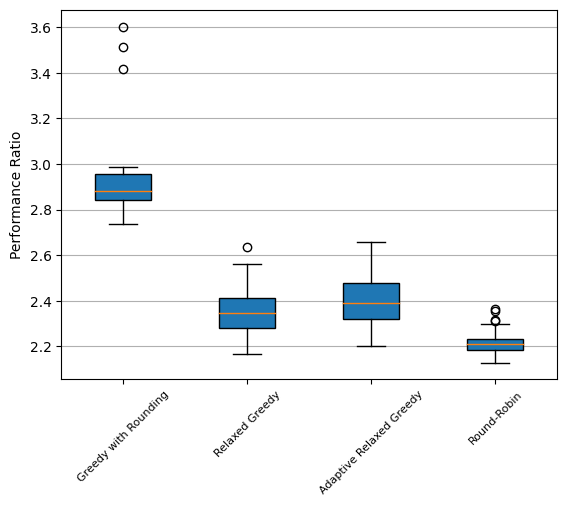

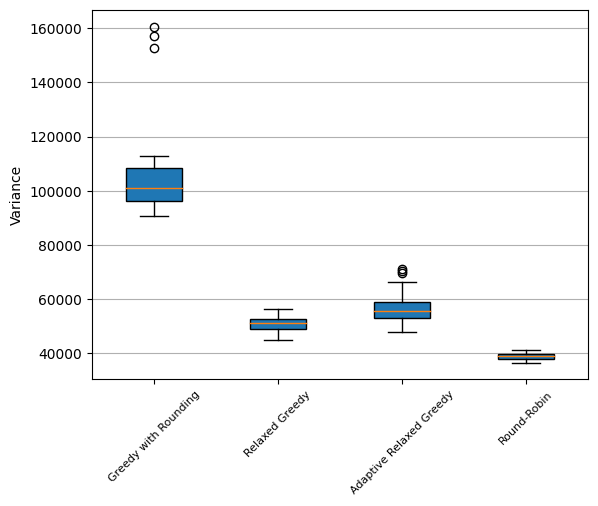

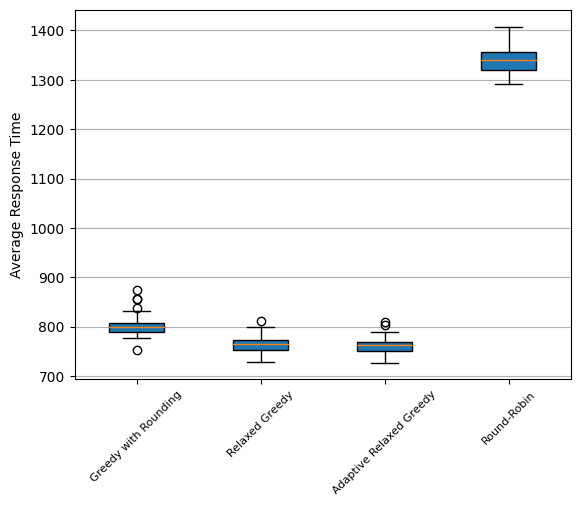

In [ ]:
#Release Time 0-1000
#Job Size Variance Scale 1
#Job Amount 1000
#Test Repeat 20 Times
#PredictError=1
#P_min_e_error=1
#releaseTime_lb,releaseTime_ub,scale_ratio,job_amount,predict_error, job set sizes
BatchSet=generateBatchLogJob(0,100,1.6,1000,2,40)
batch_test(BatchSet)

<ipython-input-15-6fb669155afb>:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_values = group_df.groupby('X_mapped').median()['Value']
<ipython-input-15-6fb669155afb>:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_values = group_df.groupby('X_mapped').median()['Value']
<ipython-input-15-6fb669155afb>:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_values = group_df.groupby('X_mapped'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

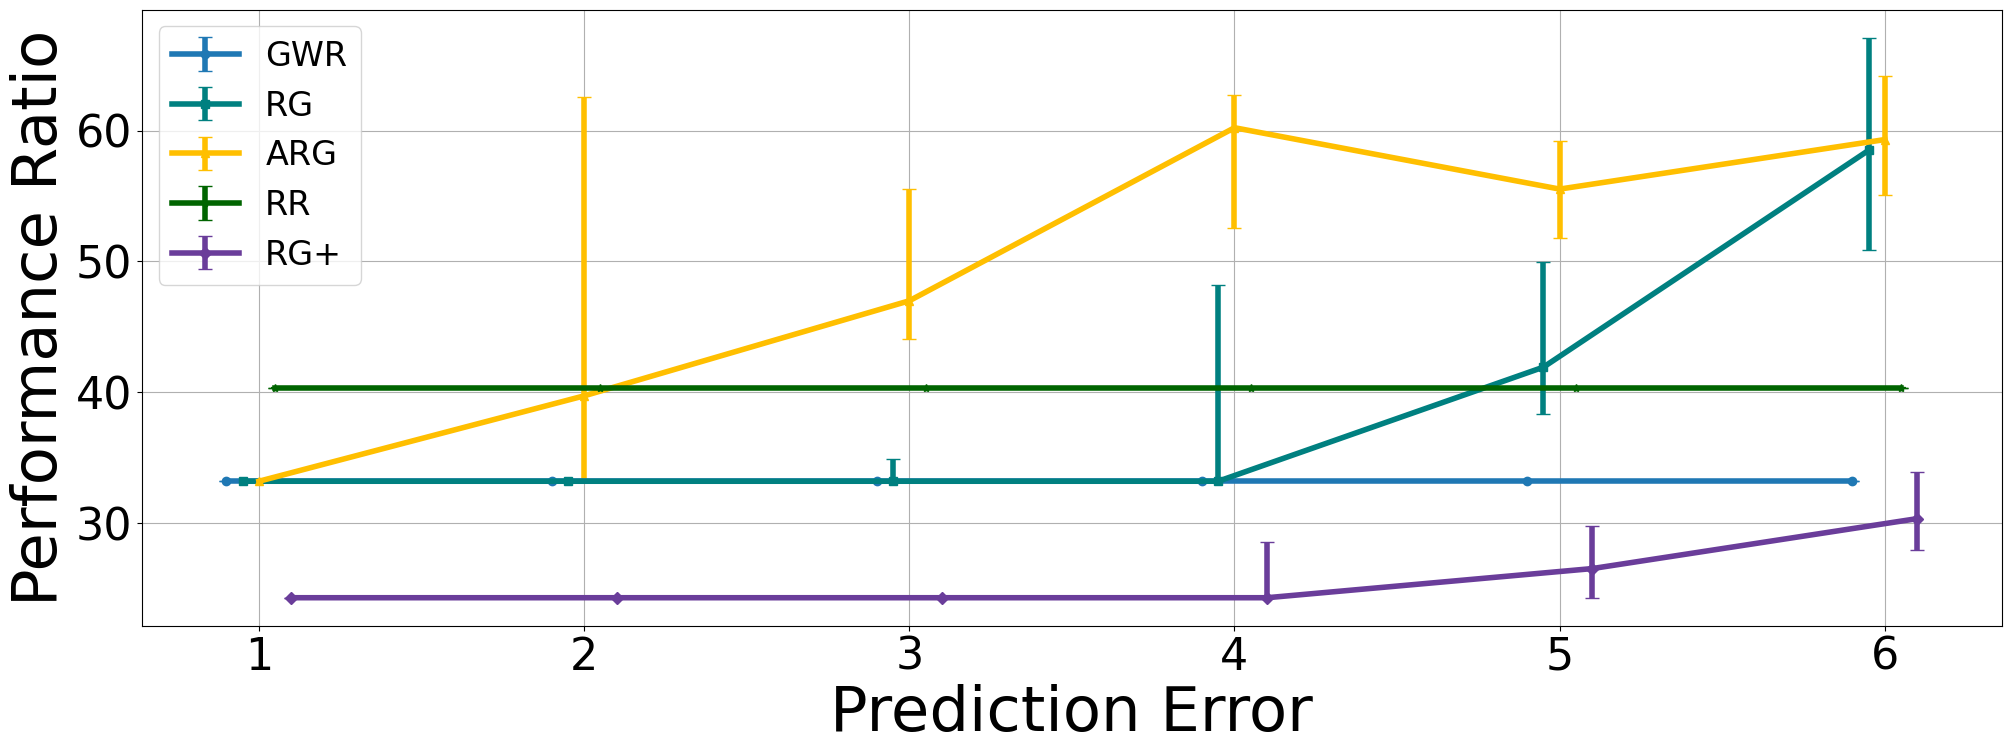

In [17]:
import math
def ali_data(i_error):
  Batch_job_set = []
  for i in range(0, 20):
    test = []
    minimal_p = 99999999;
    maximal_p = 0;
    counter = 0
    target_max = 30
    f= open('/content/out_gbdt.csv')
    lines = f.readlines()
    for line in lines:
      # i_leftSize,i_releaseTime,i_jobSize,i_jobID,i_error
        if counter > 0:
          line = line.strip()
          dr = line.split(",")
          if int(round(float(dr[1]))) < minimal_p:
            minimal_p = int(round(float(dr[1])))
          if int(round(float(dr[1]))) > maximal_p:
            maximal_p = int(round(float(dr[1])))

          scaleJobSize = (int(round(float(dr[1])))-1)/880*(target_max-1)+1
          error_bound=math.log(i_error)
          error_i=random.uniform(-error_bound,error_bound)
          test.append([scaleJobSize, int(round(float(dr[0]))), scaleJobSize, counter, error_i])

          # test.append([scaleJobSize, int(round(float(dr[0]))), scaleJobSize, counter, math.log(int(round(float(dr[2])))/int(round(float(dr[1]))))])
          # # if int(round(float(dr[1]))) > 200:
          #   print(scaleJobSize)
          # if int(round(float(dr[1]))) > 9:
          #   test.append([int(round(float(dr[1]))), 0, int(round(float(dr[1]))), counter, 4])
          # else:
          #   test.append([int(round(float(dr[1]))), int(round(float(dr[0]))), int(round(float(dr[1]))), counter, 4])
          # test.append([int(round(float(dr[1]))), int(round(float(dr[0]))), int(round(float(dr[1]))), counter, 1])
          # print([int(round(float(dr[1]))), int(round(float(dr[0]))), int(round(float(dr[1]))), counter, int(round(float(dr[2])))])

        counter = counter + 1
    f.close()
    test = convert_jobs(test)
    Batch_job_set.append(test)
  return Batch_job_set

S2_Data,V2_Data,R2_Data=[],[],[]
BatchSet=ali_data(1)
batch_record(1,S2_Data,V2_Data,R2_Data,BatchSet,1,0.3)
BatchSet=ali_data(2)
batch_record(2,S2_Data,V2_Data,R2_Data,BatchSet,1,0.3)
BatchSet=ali_data(3)
batch_record(3,S2_Data,V2_Data,R2_Data,BatchSet,1,0.3)
BatchSet=ali_data(4)
batch_record(4,S2_Data,V2_Data,R2_Data,BatchSet,1,0.3)
BatchSet=ali_data(5)
batch_record(5,S2_Data,V2_Data,R2_Data,BatchSet,1,0.3)
BatchSet=ali_data(6)
batch_record(6,S2_Data,V2_Data,R2_Data,BatchSet,1,0.3)
s_df = pd.DataFrame(S2_Data)
draw_error_bar(s_df,"Max-Stretch Performance ali","Prediction Error","Performance Ratio")

<ipython-input-57-6fb669155afb>:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_values = group_df.groupby('X_mapped').median()['Value']
<ipython-input-57-6fb669155afb>:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_values = group_df.groupby('X_mapped').median()['Value']
<ipython-input-57-6fb669155afb>:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_values = group_df.groupby('X_mapped'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

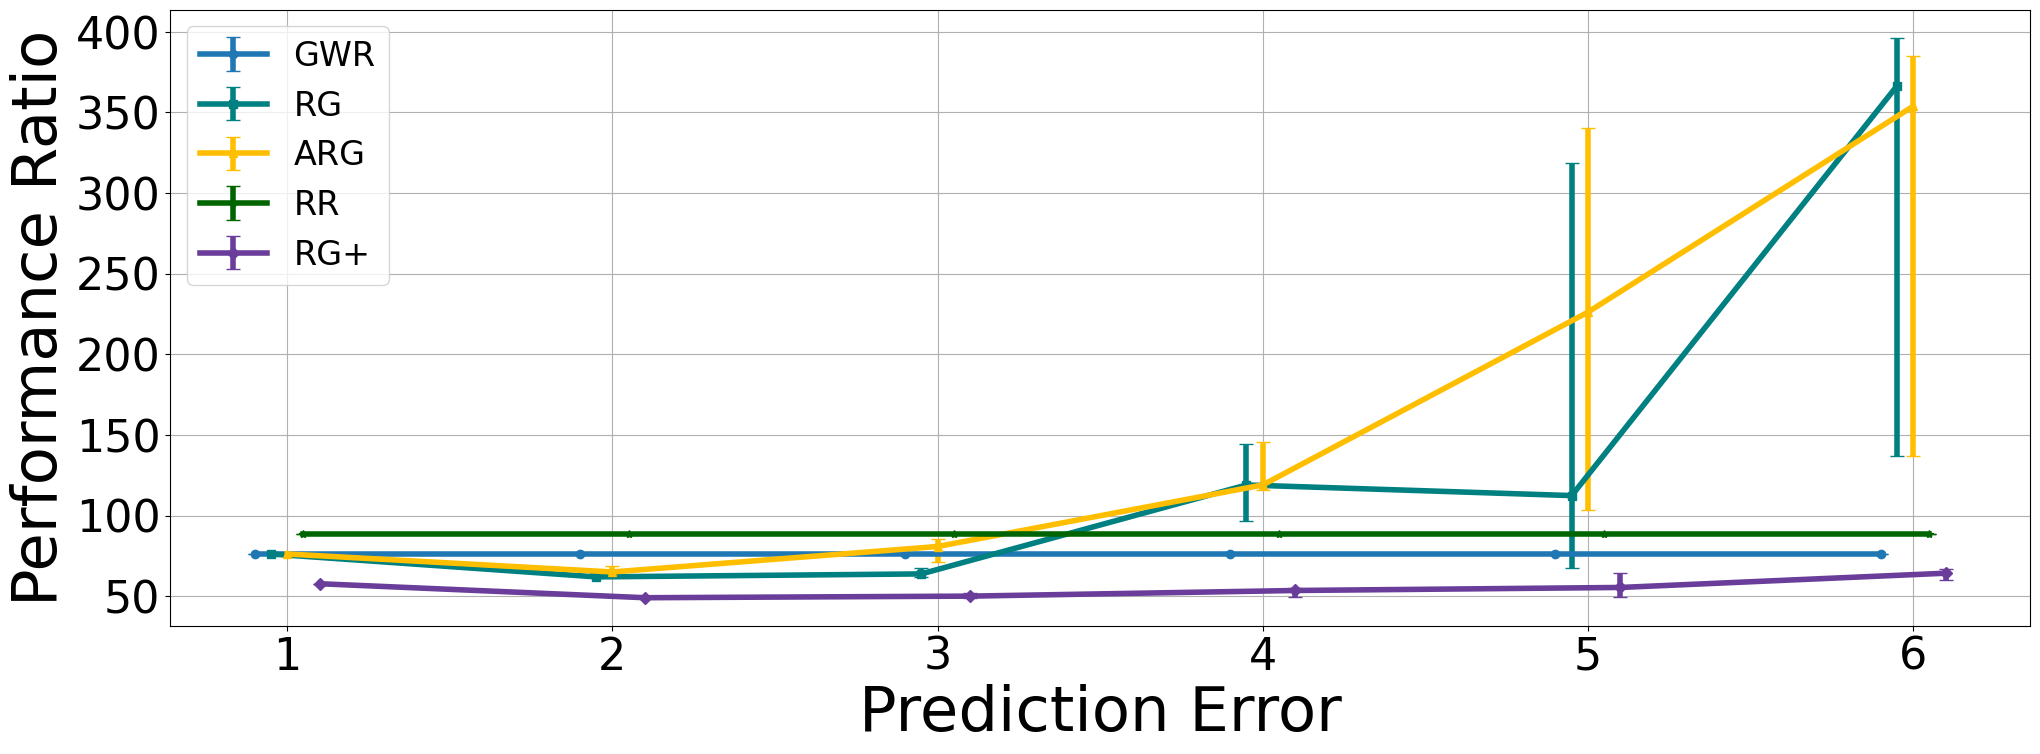

In [ ]:
import math
def azure_data(i_error):
  Batch_job_set = []
  for i in range(0, 20):
    test = []
    minimal_p = 99999999;
    maximal_p = 0;
    counter = 0
    target_max = 30
    f= open('/content/out_nn_azure.csv')
    lines = f.readlines()
    for line in lines:
      # i_leftSize,i_releaseTime,i_jobSize,i_jobID,i_error
        if counter > 0:
          line = line.strip()
          dr = line.split(",")
          if int(round(float(dr[1]))) < minimal_p:
            minimal_p = int(round(float(dr[1])))
          if int(round(float(dr[1]))) > maximal_p:
            maximal_p = int(round(float(dr[1])))
          scaleJobSize = (int(round(float(dr[1])))-1)/259*(target_max-1)+1
          error_bound=math.log(i_error)
          error_i=random.uniform(-error_bound,error_bound)
          # if scaleJobSize > 3:
          #   test.append([scaleJobSize, 100, scaleJobSize, counter,error_bound])
          # else:
          test.append([scaleJobSize, int(round(float(dr[0]))), scaleJobSize, counter,error_i])
          # print(counter)
          # predict_value = int(round(float(dr[2])))
          # if predict_value < 0:
          #   predict_value = 0 - predict_value
          # test.append([scaleJobSize, int(round(float(dr[0]))), scaleJobSize, counter, math.log(predict_value/int(round(float(dr[1]))))])
          # test.append([int(round(float(dr[1]))), int(round(float(dr[0]))), int(round(float(dr[1]))), counter, 2])
          # print([int(round(float(dr[1]))), int(round(float(dr[0]))), int(round(float(dr[1]))), counter, int(round(float(dr[2])))])
        counter = counter + 1
    f.close()
    test = convert_jobs(test)
    Batch_job_set.append(test)
  return Batch_job_set


S2_Data,V2_Data,R2_Data=[],[],[]
BatchSet=azure_data(1)
batch_record(1,S2_Data,V2_Data,R2_Data,BatchSet,1,0.3)
BatchSet=azure_data(2)
batch_record(2,S2_Data,V2_Data,R2_Data,BatchSet,1,0.3)
BatchSet=azure_data(3)
batch_record(3,S2_Data,V2_Data,R2_Data,BatchSet,1,0.3)
BatchSet=azure_data(4)
batch_record(4,S2_Data,V2_Data,R2_Data,BatchSet,1,0.3)
BatchSet=azure_data(5)
batch_record(5,S2_Data,V2_Data,R2_Data,BatchSet,1,0.3)
BatchSet=azure_data(6)
batch_record(6,S2_Data,V2_Data,R2_Data,BatchSet,1,0.3)
s_df = pd.DataFrame(S2_Data)
draw_error_bar(s_df,"Max-Stretch Performance azure","Prediction Error","Performance Ratio")


<ipython-input-57-6fb669155afb>:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_values = group_df.groupby('X_mapped').median()['Value']
<ipython-input-57-6fb669155afb>:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_values = group_df.groupby('X_mapped').median()['Value']
<ipython-input-57-6fb669155afb>:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_values = group_df.groupby('X_mapped'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

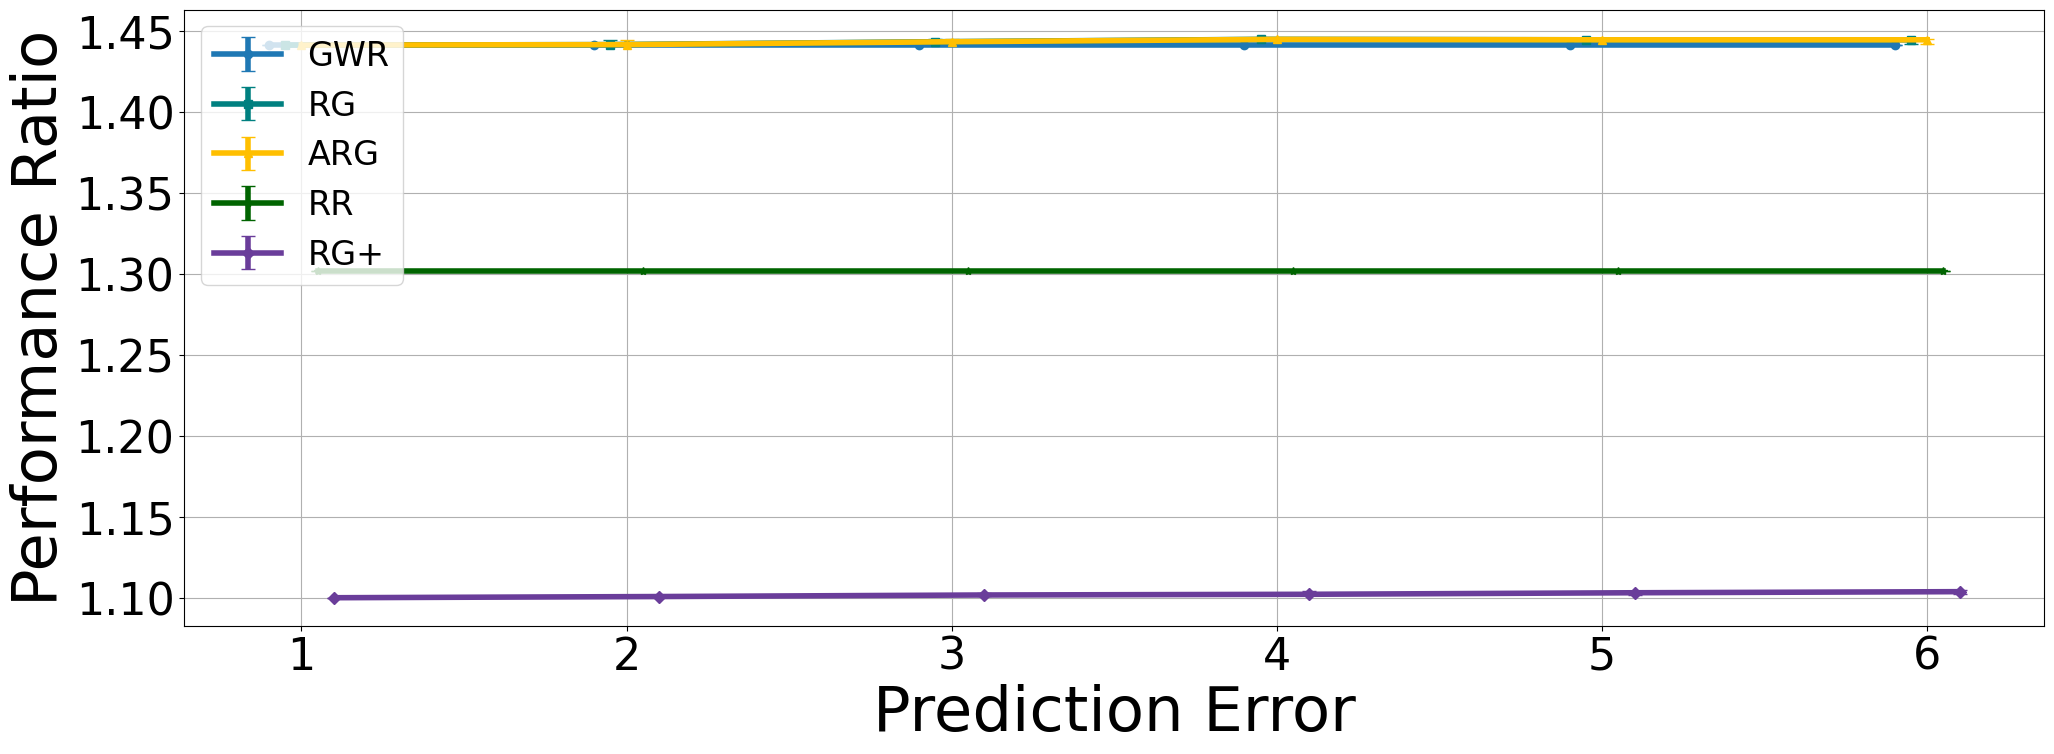

In [ ]:
import math
def google_data(i_error):
  Batch_job_set = []
  for i in range(0, 20):
    test = []
    minimal_p = 99999999;
    maximal_p = 0;
    counter = 0
    target_max = 50
    f= open('/content/out_nn.csv')
    lines = f.readlines()
    for line in lines:
      # i_leftSize,i_releaseTime,i_jobSize,i_jobID,i_error
        if counter > 0:
          line = line.strip()
          dr = line.split(",")
          if int(round(float(dr[1]))) < minimal_p:
            minimal_p = int(round(float(dr[1])))
          if int(round(float(dr[1]))) > maximal_p:
            maximal_p = int(round(float(dr[1])))
          scaleJobSize = (int(round(float(dr[1])))-1)/(256128-1)*(target_max-1)+100
          error_bound=math.log(i_error)
          error_i=random.uniform(-error_bound,error_bound)
          # if scaleJobSize > 3:
          #   test.append([scaleJobSize, 300, scaleJobSize, counter,error_bound])
          # else:
          #   test.append([scaleJobSize, int(round(float(dr[0]))), scaleJobSize, counter,error_bound])
          test.append([scaleJobSize, int(round(float(dr[0]))), scaleJobSize, counter,error_i])
          # test.append([scaleJobSize, int(round(float(dr[0]))), scaleJobSize, counter, math.log(int(round(float(dr[2])))/int(round(float(dr[1]))))])
          # test.append([int(round(float(dr[1]))), int(round(float(dr[0]))), int(round(float(dr[1]))), counter, 1])
          # print([int(round(float(dr[1]))), int(round(float(dr[0]))), int(round(float(dr[1]))), counter, int(round(float(dr[2])))])
        counter = counter + 1
    f.close()
    # print(minimal_p)
    # print(maximal_p)
    test = convert_jobs(test)
    Batch_job_set.append(test)
  return Batch_job_set

S2_Data,V2_Data,R2_Data=[],[],[]
BatchSet=google_data(1)
batch_record(1,S2_Data,V2_Data,R2_Data,BatchSet,1,0.3)
BatchSet=google_data(2)
batch_record(2,S2_Data,V2_Data,R2_Data,BatchSet,1,0.3)
BatchSet=google_data(3)
batch_record(3,S2_Data,V2_Data,R2_Data,BatchSet,1,0.3)
BatchSet=google_data(4)
batch_record(4,S2_Data,V2_Data,R2_Data,BatchSet,1,0.3)
BatchSet=google_data(5)
batch_record(5,S2_Data,V2_Data,R2_Data,BatchSet,1,0.3)
BatchSet=google_data(6)
batch_record(6,S2_Data,V2_Data,R2_Data,BatchSet,1,0.3)
s_df = pd.DataFrame(S2_Data)
draw_error_bar(s_df,"Max-Stretch Performance google","Prediction Error","Performance Ratio")